# Метрика

Перед решением любой задачи важно понимать, как будет оцениваться ваше решение. В данном случае мы используем стандартную для задачи классификации метрику ROC-AUC. Ее можно вычислить используя только предсказанные вероятности и истинные классы без конкретного порога классификации + она раотает даже если классы в данных сильно несбалансированны (примеров одного класса в десятки раз больше примеров длугого). Именно поэтому она очень удобна для соревнований.

Посчитать ее легко:


In [1]:
from sklearn.metrics import roc_auc_score

y_true = [
    0,
    1,
    1,
    0,
    1
]

y_predictions = [
    0.1,
    0.9,
    0.4,
    0.6,
    0.61
]

roc_auc_score(y_true, y_predictions)

0.8333333333333333

# Первая часть. Исследование

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

## Загрузка данных

In [3]:
data = pd.read_csv('train.csv')

In [4]:
# Числовые признаки
num_cols = [
    'ClientPeriod',
    'MonthlySpending',
    'TotalSpent'
]

# Категориальные признаки
cat_cols = [
    'Sex',
    'IsSeniorCitizen',
    'HasPartner',
    'HasChild',
    'HasPhoneService',
    'HasMultiplePhoneNumbers',
    'HasInternetService',
    'HasOnlineSecurityService',
    'HasOnlineBackup',
    'HasDeviceProtection',
    'HasTechSupportAccess',
    'HasOnlineTV',
    'HasMovieSubscription',
    'HasContractPhone',
    'IsBillingPaperless',
    'PaymentMethod'
]

feature_cols = num_cols + cat_cols
target_col = 'Churn'

#### Размерность:

In [5]:
data.shape

(5282, 20)

#### Посмотреть часть набор данных:

In [6]:
data.head()

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,Churn
0,55,19.50,1026.35,Male,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,No,Mailed check,0
1,72,25.85,1872.2,Male,0,Yes,No,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Credit card (automatic),0
2,1,75.90,75.9,Male,0,No,No,Yes,No,Fiber optic,No,No,No,Yes,No,No,Month-to-month,Yes,Electronic check,1
3,32,79.30,2570,Female,1,Yes,No,Yes,Yes,Fiber optic,No,No,Yes,No,No,No,Month-to-month,No,Mailed check,0
4,60,115.25,6758.45,Female,0,Yes,Yes,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Two year,No,Credit card (automatic),0


#### Заметим, что TotalSpent – object, а не число:

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5282 entries, 0 to 5281
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ClientPeriod              5282 non-null   int64  
 1   MonthlySpending           5282 non-null   float64
 2   TotalSpent                5282 non-null   object 
 3   Sex                       5282 non-null   object 
 4   IsSeniorCitizen           5282 non-null   int64  
 5   HasPartner                5282 non-null   object 
 6   HasChild                  5282 non-null   object 
 7   HasPhoneService           5282 non-null   object 
 8   HasMultiplePhoneNumbers   5282 non-null   object 
 9   HasInternetService        5282 non-null   object 
 10  HasOnlineSecurityService  5282 non-null   object 
 11  HasOnlineBackup           5282 non-null   object 
 12  HasDeviceProtection       5282 non-null   object 
 13  HasTechSupportAccess      5282 non-null   object 
 14  HasOnlin

#### Нуллов нету:

In [8]:
data.isna().sum()

ClientPeriod                0
MonthlySpending             0
TotalSpent                  0
Sex                         0
IsSeniorCitizen             0
HasPartner                  0
HasChild                    0
HasPhoneService             0
HasMultiplePhoneNumbers     0
HasInternetService          0
HasOnlineSecurityService    0
HasOnlineBackup             0
HasDeviceProtection         0
HasTechSupportAccess        0
HasOnlineTV                 0
HasMovieSubscription        0
HasContractPhone            0
IsBillingPaperless          0
PaymentMethod               0
Churn                       0
dtype: int64

#### Пустые TotalSpent в тех записях, у которых ClientPeriod равен нулю

In [9]:
data[data.TotalSpent == ''].shape

(0, 20)

In [10]:
data[data.TotalSpent == ' '].shape

(9, 20)

In [29]:
data[data['ClientPeriod'] == 0].shape

(9, 20)

In [12]:
empty_totalspent_indexes = data[data.TotalSpent == ' '].index

empty_totalspent_indexes == data[data['ClientPeriod'] == 0].index

array([ True,  True,  True,  True,  True,  True,  True,  True,  True])

In [13]:
data.iloc[empty_totalspent_indexes]

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,Churn
1048,0,25.75,,Male,0,Yes,Yes,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,0
1707,0,73.35,,Female,0,Yes,Yes,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Two year,No,Mailed check,0
2543,0,19.70,,Male,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,0
3078,0,80.85,,Female,0,Yes,Yes,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes,Two year,No,Mailed check,0
3697,0,20.00,,Female,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,0
4002,0,61.90,,Male,0,No,Yes,Yes,Yes,DSL,Yes,Yes,No,Yes,No,No,Two year,Yes,Bank transfer (automatic),0
4326,0,25.35,,Male,0,Yes,Yes,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,0
4551,0,52.55,,Female,0,Yes,Yes,No,No phone service,DSL,Yes,No,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),0
4598,0,56.05,,Female,0,Yes,Yes,No,No phone service,DSL,Yes,Yes,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),0


В обучающем наборе есть строки с нулевым периодом и с TotalSpent == " ".
#### В тестом наборе есть подобные строки:

In [14]:
test_data = pd.read_csv('test.csv')
test_data.shape

(1761, 19)

In [15]:
test_data[test_data.TotalSpent == ' '].shape

(2, 19)

In [16]:
test_data[test_data['ClientPeriod']==0].shape

(2, 19)

In [17]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1761 entries, 0 to 1760
Data columns (total 19 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ClientPeriod              1761 non-null   int64  
 1   MonthlySpending           1761 non-null   float64
 2   TotalSpent                1761 non-null   object 
 3   Sex                       1761 non-null   object 
 4   IsSeniorCitizen           1761 non-null   int64  
 5   HasPartner                1761 non-null   object 
 6   HasChild                  1761 non-null   object 
 7   HasPhoneService           1761 non-null   object 
 8   HasMultiplePhoneNumbers   1761 non-null   object 
 9   HasInternetService        1761 non-null   object 
 10  HasOnlineSecurityService  1761 non-null   object 
 11  HasOnlineBackup           1761 non-null   object 
 12  HasDeviceProtection       1761 non-null   object 
 13  HasTechSupportAccess      1761 non-null   object 
 14  HasOnlin

#### Какие значения бывают у столбцов:
Пустых строк и нулликов нигде нет.

In [18]:
for col in cat_cols:
    print(f"Column '{col}':")
    print(data[col].value_counts(), end='\n')
    print()

Column 'Sex':
Male      2655
Female    2627
Name: Sex, dtype: int64

Column 'IsSeniorCitizen':
0    4440
1     842
Name: IsSeniorCitizen, dtype: int64

Column 'HasPartner':
No     2705
Yes    2577
Name: HasPartner, dtype: int64

Column 'HasChild':
No     3676
Yes    1606
Name: HasChild, dtype: int64

Column 'HasPhoneService':
Yes    4761
No      521
Name: HasPhoneService, dtype: int64

Column 'HasMultiplePhoneNumbers':
No                  2511
Yes                 2250
No phone service     521
Name: HasMultiplePhoneNumbers, dtype: int64

Column 'HasInternetService':
Fiber optic    2341
DSL            1800
No             1141
Name: HasInternetService, dtype: int64

Column 'HasOnlineSecurityService':
No                     2612
Yes                    1529
No internet service    1141
Name: HasOnlineSecurityService, dtype: int64

Column 'HasOnlineBackup':
No                     2332
Yes                    1809
No internet service    1141
Name: HasOnlineBackup, dtype: int64

Column 'HasDevic

#### Преобразуем значения столбцов
TotalSpent будет числом, IsSeniorCitizen – категориальный признак, должен быть строкой, а не числом 0 или 1.

In [19]:
from sklearn.base import BaseEstimator, TransformerMixin

In [20]:
class ColumnTypeTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.col_to_str = 'IsSeniorCitizen'
        self.col_to_float = 'TotalSpent'

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X.loc[X[self.col_to_float] == ' ', self.col_to_float] = '0'
        X[self.col_to_float] = X[self.col_to_float].astype(float)

        X[self.col_to_str] = X[self.col_to_str].astype(str)

        return X

In [21]:
col_type_transformer = ColumnTypeTransformer()

In [22]:
X_train = col_type_transformer.transform(data)
X_train.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5282 entries, 0 to 5281
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ClientPeriod              5282 non-null   int64  
 1   MonthlySpending           5282 non-null   float64
 2   TotalSpent                5282 non-null   float64
 3   Sex                       5282 non-null   object 
 4   IsSeniorCitizen           5282 non-null   object 
 5   HasPartner                5282 non-null   object 
 6   HasChild                  5282 non-null   object 
 7   HasPhoneService           5282 non-null   object 
 8   HasMultiplePhoneNumbers   5282 non-null   object 
 9   HasInternetService        5282 non-null   object 
 10  HasOnlineSecurityService  5282 non-null   object 
 11  HasOnlineBackup           5282 non-null   object 
 12  HasDeviceProtection       5282 non-null   object 
 13  HasTechSupportAccess      5282 non-null   object 
 14  HasOnlin

In [23]:
X_test = col_type_transformer.transform(test_data)
X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1761 entries, 0 to 1760
Data columns (total 19 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ClientPeriod              1761 non-null   int64  
 1   MonthlySpending           1761 non-null   float64
 2   TotalSpent                1761 non-null   float64
 3   Sex                       1761 non-null   object 
 4   IsSeniorCitizen           1761 non-null   object 
 5   HasPartner                1761 non-null   object 
 6   HasChild                  1761 non-null   object 
 7   HasPhoneService           1761 non-null   object 
 8   HasMultiplePhoneNumbers   1761 non-null   object 
 9   HasInternetService        1761 non-null   object 
 10  HasOnlineSecurityService  1761 non-null   object 
 11  HasOnlineBackup           1761 non-null   object 
 12  HasDeviceProtection       1761 non-null   object 
 13  HasTechSupportAccess      1761 non-null   object 
 14  HasOnlin

#### Разделим обучающую выборку на X и y

In [24]:
y_train = X_train[target_col]

X_train = X_train.drop([target_col], axis=1)
X_train.shape

(5282, 19)

## Анализ данных

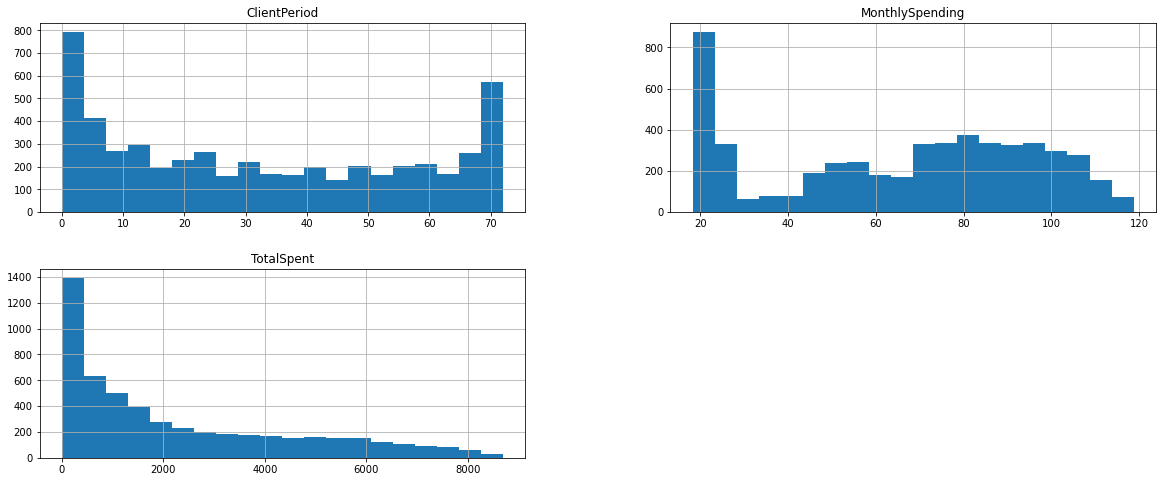

In [25]:
X_train.hist(column=num_cols, figsize=(20, 8), bins = 20)
None

C:\Users\90C5~1\AppData\Local\Temp/ipykernel_4704/2215684875.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[i].set_xticklabels(col_values.index, rotation = 30)
C:\Users\90C5~1\AppData\Local\Temp/ipykernel_4704/2215684875.py:11: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


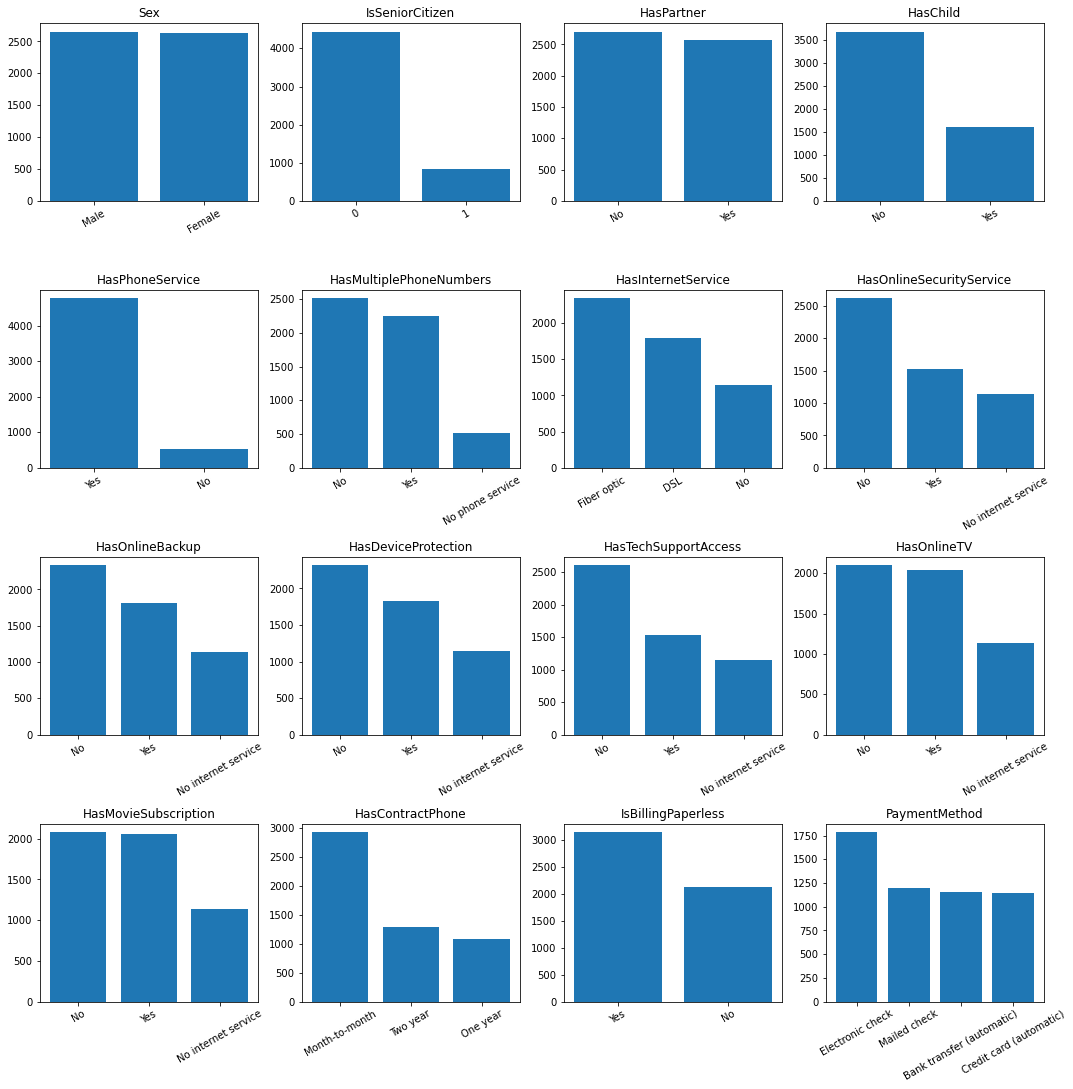

In [26]:
fig, ax = plt.subplots(4, 4, figsize=(18,18))
ax = ax.ravel()

for i, col in enumerate(cat_cols):
    ax[i].set_title(col)
    col_values = X_train[col].value_counts()
    ax[i].bar(col_values.index, col_values.values)
    ax[i].set_xticklabels(col_values.index, rotation = 30)
    
plt.subplots_adjust(hspace = 0.5)
fig.show()

<BarContainer object of 2 artists>

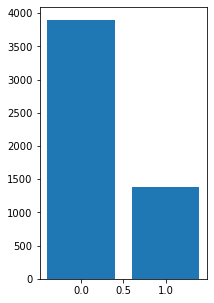

In [27]:
fig = plt.figure(figsize = (3, 5))
ax0 = fig.add_subplot(111)
target_values = y_train.value_counts()
ax0.bar(target_values.index, target_values.values)

In [28]:
target_values

0    3898
1    1384
Name: Churn, dtype: int64

Масштаб данных различен, для применения линейных моделей их данные нужно отмасштабировать.
Классы целевой переменной несбалансированные.
Следует использовать вероятностные модели (а не дерево).

## Применение линейных моделей

1) Обработайте данные для того, чтобы к ним можно было применить LogisticRegression. Т.е. отнормируйте числовые признаки, а категориальные закодируйте с помощью one-hot-encoding'а. 

2) С помощью кроссвалидации или разделения на train/valid выборку протестируйте разные значения гиперпараметра C и выберите лучший (можно тестировать С=100, 10, 1, 0.1, 0.01, 0.001) по метрике ROC-AUC. 

Если вы разделяете на train/valid, то используйте LogisticRegressionCV. Он сам при вызове .fit() подберет параметр С. (не забудьте передать scroing='roc_auc', чтобы при кроссвалидации сравнивались значения этой метрики, и refit=True, чтобы при потом модель обучилась на всем датасете с лучшим параметром C). 

In [31]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler, LabelEncoder, OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [34]:
preparation_pipeline = ColumnTransformer([
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(), cat_cols)
    ])

pipeline = Pipeline([
        ("preparation", preparation_pipeline),
        ("linear", LogisticRegression(solver = 'liblinear', random_state=42))
    ])

In [36]:
pipeline.get_params()

{'memory': None,
 'steps': [('preparation',
   ColumnTransformer(transformers=[('num', StandardScaler(),
                                    ['ClientPeriod', 'MonthlySpending',
                                     'TotalSpent']),
                                   ('cat', OneHotEncoder(),
                                    ['Sex', 'IsSeniorCitizen', 'HasPartner',
                                     'HasChild', 'HasPhoneService',
                                     'HasMultiplePhoneNumbers',
                                     'HasInternetService',
                                     'HasOnlineSecurityService', 'HasOnlineBackup',
                                     'HasDeviceProtection', 'HasTechSupportAccess',
                                     'HasOnlineTV', 'HasMovieSubscription',
                                     'HasContractPhone', 'IsBillingPaperless',
                                     'PaymentMethod'])])),
  ('linear', LogisticRegression(random_state=42, solver='lib

Две регуляризации: Ридж и Лассо.

In [38]:
C_values = [150, 100, 10, 1, 0.1, 0.01, 0.001]

param_grid = [
        {'linear__penalty':['l1', 'l2'],
         'linear__C':C_values
         }
    ]

Grid Search Cross Validation

In [39]:
grid_search = GridSearchCV(full_pipeline, 
                          param_grid, 
                          scoring='roc_auc', 
                          verbose=4)

In [40]:
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 14 candidates, totalling 70 fits
[CV 1/5] END .linear__C=150, linear__penalty=l1;, score=0.862 total time=   0.5s
[CV 2/5] END .linear__C=150, linear__penalty=l1;, score=0.837 total time=   0.5s
[CV 3/5] END .linear__C=150, linear__penalty=l1;, score=0.835 total time=   0.5s
[CV 4/5] END .linear__C=150, linear__penalty=l1;, score=0.856 total time=   0.5s
[CV 5/5] END .linear__C=150, linear__penalty=l1;, score=0.836 total time=   0.5s
[CV 1/5] END .linear__C=150, linear__penalty=l2;, score=0.862 total time=   0.4s
[CV 2/5] END .linear__C=150, linear__penalty=l2;, score=0.837 total time=   0.0s
[CV 3/5] END .linear__C=150, linear__penalty=l2;, score=0.835 total time=   0.0s
[CV 4/5] END .linear__C=150, linear__penalty=l2;, score=0.856 total time=   0.0s
[CV 5/5] END .linear__C=150, linear__penalty=l2;, score=0.836 total time=   0.0s
[CV 1/5] END .linear__C=100, linear__penalty=l1;, score=0.862 total time=   0.3s
[CV 2/5] END .linear__C=100, linear__penalty=l1;

GridSearchCV(estimator=Pipeline(steps=[('preparation',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['ClientPeriod',
                                                                          'MonthlySpending',
                                                                          'TotalSpent']),
                                                                        ('cat',
                                                                         OneHotEncoder(),
                                                                         ['Sex',
                                                                          'IsSeniorCitizen',
                                                                          'HasPartner',
                                                                     

In [41]:
grid_search.best_params_

{'linear__C': 150, 'linear__penalty': 'l1'}

In [42]:
grid_search.best_score_

0.8451260177188173

In [43]:
grid_search.best_estimator_

Pipeline(steps=[('preparation',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['ClientPeriod',
                                                   'MonthlySpending',
                                                   'TotalSpent']),
                                                 ('cat', OneHotEncoder(),
                                                  ['Sex', 'IsSeniorCitizen',
                                                   'HasPartner', 'HasChild',
                                                   'HasPhoneService',
                                                   'HasMultiplePhoneNumbers',
                                                   'HasInternetService',
                                                   'HasOnlineSecurityService',
                                                   'HasOnlineBackup',
                                                   'HasDeviceProtection',
                 

In [62]:
best_pipeline = grid_search.best_estimator_
predictions = best_pipeline.predict_proba(X_test)

submission = pd.read_csv('submission.csv', index_col=0)
submission['Churn'] = predictions[:, 1]
submission.to_csv('my_submission.csv')

ValueError: could not convert string to float: ''

Выпишите какое лучшее качество и с какими параметрами вам удалось получить

### Вывод:

Лучший roc_auc_score для логистической регрессии на валидационной выборке равен 0.84513 и получен при следующих параметрах: C=150,
penalty='l1',
solver='liblinear'.

Мой счёт на Кагле: 0.84583. Модель не переобучалась, т.к. счёт близок к счёту на обучащющей выборке.

## Применение градиентного бустинга (2 балла)

Если вы хотите получить баллы за точный ответ, то стоит попробовать градиентный бустинг. Часто градиентный бустинг с параметрами по умолчанию даст вам 80% результата за 0% усилий.

Мы будем использовать catboost, поэтому нам не надо кодировать категориальные признаки. catboost сделает это сам (в .fit() надо передать cat_features=cat_cols). А численные признаки нормировать для моделей, основанных на деревьях не нужно.

1) Разделите выборку на train/valid. Протестируйте catboost cо стандартными параметрами.

2) Протестируйте разные занчения параметроа количества деревьев и learning_rate'а и выберите лучшую по метрике ROC-AUC комбинацию.

In [46]:
from catboost import CatBoostClassifier
from catboost import Pool, cv
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

In [47]:
feature_names = list(X_train.columns)

In [48]:
X_train_cb, X_test_cb, y_train_cb, y_test_cb = train_test_split(X_train.values, y_train.values, 
                                                       train_size=0.8, 
                                                       random_state=42)

In [49]:
catboost_train_splitted = Pool(data=X_train_cb,
                               label=y_train_cb,
                               cat_features=cat_cols,
                               feature_names=feature_names)

In [50]:
boosting_model = CatBoostClassifier(loss_function='Logloss', 
                                    random_state=42,
                                    verbose=False,
                                    eval_metric='AUC',
                                    custom_metric='AUC:hints=skip_train~false')

boosting_model.fit(catboost_train_splitted)

y_train_splitted_predicted = boosting_model.predict_proba(X_train_cb)[:, 1]
y_test_splitted_predicted = boosting_model.predict_proba(X_test_cb)[:, 1]

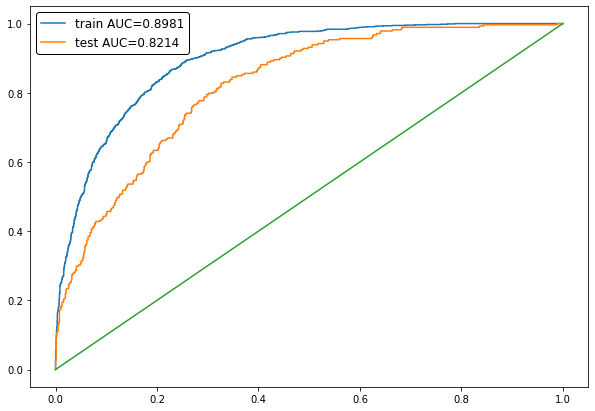

In [51]:
train_auc = roc_auc_score(y_train_cb, y_train_splitted_predicted)
test_auc = roc_auc_score(y_test_cb, y_test_splitted_predicted)

plt.figure(figsize=(10,7))
plt.plot(*roc_curve(y_train_cb, y_train_splitted_predicted)[:2], label='train AUC={:.4f}'.format(train_auc))
plt.plot(*roc_curve(y_test_cb, y_test_splitted_predicted)[:2], label='test AUC={:.4f}'.format(test_auc))
legend_box = plt.legend(fontsize='large', framealpha=1).get_frame()
legend_box.set_facecolor("white")
legend_box.set_edgecolor("black")
plt.plot(np.linspace(0,1,100), np.linspace(0,1,100))
plt.show()

Катбуст с параметрами по умлочанию даёт результат хуже чем LogisticRegression.

In [52]:
catboost_train_dataset = Pool(data=X_train,
                              label=y_train,
                              cat_features=cat_cols,
                              feature_names=feature_names)

In [53]:
searching_model = CatBoostClassifier(loss_function='Logloss', 
                                    random_state=42,
                                    eval_metric='AUC:hints=skip_train~false')

grid = {"iterations": [100, 200, 300],
        "learning_rate":[0.03, 0.1, 0.15, 0.2, 0.3],
        "grow_policy":['Depthwise'],
        "min_data_in_leaf":[20, 30, 50, 100, 200]}

grid_search_result = searching_model.grid_search(grid,
                                                 X=catboost_train_dataset, 
                                                 verbose=False,
                                                 plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8029729	test: 0.8200996	best: 0.8200996 (0)	total: 95.3ms	remaining: 9.43s
1:	learn: 0.8324393	test: 0.8522178	best: 0.8522178 (1)	total: 119ms	remaining: 5.84s
2:	learn: 0.8354240	test: 0.8564690	best: 0.8564690 (2)	total: 150ms	remaining: 4.86s
3:	learn: 0.8365261	test: 0.8611095	best: 0.8611095 (3)	total: 176ms	remaining: 4.22s
4:	learn: 0.8369916	test: 0.8617400	best: 0.8617400 (4)	total: 200ms	remaining: 3.79s
5:	learn: 0.8372196	test: 0.8621389	best: 0.8621389 (5)	total: 229ms	remaining: 3.59s
6:	learn: 0.8391888	test: 0.8635408	best: 0.8635408 (6)	total: 268ms	remaining: 3.56s
7:	learn: 0.8392186	test: 0.8632065	best: 0.8635408 (6)	total: 302ms	remaining: 3.48s
8:	learn: 0.8395878	test: 0.8628673	best: 0.8635408 (6)	total: 325ms	remaining: 3.28s
9:	learn: 0.8398431	test: 0.8632303	best: 0.8635408 (6)	total: 348ms	remaining: 3.13s
10:	learn: 0.8407594	test: 0.8644269	best: 0.8644269 (10)	total: 371ms	remaining: 3s
11:	learn: 0.8423940	test: 0.8656043	best: 0.8656043 (

96:	learn: 0.8643539	test: 0.8717399	best: 0.8717925 (74)	total: 2.42s	remaining: 74.8ms
97:	learn: 0.8646653	test: 0.8718211	best: 0.8718211 (97)	total: 2.44s	remaining: 49.8ms
98:	learn: 0.8647140	test: 0.8718402	best: 0.8718402 (98)	total: 2.46s	remaining: 24.9ms
99:	learn: 0.8647853	test: 0.8718976	best: 0.8718976 (99)	total: 2.48s	remaining: 0us

bestTest = 0.8718975696
bestIteration = 99

0:	learn: 0.8029729	test: 0.8200996	best: 0.8200996 (0)	total: 33.5ms	remaining: 3.32s
1:	learn: 0.8330459	test: 0.8546849	best: 0.8546849 (1)	total: 58.2ms	remaining: 2.85s
2:	learn: 0.8346523	test: 0.8570876	best: 0.8570876 (2)	total: 83.2ms	remaining: 2.69s
3:	learn: 0.8382208	test: 0.8596240	best: 0.8596240 (3)	total: 115ms	remaining: 2.77s
4:	learn: 0.8423479	test: 0.8637964	best: 0.8637964 (4)	total: 150ms	remaining: 2.85s
5:	learn: 0.8417969	test: 0.8647326	best: 0.8647326 (5)	total: 175ms	remaining: 2.74s
6:	learn: 0.8437969	test: 0.8652795	best: 0.8652795 (6)	total: 201ms	remaining: 2.6

94:	learn: 0.8887330	test: 0.8654324	best: 0.8707273 (34)	total: 2.01s	remaining: 106ms
95:	learn: 0.8892653	test: 0.8654181	best: 0.8707273 (34)	total: 2.03s	remaining: 84.5ms
96:	learn: 0.8898027	test: 0.8656521	best: 0.8707273 (34)	total: 2.05s	remaining: 63.3ms
97:	learn: 0.8903735	test: 0.8656282	best: 0.8707273 (34)	total: 2.06s	remaining: 42.1ms
98:	learn: 0.8910628	test: 0.8656569	best: 0.8707273 (34)	total: 2.08s	remaining: 21ms
99:	learn: 0.8916480	test: 0.8657524	best: 0.8707273 (34)	total: 2.1s	remaining: 0us

bestTest = 0.8707272918
bestIteration = 34

0:	learn: 0.8029729	test: 0.8200996	best: 0.8200996 (0)	total: 24.9ms	remaining: 2.46s
1:	learn: 0.8332370	test: 0.8550718	best: 0.8550718 (1)	total: 49.4ms	remaining: 2.42s
2:	learn: 0.8361913	test: 0.8579044	best: 0.8579044 (2)	total: 74.9ms	remaining: 2.42s
3:	learn: 0.8397413	test: 0.8589433	best: 0.8589433 (3)	total: 96ms	remaining: 2.3s
4:	learn: 0.8433361	test: 0.8613173	best: 0.8613173 (4)	total: 117ms	remaining: 2.2

97:	learn: 0.9166365	test: 0.8581337	best: 0.8717184 (12)	total: 1.78s	remaining: 36.3ms
98:	learn: 0.9168297	test: 0.8580763	best: 0.8717184 (12)	total: 1.79s	remaining: 18.1ms
99:	learn: 0.9173071	test: 0.8579856	best: 0.8717184 (12)	total: 1.81s	remaining: 0us

bestTest = 0.8717184455
bestIteration = 12

0:	learn: 0.8029729	test: 0.8200996	best: 0.8200996 (0)	total: 24.5ms	remaining: 2.43s
1:	learn: 0.8338105	test: 0.8551507	best: 0.8551507 (1)	total: 44.5ms	remaining: 2.18s
2:	learn: 0.8395753	test: 0.8590054	best: 0.8590054 (2)	total: 64.5ms	remaining: 2.08s
3:	learn: 0.8429686	test: 0.8625759	best: 0.8625759 (3)	total: 84.5ms	remaining: 2.03s
4:	learn: 0.8473325	test: 0.8666528	best: 0.8666528 (4)	total: 106ms	remaining: 2.02s
5:	learn: 0.8494262	test: 0.8676631	best: 0.8676631 (5)	total: 126ms	remaining: 1.98s
6:	learn: 0.8511136	test: 0.8670779	best: 0.8676631 (5)	total: 151ms	remaining: 2s
7:	learn: 0.8530852	test: 0.8682697	best: 0.8682697 (7)	total: 171ms	remaining: 1.97s
8:

91:	learn: 0.9318355	test: 0.8565884	best: 0.8713363 (12)	total: 1.67s	remaining: 145ms
92:	learn: 0.9319861	test: 0.8566410	best: 0.8713363 (12)	total: 1.69s	remaining: 127ms
93:	learn: 0.9324779	test: 0.8562923	best: 0.8713363 (12)	total: 1.7s	remaining: 109ms
94:	learn: 0.9325006	test: 0.8562923	best: 0.8713363 (12)	total: 1.72s	remaining: 90.3ms
95:	learn: 0.9325861	test: 0.8562923	best: 0.8713363 (12)	total: 1.73s	remaining: 72.1ms
96:	learn: 0.9334663	test: 0.8558433	best: 0.8713363 (12)	total: 1.75s	remaining: 54.1ms
97:	learn: 0.9337352	test: 0.8554564	best: 0.8713363 (12)	total: 1.76s	remaining: 36ms
98:	learn: 0.9348406	test: 0.8547351	best: 0.8713363 (12)	total: 1.78s	remaining: 18ms
99:	learn: 0.9354530	test: 0.8549023	best: 0.8713363 (12)	total: 1.8s	remaining: 0us

bestTest = 0.871336314
bestIteration = 12

0:	learn: 0.8029729	test: 0.8200996	best: 0.8200996 (0)	total: 24.4ms	remaining: 2.41s
1:	learn: 0.8344342	test: 0.8548115	best: 0.8548115 (1)	total: 46ms	remaining: 2

85:	learn: 0.9506113	test: 0.8392397	best: 0.8687139 (8)	total: 1.56s	remaining: 255ms
86:	learn: 0.9515931	test: 0.8392683	best: 0.8687139 (8)	total: 1.58s	remaining: 237ms
87:	learn: 0.9521423	test: 0.8392110	best: 0.8687139 (8)	total: 1.6s	remaining: 218ms
88:	learn: 0.9524126	test: 0.8395501	best: 0.8687139 (8)	total: 1.62s	remaining: 200ms
89:	learn: 0.9525779	test: 0.8393973	best: 0.8687139 (8)	total: 1.63s	remaining: 181ms
90:	learn: 0.9534245	test: 0.8400660	best: 0.8687139 (8)	total: 1.65s	remaining: 163ms
91:	learn: 0.9553244	test: 0.8396122	best: 0.8687139 (8)	total: 1.67s	remaining: 145ms
92:	learn: 0.9563509	test: 0.8397555	best: 0.8687139 (8)	total: 1.69s	remaining: 127ms
93:	learn: 0.9566730	test: 0.8398415	best: 0.8687139 (8)	total: 1.7s	remaining: 109ms
94:	learn: 0.9578698	test: 0.8394833	best: 0.8687139 (8)	total: 1.72s	remaining: 90.6ms
95:	learn: 0.9586818	test: 0.8393686	best: 0.8687139 (8)	total: 1.74s	remaining: 72.7ms
96:	learn: 0.9590007	test: 0.8398224	best: 

79:	learn: 0.8612562	test: 0.8716444	best: 0.8717925 (74)	total: 1.65s	remaining: 2.48s
80:	learn: 0.8614064	test: 0.8715345	best: 0.8717925 (74)	total: 1.67s	remaining: 2.45s
81:	learn: 0.8616882	test: 0.8715059	best: 0.8717925 (74)	total: 1.69s	remaining: 2.43s
82:	learn: 0.8618599	test: 0.8715393	best: 0.8717925 (74)	total: 1.71s	remaining: 2.41s
83:	learn: 0.8618438	test: 0.8715680	best: 0.8717925 (74)	total: 1.72s	remaining: 2.38s
84:	learn: 0.8620549	test: 0.8716444	best: 0.8717925 (74)	total: 1.74s	remaining: 2.36s
85:	learn: 0.8621420	test: 0.8716778	best: 0.8717925 (74)	total: 1.76s	remaining: 2.33s
86:	learn: 0.8623252	test: 0.8717399	best: 0.8717925 (74)	total: 1.78s	remaining: 2.31s
87:	learn: 0.8625687	test: 0.8717399	best: 0.8717925 (74)	total: 1.79s	remaining: 2.28s
88:	learn: 0.8626326	test: 0.8717161	best: 0.8717925 (74)	total: 1.81s	remaining: 2.26s
89:	learn: 0.8630001	test: 0.8716396	best: 0.8717925 (74)	total: 1.83s	remaining: 2.24s
90:	learn: 0.8632203	test: 0.871

172:	learn: 0.8727047	test: 0.8711572	best: 0.8720648 (111)	total: 3.33s	remaining: 519ms
173:	learn: 0.8728370	test: 0.8710951	best: 0.8720648 (111)	total: 3.34s	remaining: 500ms
174:	learn: 0.8729497	test: 0.8709613	best: 0.8720648 (111)	total: 3.36s	remaining: 480ms
175:	learn: 0.8730058	test: 0.8709279	best: 0.8720648 (111)	total: 3.37s	remaining: 460ms
176:	learn: 0.8730927	test: 0.8708849	best: 0.8720648 (111)	total: 3.39s	remaining: 440ms
177:	learn: 0.8732580	test: 0.8708945	best: 0.8720648 (111)	total: 3.41s	remaining: 421ms
178:	learn: 0.8733034	test: 0.8709040	best: 0.8720648 (111)	total: 3.42s	remaining: 402ms
179:	learn: 0.8733238	test: 0.8708801	best: 0.8720648 (111)	total: 3.44s	remaining: 382ms
180:	learn: 0.8733621	test: 0.8708467	best: 0.8720648 (111)	total: 3.46s	remaining: 363ms
181:	learn: 0.8733897	test: 0.8708467	best: 0.8720648 (111)	total: 3.47s	remaining: 343ms
182:	learn: 0.8735122	test: 0.8709375	best: 0.8720648 (111)	total: 3.49s	remaining: 324ms
183:	learn

67:	learn: 0.8764836	test: 0.8689695	best: 0.8707273 (34)	total: 1.44s	remaining: 2.8s
68:	learn: 0.8765032	test: 0.8689695	best: 0.8707273 (34)	total: 1.46s	remaining: 2.76s
69:	learn: 0.8772730	test: 0.8686303	best: 0.8707273 (34)	total: 1.48s	remaining: 2.74s
70:	learn: 0.8779798	test: 0.8682482	best: 0.8707273 (34)	total: 1.49s	remaining: 2.72s
71:	learn: 0.8793324	test: 0.8681145	best: 0.8707273 (34)	total: 1.52s	remaining: 2.7s
72:	learn: 0.8793350	test: 0.8681145	best: 0.8707273 (34)	total: 1.53s	remaining: 2.67s
73:	learn: 0.8795070	test: 0.8681097	best: 0.8707273 (34)	total: 1.55s	remaining: 2.64s
74:	learn: 0.8794610	test: 0.8682506	best: 0.8707273 (34)	total: 1.56s	remaining: 2.6s
75:	learn: 0.8796986	test: 0.8683629	best: 0.8707273 (34)	total: 1.58s	remaining: 2.58s
76:	learn: 0.8797892	test: 0.8682864	best: 0.8707273 (34)	total: 1.59s	remaining: 2.55s
77:	learn: 0.8798188	test: 0.8682864	best: 0.8707273 (34)	total: 1.61s	remaining: 2.52s
78:	learn: 0.8802075	test: 0.868033

160:	learn: 0.9257576	test: 0.8601231	best: 0.8707273 (34)	total: 3.11s	remaining: 753ms
161:	learn: 0.9260312	test: 0.8599655	best: 0.8707273 (34)	total: 3.13s	remaining: 734ms
162:	learn: 0.9264711	test: 0.8598365	best: 0.8707273 (34)	total: 3.15s	remaining: 715ms
163:	learn: 0.9264749	test: 0.8598365	best: 0.8707273 (34)	total: 3.17s	remaining: 695ms
164:	learn: 0.9265585	test: 0.8597888	best: 0.8707273 (34)	total: 3.18s	remaining: 675ms
165:	learn: 0.9268691	test: 0.8593063	best: 0.8707273 (34)	total: 3.2s	remaining: 655ms
166:	learn: 0.9277145	test: 0.8593445	best: 0.8707273 (34)	total: 3.22s	remaining: 636ms
167:	learn: 0.9280282	test: 0.8593589	best: 0.8707273 (34)	total: 3.24s	remaining: 617ms
168:	learn: 0.9284363	test: 0.8596694	best: 0.8707273 (34)	total: 3.26s	remaining: 598ms
169:	learn: 0.9286778	test: 0.8596311	best: 0.8707273 (34)	total: 3.28s	remaining: 579ms
170:	learn: 0.9292363	test: 0.8592825	best: 0.8707273 (34)	total: 3.3s	remaining: 560ms
171:	learn: 0.9301561	t

55:	learn: 0.8814969	test: 0.8653607	best: 0.8717184 (12)	total: 1.57s	remaining: 4.03s
56:	learn: 0.8826004	test: 0.8642621	best: 0.8717184 (12)	total: 1.59s	remaining: 4s
57:	learn: 0.8828753	test: 0.8644651	best: 0.8717184 (12)	total: 1.61s	remaining: 3.96s
58:	learn: 0.8833668	test: 0.8637964	best: 0.8717184 (12)	total: 1.65s	remaining: 3.95s
59:	learn: 0.8847685	test: 0.8627981	best: 0.8717184 (12)	total: 1.68s	remaining: 3.92s
60:	learn: 0.8851481	test: 0.8622440	best: 0.8717184 (12)	total: 1.7s	remaining: 3.88s
61:	learn: 0.8853274	test: 0.8620529	best: 0.8717184 (12)	total: 1.73s	remaining: 3.84s
62:	learn: 0.8860496	test: 0.8623443	best: 0.8717184 (12)	total: 1.76s	remaining: 3.83s
63:	learn: 0.8868326	test: 0.8624398	best: 0.8717184 (12)	total: 1.78s	remaining: 3.79s
64:	learn: 0.8894212	test: 0.8615084	best: 0.8717184 (12)	total: 1.81s	remaining: 3.77s
65:	learn: 0.8897017	test: 0.8614033	best: 0.8717184 (12)	total: 1.83s	remaining: 3.72s
66:	learn: 0.8910526	test: 0.8608779

151:	learn: 0.9488551	test: 0.8485159	best: 0.8717184 (12)	total: 3.89s	remaining: 1.23s
152:	learn: 0.9489813	test: 0.8486305	best: 0.8717184 (12)	total: 3.91s	remaining: 1.2s
153:	learn: 0.9494998	test: 0.8484825	best: 0.8717184 (12)	total: 3.93s	remaining: 1.17s
154:	learn: 0.9501652	test: 0.8482771	best: 0.8717184 (12)	total: 3.95s	remaining: 1.15s
155:	learn: 0.9504076	test: 0.8482389	best: 0.8717184 (12)	total: 3.97s	remaining: 1.12s
156:	learn: 0.9507800	test: 0.8482341	best: 0.8717184 (12)	total: 3.99s	remaining: 1.09s
157:	learn: 0.9513885	test: 0.8484251	best: 0.8717184 (12)	total: 4.01s	remaining: 1.07s
158:	learn: 0.9521111	test: 0.8487261	best: 0.8717184 (12)	total: 4.04s	remaining: 1.04s
159:	learn: 0.9523035	test: 0.8485637	best: 0.8717184 (12)	total: 4.07s	remaining: 1.02s
160:	learn: 0.9526376	test: 0.8484036	best: 0.8717184 (12)	total: 4.09s	remaining: 992ms
161:	learn: 0.9527986	test: 0.8484323	best: 0.8717184 (12)	total: 4.11s	remaining: 965ms
162:	learn: 0.9531423	

47:	learn: 0.8831910	test: 0.8673574	best: 0.8713363 (12)	total: 1.14s	remaining: 3.6s
48:	learn: 0.8832488	test: 0.8673000	best: 0.8713363 (12)	total: 1.16s	remaining: 3.57s
49:	learn: 0.8867821	test: 0.8666934	best: 0.8713363 (12)	total: 1.18s	remaining: 3.54s
50:	learn: 0.8869285	test: 0.8666934	best: 0.8713363 (12)	total: 1.2s	remaining: 3.51s
51:	learn: 0.8869397	test: 0.8666934	best: 0.8713363 (12)	total: 1.22s	remaining: 3.48s
52:	learn: 0.8885251	test: 0.8666313	best: 0.8713363 (12)	total: 1.25s	remaining: 3.46s
53:	learn: 0.8891832	test: 0.8664450	best: 0.8713363 (12)	total: 1.27s	remaining: 3.44s
54:	learn: 0.8892189	test: 0.8664450	best: 0.8713363 (12)	total: 1.29s	remaining: 3.41s
55:	learn: 0.8895859	test: 0.8662301	best: 0.8713363 (12)	total: 1.31s	remaining: 3.38s
56:	learn: 0.8924528	test: 0.8650096	best: 0.8713363 (12)	total: 1.35s	remaining: 3.38s
57:	learn: 0.8932554	test: 0.8645487	best: 0.8713363 (12)	total: 1.37s	remaining: 3.36s
58:	learn: 0.8939813	test: 0.86462

143:	learn: 0.9612496	test: 0.8441238	best: 0.8713363 (12)	total: 3.02s	remaining: 1.17s
144:	learn: 0.9620979	test: 0.8431446	best: 0.8713363 (12)	total: 3.04s	remaining: 1.15s
145:	learn: 0.9636553	test: 0.8428962	best: 0.8713363 (12)	total: 3.06s	remaining: 1.13s
146:	learn: 0.9646137	test: 0.8420889	best: 0.8713363 (12)	total: 3.08s	remaining: 1.11s
147:	learn: 0.9647934	test: 0.8420220	best: 0.8713363 (12)	total: 3.1s	remaining: 1.09s
148:	learn: 0.9649291	test: 0.8420316	best: 0.8713363 (12)	total: 3.13s	remaining: 1.07s
149:	learn: 0.9650283	test: 0.8420698	best: 0.8713363 (12)	total: 3.14s	remaining: 1.05s
150:	learn: 0.9660259	test: 0.8416399	best: 0.8713363 (12)	total: 3.17s	remaining: 1.03s
151:	learn: 0.9662936	test: 0.8412482	best: 0.8713363 (12)	total: 3.19s	remaining: 1.01s
152:	learn: 0.9664821	test: 0.8414106	best: 0.8713363 (12)	total: 3.21s	remaining: 986ms
153:	learn: 0.9665252	test: 0.8414106	best: 0.8713363 (12)	total: 3.23s	remaining: 965ms
154:	learn: 0.9673019	

45:	learn: 0.9036807	test: 0.8557382	best: 0.8687139 (8)	total: 904ms	remaining: 3.02s
46:	learn: 0.9045562	test: 0.8552701	best: 0.8687139 (8)	total: 925ms	remaining: 3.01s
47:	learn: 0.9062394	test: 0.8554587	best: 0.8687139 (8)	total: 943ms	remaining: 2.99s
48:	learn: 0.9064884	test: 0.8555901	best: 0.8687139 (8)	total: 961ms	remaining: 2.96s
49:	learn: 0.9075487	test: 0.8551650	best: 0.8687139 (8)	total: 978ms	remaining: 2.93s
50:	learn: 0.9076997	test: 0.8548593	best: 0.8687139 (8)	total: 996ms	remaining: 2.91s
51:	learn: 0.9089386	test: 0.8550695	best: 0.8687139 (8)	total: 1.01s	remaining: 2.88s
52:	learn: 0.9109853	test: 0.8541476	best: 0.8687139 (8)	total: 1.03s	remaining: 2.86s
53:	learn: 0.9130081	test: 0.8529271	best: 0.8687139 (8)	total: 1.05s	remaining: 2.83s
54:	learn: 0.9140088	test: 0.8522488	best: 0.8687139 (8)	total: 1.06s	remaining: 2.8s
55:	learn: 0.9164266	test: 0.8522035	best: 0.8687139 (8)	total: 1.08s	remaining: 2.78s
56:	learn: 0.9172596	test: 0.8525163	best: 0

144:	learn: 0.9803898	test: 0.8302213	best: 0.8687139 (8)	total: 2.75s	remaining: 1.04s
145:	learn: 0.9805131	test: 0.8303599	best: 0.8687139 (8)	total: 2.77s	remaining: 1.02s
146:	learn: 0.9805534	test: 0.8304220	best: 0.8687139 (8)	total: 2.79s	remaining: 1s
147:	learn: 0.9809206	test: 0.8300589	best: 0.8687139 (8)	total: 2.8s	remaining: 985ms
148:	learn: 0.9812338	test: 0.8303264	best: 0.8687139 (8)	total: 2.82s	remaining: 966ms
149:	learn: 0.9819595	test: 0.8307372	best: 0.8687139 (8)	total: 2.84s	remaining: 946ms
150:	learn: 0.9823434	test: 0.8300160	best: 0.8687139 (8)	total: 2.85s	remaining: 926ms
151:	learn: 0.9826051	test: 0.8297102	best: 0.8687139 (8)	total: 2.87s	remaining: 907ms
152:	learn: 0.9826094	test: 0.8296529	best: 0.8687139 (8)	total: 2.89s	remaining: 887ms
153:	learn: 0.9826451	test: 0.8296004	best: 0.8687139 (8)	total: 2.9s	remaining: 867ms
154:	learn: 0.9827983	test: 0.8295001	best: 0.8687139 (8)	total: 2.92s	remaining: 847ms
155:	learn: 0.9831747	test: 0.8299252

37:	learn: 0.8509620	test: 0.8696621	best: 0.8696621 (37)	total: 840ms	remaining: 5.79s
38:	learn: 0.8511550	test: 0.8696621	best: 0.8696621 (37)	total: 861ms	remaining: 5.76s
39:	learn: 0.8516555	test: 0.8697433	best: 0.8697433 (39)	total: 882ms	remaining: 5.73s
40:	learn: 0.8518152	test: 0.8696573	best: 0.8697433 (39)	total: 899ms	remaining: 5.68s
41:	learn: 0.8521473	test: 0.8698436	best: 0.8698436 (41)	total: 919ms	remaining: 5.64s
42:	learn: 0.8521973	test: 0.8700777	best: 0.8700777 (42)	total: 942ms	remaining: 5.63s
43:	learn: 0.8525676	test: 0.8702759	best: 0.8702759 (43)	total: 967ms	remaining: 5.63s
44:	learn: 0.8526820	test: 0.8704096	best: 0.8704096 (44)	total: 989ms	remaining: 5.6s
45:	learn: 0.8529032	test: 0.8703953	best: 0.8704096 (44)	total: 1.01s	remaining: 5.58s
46:	learn: 0.8531745	test: 0.8704574	best: 0.8704574 (46)	total: 1.03s	remaining: 5.54s
47:	learn: 0.8533542	test: 0.8705673	best: 0.8705673 (47)	total: 1.05s	remaining: 5.54s
48:	learn: 0.8534440	test: 0.8704

136:	learn: 0.8696952	test: 0.8713578	best: 0.8720648 (111)	total: 2.96s	remaining: 3.52s
137:	learn: 0.8697771	test: 0.8713244	best: 0.8720648 (111)	total: 2.98s	remaining: 3.5s
138:	learn: 0.8698999	test: 0.8710760	best: 0.8720648 (111)	total: 3.01s	remaining: 3.48s
139:	learn: 0.8699643	test: 0.8711094	best: 0.8720648 (111)	total: 3.03s	remaining: 3.46s
140:	learn: 0.8701435	test: 0.8710330	best: 0.8720648 (111)	total: 3.05s	remaining: 3.44s
141:	learn: 0.8701377	test: 0.8710521	best: 0.8720648 (111)	total: 3.07s	remaining: 3.42s
142:	learn: 0.8702254	test: 0.8711046	best: 0.8720648 (111)	total: 3.09s	remaining: 3.39s
143:	learn: 0.8702844	test: 0.8712050	best: 0.8720648 (111)	total: 3.11s	remaining: 3.37s
144:	learn: 0.8704034	test: 0.8710330	best: 0.8720648 (111)	total: 3.13s	remaining: 3.35s
145:	learn: 0.8704457	test: 0.8710330	best: 0.8720648 (111)	total: 3.17s	remaining: 3.34s
146:	learn: 0.8704604	test: 0.8710282	best: 0.8720648 (111)	total: 3.19s	remaining: 3.33s
147:	learn:

230:	learn: 0.8776375	test: 0.8705219	best: 0.8720648 (111)	total: 5.19s	remaining: 1.55s
231:	learn: 0.8778223	test: 0.8705506	best: 0.8720648 (111)	total: 5.23s	remaining: 1.53s
232:	learn: 0.8778980	test: 0.8705410	best: 0.8720648 (111)	total: 5.27s	remaining: 1.51s
233:	learn: 0.8779727	test: 0.8704789	best: 0.8720648 (111)	total: 5.29s	remaining: 1.49s
234:	learn: 0.8779980	test: 0.8704455	best: 0.8720648 (111)	total: 5.31s	remaining: 1.47s
235:	learn: 0.8781105	test: 0.8704359	best: 0.8720648 (111)	total: 5.34s	remaining: 1.45s
236:	learn: 0.8783670	test: 0.8703069	best: 0.8720648 (111)	total: 5.36s	remaining: 1.42s
237:	learn: 0.8784251	test: 0.8702544	best: 0.8720648 (111)	total: 5.39s	remaining: 1.4s
238:	learn: 0.8784383	test: 0.8702592	best: 0.8720648 (111)	total: 5.41s	remaining: 1.38s
239:	learn: 0.8784774	test: 0.8702544	best: 0.8720648 (111)	total: 5.43s	remaining: 1.36s
240:	learn: 0.8785223	test: 0.8702496	best: 0.8720648 (111)	total: 5.44s	remaining: 1.33s
241:	learn:

24:	learn: 0.8613607	test: 0.8697146	best: 0.8697146 (24)	total: 477ms	remaining: 5.25s
25:	learn: 0.8613690	test: 0.8700538	best: 0.8700538 (25)	total: 494ms	remaining: 5.21s
26:	learn: 0.8617210	test: 0.8705506	best: 0.8705506 (26)	total: 510ms	remaining: 5.16s
27:	learn: 0.8627300	test: 0.8701350	best: 0.8705506 (26)	total: 526ms	remaining: 5.11s
28:	learn: 0.8631712	test: 0.8702066	best: 0.8705506 (26)	total: 543ms	remaining: 5.08s
29:	learn: 0.8634737	test: 0.8705553	best: 0.8705553 (29)	total: 559ms	remaining: 5.03s
30:	learn: 0.8643362	test: 0.8706891	best: 0.8706891 (30)	total: 578ms	remaining: 5.02s
31:	learn: 0.8647158	test: 0.8705959	best: 0.8706891 (30)	total: 596ms	remaining: 4.99s
32:	learn: 0.8649733	test: 0.8706437	best: 0.8706891 (30)	total: 613ms	remaining: 4.96s
33:	learn: 0.8656109	test: 0.8706795	best: 0.8706891 (30)	total: 629ms	remaining: 4.92s
34:	learn: 0.8659606	test: 0.8707273	best: 0.8707273 (34)	total: 646ms	remaining: 4.89s
35:	learn: 0.8666625	test: 0.870

125:	learn: 0.9100625	test: 0.8640089	best: 0.8707273 (34)	total: 2.19s	remaining: 3.02s
126:	learn: 0.9105244	test: 0.8634501	best: 0.8707273 (34)	total: 2.2s	remaining: 3s
127:	learn: 0.9109077	test: 0.8632733	best: 0.8707273 (34)	total: 2.22s	remaining: 2.98s
128:	learn: 0.9114821	test: 0.8631157	best: 0.8707273 (34)	total: 2.24s	remaining: 2.96s
129:	learn: 0.9122004	test: 0.8632208	best: 0.8707273 (34)	total: 2.25s	remaining: 2.95s
130:	learn: 0.9130094	test: 0.8630632	best: 0.8707273 (34)	total: 2.27s	remaining: 2.93s
131:	learn: 0.9133346	test: 0.8628434	best: 0.8707273 (34)	total: 2.29s	remaining: 2.91s
132:	learn: 0.9136869	test: 0.8630202	best: 0.8707273 (34)	total: 2.3s	remaining: 2.89s
133:	learn: 0.9142355	test: 0.8627813	best: 0.8707273 (34)	total: 2.32s	remaining: 2.88s
134:	learn: 0.9142591	test: 0.8627813	best: 0.8707273 (34)	total: 2.34s	remaining: 2.85s
135:	learn: 0.9147669	test: 0.8623992	best: 0.8707273 (34)	total: 2.35s	remaining: 2.84s
136:	learn: 0.9153015	test

223:	learn: 0.9468714	test: 0.8541858	best: 0.8707273 (34)	total: 3.88s	remaining: 1.32s
224:	learn: 0.9473096	test: 0.8544294	best: 0.8707273 (34)	total: 3.9s	remaining: 1.3s
225:	learn: 0.9477657	test: 0.8542526	best: 0.8707273 (34)	total: 3.94s	remaining: 1.29s
226:	learn: 0.9484498	test: 0.8542144	best: 0.8707273 (34)	total: 3.96s	remaining: 1.27s
227:	learn: 0.9489976	test: 0.8541953	best: 0.8707273 (34)	total: 3.98s	remaining: 1.26s
228:	learn: 0.9490456	test: 0.8541285	best: 0.8707273 (34)	total: 4.01s	remaining: 1.24s
229:	learn: 0.9491405	test: 0.8541046	best: 0.8707273 (34)	total: 4.03s	remaining: 1.23s
230:	learn: 0.9496259	test: 0.8544151	best: 0.8707273 (34)	total: 4.05s	remaining: 1.21s
231:	learn: 0.9498306	test: 0.8543577	best: 0.8707273 (34)	total: 4.07s	remaining: 1.19s
232:	learn: 0.9501852	test: 0.8546109	best: 0.8707273 (34)	total: 4.09s	remaining: 1.18s
233:	learn: 0.9502683	test: 0.8545488	best: 0.8707273 (34)	total: 4.11s	remaining: 1.16s
234:	learn: 0.9504650	t

23:	learn: 0.8672554	test: 0.8697266	best: 0.8717184 (12)	total: 495ms	remaining: 5.7s
24:	learn: 0.8674107	test: 0.8695188	best: 0.8717184 (12)	total: 514ms	remaining: 5.65s
25:	learn: 0.8686117	test: 0.8690841	best: 0.8717184 (12)	total: 538ms	remaining: 5.67s
26:	learn: 0.8687601	test: 0.8686853	best: 0.8717184 (12)	total: 583ms	remaining: 5.89s
27:	learn: 0.8692013	test: 0.8689337	best: 0.8717184 (12)	total: 609ms	remaining: 5.91s
28:	learn: 0.8692091	test: 0.8689575	best: 0.8717184 (12)	total: 629ms	remaining: 5.88s
29:	learn: 0.8694557	test: 0.8690674	best: 0.8717184 (12)	total: 653ms	remaining: 5.88s
30:	learn: 0.8695159	test: 0.8688572	best: 0.8717184 (12)	total: 673ms	remaining: 5.84s
31:	learn: 0.8697086	test: 0.8688238	best: 0.8717184 (12)	total: 699ms	remaining: 5.85s
32:	learn: 0.8698723	test: 0.8687426	best: 0.8717184 (12)	total: 719ms	remaining: 5.82s
33:	learn: 0.8702079	test: 0.8688525	best: 0.8717184 (12)	total: 762ms	remaining: 5.96s
34:	learn: 0.8705346	test: 0.8689

124:	learn: 0.9299438	test: 0.8532663	best: 0.8717184 (12)	total: 2.9s	remaining: 4.06s
125:	learn: 0.9305870	test: 0.8533116	best: 0.8717184 (12)	total: 2.92s	remaining: 4.04s
126:	learn: 0.9320291	test: 0.8531206	best: 0.8717184 (12)	total: 2.94s	remaining: 4.01s
127:	learn: 0.9323604	test: 0.8530680	best: 0.8717184 (12)	total: 2.97s	remaining: 3.99s
128:	learn: 0.9335563	test: 0.8524662	best: 0.8717184 (12)	total: 3s	remaining: 3.97s
129:	learn: 0.9344339	test: 0.8520458	best: 0.8717184 (12)	total: 3.03s	remaining: 3.96s
130:	learn: 0.9352612	test: 0.8518500	best: 0.8717184 (12)	total: 3.05s	remaining: 3.94s
131:	learn: 0.9352819	test: 0.8518500	best: 0.8717184 (12)	total: 3.07s	remaining: 3.91s
132:	learn: 0.9361015	test: 0.8514726	best: 0.8717184 (12)	total: 3.09s	remaining: 3.89s
133:	learn: 0.9364460	test: 0.8514679	best: 0.8717184 (12)	total: 3.12s	remaining: 3.86s
134:	learn: 0.9365555	test: 0.8514440	best: 0.8717184 (12)	total: 3.14s	remaining: 3.84s
135:	learn: 0.9371548	tes

222:	learn: 0.9725344	test: 0.8454636	best: 0.8717184 (12)	total: 4.75s	remaining: 1.64s
223:	learn: 0.9728001	test: 0.8449621	best: 0.8717184 (12)	total: 4.77s	remaining: 1.62s
224:	learn: 0.9729128	test: 0.8446373	best: 0.8717184 (12)	total: 4.79s	remaining: 1.59s
225:	learn: 0.9729249	test: 0.8446373	best: 0.8717184 (12)	total: 4.8s	remaining: 1.57s
226:	learn: 0.9729542	test: 0.8445990	best: 0.8717184 (12)	total: 4.82s	remaining: 1.55s
227:	learn: 0.9730249	test: 0.8446516	best: 0.8717184 (12)	total: 4.83s	remaining: 1.52s
228:	learn: 0.9730304	test: 0.8446659	best: 0.8717184 (12)	total: 4.84s	remaining: 1.5s
229:	learn: 0.9731932	test: 0.8447806	best: 0.8717184 (12)	total: 4.86s	remaining: 1.48s
230:	learn: 0.9734985	test: 0.8448665	best: 0.8717184 (12)	total: 4.88s	remaining: 1.46s
231:	learn: 0.9735698	test: 0.8448331	best: 0.8717184 (12)	total: 4.89s	remaining: 1.43s
232:	learn: 0.9743218	test: 0.8446755	best: 0.8717184 (12)	total: 4.91s	remaining: 1.41s
233:	learn: 0.9744337	t

19:	learn: 0.8645523	test: 0.8704096	best: 0.8713363 (12)	total: 531ms	remaining: 7.43s
20:	learn: 0.8651005	test: 0.8701350	best: 0.8713363 (12)	total: 547ms	remaining: 7.26s
21:	learn: 0.8657081	test: 0.8701613	best: 0.8713363 (12)	total: 563ms	remaining: 7.12s
22:	learn: 0.8661184	test: 0.8703619	best: 0.8713363 (12)	total: 583ms	remaining: 7.02s
23:	learn: 0.8662310	test: 0.8704574	best: 0.8713363 (12)	total: 604ms	remaining: 6.94s
24:	learn: 0.8666639	test: 0.8701995	best: 0.8713363 (12)	total: 631ms	remaining: 6.94s
25:	learn: 0.8674918	test: 0.8695498	best: 0.8713363 (12)	total: 654ms	remaining: 6.89s
26:	learn: 0.8678208	test: 0.8699917	best: 0.8713363 (12)	total: 678ms	remaining: 6.86s
27:	learn: 0.8703564	test: 0.8708682	best: 0.8713363 (12)	total: 713ms	remaining: 6.92s
28:	learn: 0.8710394	test: 0.8709542	best: 0.8713363 (12)	total: 736ms	remaining: 6.87s
29:	learn: 0.8716276	test: 0.8707010	best: 0.8713363 (12)	total: 764ms	remaining: 6.88s
30:	learn: 0.8716813	test: 0.870

117:	learn: 0.9477991	test: 0.8483368	best: 0.8713363 (12)	total: 2.82s	remaining: 4.36s
118:	learn: 0.9479405	test: 0.8483368	best: 0.8713363 (12)	total: 2.85s	remaining: 4.33s
119:	learn: 0.9482108	test: 0.8482460	best: 0.8713363 (12)	total: 2.87s	remaining: 4.3s
120:	learn: 0.9485401	test: 0.8486281	best: 0.8713363 (12)	total: 2.89s	remaining: 4.27s
121:	learn: 0.9498393	test: 0.8480502	best: 0.8713363 (12)	total: 2.91s	remaining: 4.25s
122:	learn: 0.9501418	test: 0.8481696	best: 0.8713363 (12)	total: 2.94s	remaining: 4.22s
123:	learn: 0.9508791	test: 0.8479069	best: 0.8713363 (12)	total: 2.95s	remaining: 4.19s
124:	learn: 0.9512034	test: 0.8475247	best: 0.8713363 (12)	total: 2.97s	remaining: 4.16s
125:	learn: 0.9518427	test: 0.8470327	best: 0.8713363 (12)	total: 3s	remaining: 4.14s
126:	learn: 0.9521521	test: 0.8468130	best: 0.8713363 (12)	total: 3.01s	remaining: 4.11s
127:	learn: 0.9523728	test: 0.8468082	best: 0.8713363 (12)	total: 3.03s	remaining: 4.07s
128:	learn: 0.9535017	tes

216:	learn: 0.9851653	test: 0.8372024	best: 0.8713363 (12)	total: 4.7s	remaining: 1.8s
217:	learn: 0.9852755	test: 0.8369110	best: 0.8713363 (12)	total: 4.71s	remaining: 1.77s
218:	learn: 0.9854132	test: 0.8367677	best: 0.8713363 (12)	total: 4.73s	remaining: 1.75s
219:	learn: 0.9854946	test: 0.8366435	best: 0.8713363 (12)	total: 4.75s	remaining: 1.73s
220:	learn: 0.9855682	test: 0.8366435	best: 0.8713363 (12)	total: 4.76s	remaining: 1.7s
221:	learn: 0.9855878	test: 0.8366435	best: 0.8713363 (12)	total: 4.78s	remaining: 1.68s
222:	learn: 0.9858234	test: 0.8363378	best: 0.8713363 (12)	total: 4.79s	remaining: 1.66s
223:	learn: 0.9858645	test: 0.8359700	best: 0.8713363 (12)	total: 4.81s	remaining: 1.63s
224:	learn: 0.9858631	test: 0.8360178	best: 0.8713363 (12)	total: 4.83s	remaining: 1.61s
225:	learn: 0.9861944	test: 0.8353873	best: 0.8713363 (12)	total: 4.84s	remaining: 1.59s
226:	learn: 0.9862637	test: 0.8355067	best: 0.8713363 (12)	total: 4.86s	remaining: 1.56s
227:	learn: 0.9862918	te

12:	learn: 0.8666917	test: 0.8678518	best: 0.8687139 (8)	total: 273ms	remaining: 6.02s
13:	learn: 0.8683328	test: 0.8676774	best: 0.8687139 (8)	total: 291ms	remaining: 5.95s
14:	learn: 0.8686555	test: 0.8677849	best: 0.8687139 (8)	total: 309ms	remaining: 5.87s
15:	learn: 0.8688935	test: 0.8676846	best: 0.8687139 (8)	total: 324ms	remaining: 5.75s
16:	learn: 0.8693106	test: 0.8675890	best: 0.8687139 (8)	total: 343ms	remaining: 5.72s
17:	learn: 0.8702784	test: 0.8677705	best: 0.8687139 (8)	total: 361ms	remaining: 5.65s
18:	learn: 0.8705977	test: 0.8677849	best: 0.8687139 (8)	total: 378ms	remaining: 5.59s
19:	learn: 0.8715519	test: 0.8668248	best: 0.8687139 (8)	total: 407ms	remaining: 5.7s
20:	learn: 0.8725847	test: 0.8667937	best: 0.8687139 (8)	total: 429ms	remaining: 5.7s
21:	learn: 0.8729574	test: 0.8666982	best: 0.8687139 (8)	total: 447ms	remaining: 5.64s
22:	learn: 0.8743142	test: 0.8670564	best: 0.8687139 (8)	total: 467ms	remaining: 5.62s
23:	learn: 0.8758010	test: 0.8659745	best: 0.

111:	learn: 0.9664289	test: 0.8354470	best: 0.8687139 (8)	total: 2.13s	remaining: 3.58s
112:	learn: 0.9665010	test: 0.8352655	best: 0.8687139 (8)	total: 2.15s	remaining: 3.56s
113:	learn: 0.9668933	test: 0.8346971	best: 0.8687139 (8)	total: 2.17s	remaining: 3.53s
114:	learn: 0.9674792	test: 0.8345203	best: 0.8687139 (8)	total: 2.18s	remaining: 3.51s
115:	learn: 0.9680827	test: 0.8346159	best: 0.8687139 (8)	total: 2.2s	remaining: 3.49s
116:	learn: 0.9686159	test: 0.8349646	best: 0.8687139 (8)	total: 2.22s	remaining: 3.47s
117:	learn: 0.9692393	test: 0.8342003	best: 0.8687139 (8)	total: 2.23s	remaining: 3.45s
118:	learn: 0.9695789	test: 0.8343436	best: 0.8687139 (8)	total: 2.25s	remaining: 3.42s
119:	learn: 0.9701261	test: 0.8341525	best: 0.8687139 (8)	total: 2.27s	remaining: 3.4s
120:	learn: 0.9708154	test: 0.8340236	best: 0.8687139 (8)	total: 2.28s	remaining: 3.38s
121:	learn: 0.9710592	test: 0.8346493	best: 0.8687139 (8)	total: 2.3s	remaining: 3.36s
122:	learn: 0.9720458	test: 0.83347

211:	learn: 0.9949196	test: 0.8249432	best: 0.8687139 (8)	total: 3.96s	remaining: 1.65s
212:	learn: 0.9950554	test: 0.8243747	best: 0.8687139 (8)	total: 3.98s	remaining: 1.63s
213:	learn: 0.9951169	test: 0.8240977	best: 0.8687139 (8)	total: 4s	remaining: 1.61s
214:	learn: 0.9953826	test: 0.8240738	best: 0.8687139 (8)	total: 4.02s	remaining: 1.59s
215:	learn: 0.9953743	test: 0.8242553	best: 0.8687139 (8)	total: 4.04s	remaining: 1.57s
216:	learn: 0.9954364	test: 0.8241455	best: 0.8687139 (8)	total: 4.05s	remaining: 1.55s
217:	learn: 0.9955065	test: 0.8239425	best: 0.8687139 (8)	total: 4.07s	remaining: 1.53s
218:	learn: 0.9956155	test: 0.8224665	best: 0.8687139 (8)	total: 4.09s	remaining: 1.51s
219:	learn: 0.9956696	test: 0.8224951	best: 0.8687139 (8)	total: 4.11s	remaining: 1.49s
220:	learn: 0.9956943	test: 0.8224426	best: 0.8687139 (8)	total: 4.12s	remaining: 1.47s
221:	learn: 0.9957625	test: 0.8224760	best: 0.8687139 (8)	total: 4.15s	remaining: 1.46s
222:	learn: 0.9958775	test: 0.82196

11:	learn: 0.8421516	test: 0.8656688	best: 0.8667961 (7)	total: 243ms	remaining: 1.78s
12:	learn: 0.8431527	test: 0.8669299	best: 0.8669299 (12)	total: 265ms	remaining: 1.77s
13:	learn: 0.8443717	test: 0.8673072	best: 0.8673072 (13)	total: 282ms	remaining: 1.73s
14:	learn: 0.8449619	test: 0.8673000	best: 0.8673072 (13)	total: 302ms	remaining: 1.71s
15:	learn: 0.8450104	test: 0.8670803	best: 0.8673072 (13)	total: 321ms	remaining: 1.69s
16:	learn: 0.8455921	test: 0.8667173	best: 0.8673072 (13)	total: 341ms	remaining: 1.66s
17:	learn: 0.8457553	test: 0.8669275	best: 0.8673072 (13)	total: 360ms	remaining: 1.64s
18:	learn: 0.8453060	test: 0.8662062	best: 0.8673072 (13)	total: 378ms	remaining: 1.61s
19:	learn: 0.8451997	test: 0.8661011	best: 0.8673072 (13)	total: 397ms	remaining: 1.59s
20:	learn: 0.8454945	test: 0.8671090	best: 0.8673072 (13)	total: 427ms	remaining: 1.6s
21:	learn: 0.8462655	test: 0.8679927	best: 0.8679927 (21)	total: 447ms	remaining: 1.58s
22:	learn: 0.8465555	test: 0.86839

12:	learn: 0.8520884	test: 0.8685874	best: 0.8695188 (11)	total: 264ms	remaining: 1.77s
13:	learn: 0.8531607	test: 0.8692967	best: 0.8695188 (11)	total: 288ms	remaining: 1.77s
14:	learn: 0.8540849	test: 0.8688238	best: 0.8695188 (11)	total: 305ms	remaining: 1.73s
15:	learn: 0.8548923	test: 0.8690483	best: 0.8695188 (11)	total: 322ms	remaining: 1.69s
16:	learn: 0.8560678	test: 0.8696764	best: 0.8696764 (16)	total: 340ms	remaining: 1.66s
17:	learn: 0.8572587	test: 0.8703428	best: 0.8703428 (17)	total: 358ms	remaining: 1.63s
18:	learn: 0.8578938	test: 0.8703452	best: 0.8703452 (18)	total: 375ms	remaining: 1.6s
19:	learn: 0.8588239	test: 0.8706270	best: 0.8706270 (19)	total: 392ms	remaining: 1.57s
20:	learn: 0.8594828	test: 0.8703022	best: 0.8706270 (19)	total: 411ms	remaining: 1.54s
21:	learn: 0.8603162	test: 0.8699153	best: 0.8706270 (19)	total: 434ms	remaining: 1.54s
22:	learn: 0.8604264	test: 0.8701422	best: 0.8706270 (19)	total: 457ms	remaining: 1.53s
23:	learn: 0.8606563	test: 0.8700

15:	learn: 0.8598224	test: 0.8685085	best: 0.8688357 (13)	total: 297ms	remaining: 1.56s
16:	learn: 0.8606197	test: 0.8685706	best: 0.8688357 (13)	total: 321ms	remaining: 1.56s
17:	learn: 0.8612165	test: 0.8685682	best: 0.8688357 (13)	total: 338ms	remaining: 1.54s
18:	learn: 0.8615610	test: 0.8693659	best: 0.8693659 (18)	total: 355ms	remaining: 1.51s
19:	learn: 0.8628271	test: 0.8695403	best: 0.8695403 (19)	total: 373ms	remaining: 1.49s
20:	learn: 0.8631963	test: 0.8697457	best: 0.8697457 (20)	total: 391ms	remaining: 1.47s
21:	learn: 0.8654369	test: 0.8683915	best: 0.8697457 (20)	total: 412ms	remaining: 1.46s
22:	learn: 0.8668287	test: 0.8680046	best: 0.8697457 (20)	total: 430ms	remaining: 1.44s
23:	learn: 0.8680702	test: 0.8686208	best: 0.8697457 (20)	total: 448ms	remaining: 1.42s
24:	learn: 0.8681569	test: 0.8686877	best: 0.8697457 (20)	total: 471ms	remaining: 1.41s
25:	learn: 0.8692932	test: 0.8686399	best: 0.8697457 (20)	total: 488ms	remaining: 1.39s
26:	learn: 0.8700331	test: 0.868

11:	learn: 0.8617524	test: 0.8724087	best: 0.8724087 (11)	total: 241ms	remaining: 1.77s
12:	learn: 0.8633780	test: 0.8722104	best: 0.8724087 (11)	total: 263ms	remaining: 1.76s
13:	learn: 0.8640374	test: 0.8721125	best: 0.8724087 (11)	total: 283ms	remaining: 1.74s
14:	learn: 0.8652641	test: 0.8720122	best: 0.8724087 (11)	total: 301ms	remaining: 1.7s
15:	learn: 0.8658093	test: 0.8719549	best: 0.8724087 (11)	total: 316ms	remaining: 1.66s
16:	learn: 0.8661603	test: 0.8717638	best: 0.8724087 (11)	total: 332ms	remaining: 1.62s
17:	learn: 0.8666527	test: 0.8714724	best: 0.8724087 (11)	total: 348ms	remaining: 1.58s
18:	learn: 0.8667690	test: 0.8716301	best: 0.8724087 (11)	total: 363ms	remaining: 1.55s
19:	learn: 0.8672840	test: 0.8710426	best: 0.8724087 (11)	total: 379ms	remaining: 1.51s
20:	learn: 0.8683533	test: 0.8704694	best: 0.8724087 (11)	total: 395ms	remaining: 1.48s
21:	learn: 0.8692999	test: 0.8706485	best: 0.8724087 (11)	total: 412ms	remaining: 1.46s
22:	learn: 0.8702808	test: 0.8706

7:	learn: 0.8634023	test: 0.8696000	best: 0.8696000 (7)	total: 164ms	remaining: 1.89s
8:	learn: 0.8652778	test: 0.8691367	best: 0.8696000 (7)	total: 188ms	remaining: 1.9s
9:	learn: 0.8666500	test: 0.8694901	best: 0.8696000 (7)	total: 208ms	remaining: 1.87s
10:	learn: 0.8682701	test: 0.8694591	best: 0.8696000 (7)	total: 225ms	remaining: 1.82s
11:	learn: 0.8701245	test: 0.8680977	best: 0.8696000 (7)	total: 242ms	remaining: 1.77s
12:	learn: 0.8708598	test: 0.8682888	best: 0.8696000 (7)	total: 258ms	remaining: 1.73s
13:	learn: 0.8717771	test: 0.8684584	best: 0.8696000 (7)	total: 274ms	remaining: 1.69s
14:	learn: 0.8733723	test: 0.8681909	best: 0.8696000 (7)	total: 291ms	remaining: 1.65s
15:	learn: 0.8736496	test: 0.8683151	best: 0.8696000 (7)	total: 307ms	remaining: 1.61s
16:	learn: 0.8747140	test: 0.8670349	best: 0.8696000 (7)	total: 323ms	remaining: 1.57s
17:	learn: 0.8747316	test: 0.8671114	best: 0.8696000 (7)	total: 337ms	remaining: 1.53s
18:	learn: 0.8751398	test: 0.8675556	best: 0.86

1:	learn: 0.8325693	test: 0.8522393	best: 0.8522393 (1)	total: 50.1ms	remaining: 4.96s
2:	learn: 0.8373963	test: 0.8614104	best: 0.8614104 (2)	total: 73.9ms	remaining: 4.86s
3:	learn: 0.8392710	test: 0.8621484	best: 0.8621484 (3)	total: 94.1ms	remaining: 4.61s
4:	learn: 0.8394771	test: 0.8617090	best: 0.8621484 (3)	total: 110ms	remaining: 4.3s
5:	learn: 0.8404473	test: 0.8628219	best: 0.8628219 (5)	total: 127ms	remaining: 4.11s
6:	learn: 0.8402942	test: 0.8635432	best: 0.8635432 (6)	total: 144ms	remaining: 3.96s
7:	learn: 0.8420347	test: 0.8667961	best: 0.8667961 (7)	total: 162ms	remaining: 3.9s
8:	learn: 0.8428527	test: 0.8662826	best: 0.8667961 (7)	total: 181ms	remaining: 3.84s
9:	learn: 0.8426160	test: 0.8661322	best: 0.8667961 (7)	total: 198ms	remaining: 3.75s
10:	learn: 0.8426316	test: 0.8659650	best: 0.8667961 (7)	total: 216ms	remaining: 3.71s
11:	learn: 0.8421516	test: 0.8656688	best: 0.8667961 (7)	total: 233ms	remaining: 3.66s
12:	learn: 0.8431527	test: 0.8669299	best: 0.866929

101:	learn: 0.8656683	test: 0.8739444	best: 0.8741474 (78)	total: 1.93s	remaining: 1.85s
102:	learn: 0.8657174	test: 0.8738823	best: 0.8741474 (78)	total: 1.95s	remaining: 1.84s
103:	learn: 0.8656852	test: 0.8738727	best: 0.8741474 (78)	total: 1.97s	remaining: 1.81s
104:	learn: 0.8658000	test: 0.8739396	best: 0.8741474 (78)	total: 1.98s	remaining: 1.79s
105:	learn: 0.8659466	test: 0.8738966	best: 0.8741474 (78)	total: 2s	remaining: 1.77s
106:	learn: 0.8660418	test: 0.8738154	best: 0.8741474 (78)	total: 2.02s	remaining: 1.75s
107:	learn: 0.8663143	test: 0.8737652	best: 0.8741474 (78)	total: 2.03s	remaining: 1.73s
108:	learn: 0.8663419	test: 0.8737557	best: 0.8741474 (78)	total: 2.05s	remaining: 1.71s
109:	learn: 0.8664442	test: 0.8737748	best: 0.8741474 (78)	total: 2.06s	remaining: 1.69s
110:	learn: 0.8666363	test: 0.8736602	best: 0.8741474 (78)	total: 2.08s	remaining: 1.67s
111:	learn: 0.8667355	test: 0.8735789	best: 0.8741474 (78)	total: 2.1s	remaining: 1.65s
112:	learn: 0.8668431	tes

198:	learn: 0.8755098	test: 0.8726212	best: 0.8741474 (78)	total: 3.59s	remaining: 18ms
199:	learn: 0.8757724	test: 0.8725878	best: 0.8741474 (78)	total: 3.61s	remaining: 0us

bestTest = 0.874147369
bestIteration = 78

0:	learn: 0.8196986	test: 0.8351986	best: 0.8351986 (0)	total: 23.5ms	remaining: 4.68s
1:	learn: 0.8365951	test: 0.8554158	best: 0.8554158 (1)	total: 42.3ms	remaining: 4.19s
2:	learn: 0.8387297	test: 0.8564571	best: 0.8564571 (2)	total: 59.3ms	remaining: 3.89s
3:	learn: 0.8427542	test: 0.8581480	best: 0.8581480 (3)	total: 76.9ms	remaining: 3.77s
4:	learn: 0.8457862	test: 0.8641594	best: 0.8641594 (4)	total: 96ms	remaining: 3.75s
5:	learn: 0.8463351	test: 0.8651028	best: 0.8651028 (5)	total: 115ms	remaining: 3.73s
6:	learn: 0.8471880	test: 0.8661680	best: 0.8661680 (6)	total: 133ms	remaining: 3.66s
7:	learn: 0.8478674	test: 0.8667292	best: 0.8667292 (7)	total: 150ms	remaining: 3.6s
8:	learn: 0.8491125	test: 0.8673645	best: 0.8673645 (8)	total: 175ms	remaining: 3.72s
9:	le

93:	learn: 0.8857305	test: 0.8661608	best: 0.8713363 (41)	total: 1.68s	remaining: 1.9s
94:	learn: 0.8857800	test: 0.8661608	best: 0.8713363 (41)	total: 1.7s	remaining: 1.88s
95:	learn: 0.8861984	test: 0.8661298	best: 0.8713363 (41)	total: 1.72s	remaining: 1.86s
96:	learn: 0.8868487	test: 0.8658814	best: 0.8713363 (41)	total: 1.73s	remaining: 1.84s
97:	learn: 0.8878658	test: 0.8656760	best: 0.8713363 (41)	total: 1.75s	remaining: 1.82s
98:	learn: 0.8882136	test: 0.8656139	best: 0.8713363 (41)	total: 1.77s	remaining: 1.8s
99:	learn: 0.8883812	test: 0.8656330	best: 0.8713363 (41)	total: 1.78s	remaining: 1.78s
100:	learn: 0.8892836	test: 0.8649882	best: 0.8713363 (41)	total: 1.8s	remaining: 1.77s
101:	learn: 0.8900697	test: 0.8651458	best: 0.8713363 (41)	total: 1.82s	remaining: 1.75s
102:	learn: 0.8902840	test: 0.8650598	best: 0.8713363 (41)	total: 1.84s	remaining: 1.73s
103:	learn: 0.8903420	test: 0.8650455	best: 0.8713363 (41)	total: 1.85s	remaining: 1.71s
104:	learn: 0.8906474	test: 0.86

190:	learn: 0.9305192	test: 0.8589194	best: 0.8713363 (41)	total: 3.36s	remaining: 158ms
191:	learn: 0.9306589	test: 0.8589242	best: 0.8713363 (41)	total: 3.38s	remaining: 141ms
192:	learn: 0.9306831	test: 0.8589242	best: 0.8713363 (41)	total: 3.4s	remaining: 123ms
193:	learn: 0.9311811	test: 0.8591296	best: 0.8713363 (41)	total: 3.42s	remaining: 106ms
194:	learn: 0.9315452	test: 0.8595356	best: 0.8713363 (41)	total: 3.43s	remaining: 88ms
195:	learn: 0.9319311	test: 0.8591821	best: 0.8713363 (41)	total: 3.45s	remaining: 70.4ms
196:	learn: 0.9319751	test: 0.8591821	best: 0.8713363 (41)	total: 3.46s	remaining: 52.7ms
197:	learn: 0.9319958	test: 0.8591965	best: 0.8713363 (41)	total: 3.48s	remaining: 35.1ms
198:	learn: 0.9325533	test: 0.8588478	best: 0.8713363 (41)	total: 3.49s	remaining: 17.6ms
199:	learn: 0.9325657	test: 0.8588478	best: 0.8713363 (41)	total: 3.51s	remaining: 0us

bestTest = 0.871336314
bestIteration = 41

0:	learn: 0.8196986	test: 0.8351986	best: 0.8351986 (0)	total: 23.

88:	learn: 0.9070552	test: 0.8624756	best: 0.8697457 (20)	total: 1.97s	remaining: 2.45s
89:	learn: 0.9070629	test: 0.8624756	best: 0.8697457 (20)	total: 1.98s	remaining: 2.43s
90:	learn: 0.9073881	test: 0.8627145	best: 0.8697457 (20)	total: 2s	remaining: 2.4s
91:	learn: 0.9081542	test: 0.8629820	best: 0.8697457 (20)	total: 2.03s	remaining: 2.38s
92:	learn: 0.9081720	test: 0.8629820	best: 0.8697457 (20)	total: 2.04s	remaining: 2.35s
93:	learn: 0.9081628	test: 0.8630345	best: 0.8697457 (20)	total: 2.06s	remaining: 2.33s
94:	learn: 0.9086761	test: 0.8632447	best: 0.8697457 (20)	total: 2.08s	remaining: 2.3s
95:	learn: 0.9092696	test: 0.8633641	best: 0.8697457 (20)	total: 2.1s	remaining: 2.27s
96:	learn: 0.9100259	test: 0.8631253	best: 0.8697457 (20)	total: 2.12s	remaining: 2.25s
97:	learn: 0.9103498	test: 0.8633163	best: 0.8697457 (20)	total: 2.14s	remaining: 2.23s
98:	learn: 0.9106379	test: 0.8632638	best: 0.8697457 (20)	total: 2.16s	remaining: 2.2s
99:	learn: 0.9106515	test: 0.8632638	be

181:	learn: 0.9525403	test: 0.8470734	best: 0.8697457 (20)	total: 3.85s	remaining: 381ms
182:	learn: 0.9527203	test: 0.8470304	best: 0.8697457 (20)	total: 3.87s	remaining: 360ms
183:	learn: 0.9530656	test: 0.8470351	best: 0.8697457 (20)	total: 3.88s	remaining: 338ms
184:	learn: 0.9533750	test: 0.8473122	best: 0.8697457 (20)	total: 3.9s	remaining: 316ms
185:	learn: 0.9535392	test: 0.8471020	best: 0.8697457 (20)	total: 3.92s	remaining: 295ms
186:	learn: 0.9537077	test: 0.8471784	best: 0.8697457 (20)	total: 3.94s	remaining: 274ms
187:	learn: 0.9541063	test: 0.8473886	best: 0.8697457 (20)	total: 3.95s	remaining: 252ms
188:	learn: 0.9545252	test: 0.8474507	best: 0.8697457 (20)	total: 3.97s	remaining: 231ms
189:	learn: 0.9546915	test: 0.8475845	best: 0.8697457 (20)	total: 3.99s	remaining: 210ms
190:	learn: 0.9550756	test: 0.8475080	best: 0.8697457 (20)	total: 4s	remaining: 189ms
191:	learn: 0.9560309	test: 0.8466912	best: 0.8697457 (20)	total: 4.03s	remaining: 168ms
192:	learn: 0.9568585	tes

80:	learn: 0.9213744	test: 0.8593231	best: 0.8724087 (11)	total: 1.84s	remaining: 2.7s
81:	learn: 0.9213813	test: 0.8593231	best: 0.8724087 (11)	total: 1.85s	remaining: 2.67s
82:	learn: 0.9217154	test: 0.8593183	best: 0.8724087 (11)	total: 1.87s	remaining: 2.64s
83:	learn: 0.9226439	test: 0.8581337	best: 0.8724087 (11)	total: 1.9s	remaining: 2.62s
84:	learn: 0.9228791	test: 0.8580955	best: 0.8724087 (11)	total: 1.93s	remaining: 2.61s
85:	learn: 0.9234146	test: 0.8583629	best: 0.8724087 (11)	total: 1.95s	remaining: 2.59s
86:	learn: 0.9237122	test: 0.8585779	best: 0.8724087 (11)	total: 1.99s	remaining: 2.59s
87:	learn: 0.9237412	test: 0.8585731	best: 0.8724087 (11)	total: 2.02s	remaining: 2.57s
88:	learn: 0.9241047	test: 0.8583152	best: 0.8724087 (11)	total: 2.05s	remaining: 2.55s
89:	learn: 0.9240961	test: 0.8583152	best: 0.8724087 (11)	total: 2.07s	remaining: 2.53s
90:	learn: 0.9248431	test: 0.8584728	best: 0.8724087 (11)	total: 2.08s	remaining: 2.5s
91:	learn: 0.9248503	test: 0.858472

175:	learn: 0.9696063	test: 0.8439876	best: 0.8724087 (11)	total: 3.73s	remaining: 509ms
176:	learn: 0.9698697	test: 0.8441214	best: 0.8724087 (11)	total: 3.75s	remaining: 487ms
177:	learn: 0.9701866	test: 0.8438921	best: 0.8724087 (11)	total: 3.77s	remaining: 466ms
178:	learn: 0.9705403	test: 0.8440927	best: 0.8724087 (11)	total: 3.83s	remaining: 450ms
179:	learn: 0.9710585	test: 0.8441978	best: 0.8724087 (11)	total: 3.85s	remaining: 428ms
180:	learn: 0.9710815	test: 0.8441739	best: 0.8724087 (11)	total: 3.87s	remaining: 407ms
181:	learn: 0.9711404	test: 0.8443745	best: 0.8724087 (11)	total: 3.89s	remaining: 385ms
182:	learn: 0.9713256	test: 0.8442121	best: 0.8724087 (11)	total: 3.92s	remaining: 364ms
183:	learn: 0.9726418	test: 0.8438443	best: 0.8724087 (11)	total: 3.95s	remaining: 343ms
184:	learn: 0.9727438	test: 0.8442312	best: 0.8724087 (11)	total: 3.97s	remaining: 322ms
185:	learn: 0.9730535	test: 0.8438013	best: 0.8724087 (11)	total: 3.99s	remaining: 300ms
186:	learn: 0.9733975

78:	learn: 0.9385681	test: 0.8483057	best: 0.8696000 (7)	total: 1.38s	remaining: 2.12s
79:	learn: 0.9404221	test: 0.8481147	best: 0.8696000 (7)	total: 1.4s	remaining: 2.1s
80:	learn: 0.9405271	test: 0.8483917	best: 0.8696000 (7)	total: 1.42s	remaining: 2.08s
81:	learn: 0.9409892	test: 0.8485613	best: 0.8696000 (7)	total: 1.44s	remaining: 2.07s
82:	learn: 0.9414372	test: 0.8486043	best: 0.8696000 (7)	total: 1.45s	remaining: 2.05s
83:	learn: 0.9416902	test: 0.8480884	best: 0.8696000 (7)	total: 1.47s	remaining: 2.03s
84:	learn: 0.9430415	test: 0.8463592	best: 0.8696000 (7)	total: 1.48s	remaining: 2.01s
85:	learn: 0.9434351	test: 0.8458290	best: 0.8696000 (7)	total: 1.5s	remaining: 1.99s
86:	learn: 0.9447314	test: 0.8456427	best: 0.8696000 (7)	total: 1.52s	remaining: 1.97s
87:	learn: 0.9456297	test: 0.8454947	best: 0.8696000 (7)	total: 1.53s	remaining: 1.95s
88:	learn: 0.9465718	test: 0.8457908	best: 0.8696000 (7)	total: 1.55s	remaining: 1.93s
89:	learn: 0.9474898	test: 0.8454350	best: 0.8

178:	learn: 0.9859711	test: 0.8327816	best: 0.8696000 (7)	total: 3.07s	remaining: 360ms
179:	learn: 0.9860027	test: 0.8326861	best: 0.8696000 (7)	total: 3.08s	remaining: 343ms
180:	learn: 0.9860599	test: 0.8329631	best: 0.8696000 (7)	total: 3.1s	remaining: 325ms
181:	learn: 0.9861577	test: 0.8328485	best: 0.8696000 (7)	total: 3.12s	remaining: 308ms
182:	learn: 0.9865657	test: 0.8328485	best: 0.8696000 (7)	total: 3.13s	remaining: 291ms
183:	learn: 0.9866138	test: 0.8328819	best: 0.8696000 (7)	total: 3.15s	remaining: 274ms
184:	learn: 0.9866161	test: 0.8328819	best: 0.8696000 (7)	total: 3.16s	remaining: 256ms
185:	learn: 0.9866595	test: 0.8327960	best: 0.8696000 (7)	total: 3.18s	remaining: 239ms
186:	learn: 0.9868795	test: 0.8324807	best: 0.8696000 (7)	total: 3.19s	remaining: 222ms
187:	learn: 0.9871595	test: 0.8324377	best: 0.8696000 (7)	total: 3.21s	remaining: 205ms
188:	learn: 0.9872058	test: 0.8328342	best: 0.8696000 (7)	total: 3.22s	remaining: 188ms
189:	learn: 0.9872216	test: 0.833

71:	learn: 0.8610145	test: 0.8739061	best: 0.8740184 (70)	total: 1.41s	remaining: 4.46s
72:	learn: 0.8611974	test: 0.8739969	best: 0.8740184 (70)	total: 1.43s	remaining: 4.44s
73:	learn: 0.8612087	test: 0.8740614	best: 0.8740614 (73)	total: 1.45s	remaining: 4.41s
74:	learn: 0.8613292	test: 0.8740518	best: 0.8740614 (73)	total: 1.46s	remaining: 4.38s
75:	learn: 0.8615912	test: 0.8740757	best: 0.8740757 (75)	total: 1.48s	remaining: 4.36s
76:	learn: 0.8615975	test: 0.8739659	best: 0.8740757 (75)	total: 1.49s	remaining: 4.33s
77:	learn: 0.8617837	test: 0.8739181	best: 0.8740757 (75)	total: 1.51s	remaining: 4.3s
78:	learn: 0.8620181	test: 0.8741474	best: 0.8741474 (78)	total: 1.53s	remaining: 4.28s
79:	learn: 0.8622875	test: 0.8740853	best: 0.8741474 (78)	total: 1.55s	remaining: 4.26s
80:	learn: 0.8623220	test: 0.8739945	best: 0.8741474 (78)	total: 1.57s	remaining: 4.25s
81:	learn: 0.8624737	test: 0.8740232	best: 0.8741474 (78)	total: 1.59s	remaining: 4.24s
82:	learn: 0.8626380	test: 0.8741

164:	learn: 0.8723585	test: 0.8732207	best: 0.8741474 (78)	total: 3.05s	remaining: 2.5s
165:	learn: 0.8723620	test: 0.8732255	best: 0.8741474 (78)	total: 3.07s	remaining: 2.48s
166:	learn: 0.8724284	test: 0.8732876	best: 0.8741474 (78)	total: 3.08s	remaining: 2.46s
167:	learn: 0.8724908	test: 0.8731825	best: 0.8741474 (78)	total: 3.1s	remaining: 2.44s
168:	learn: 0.8727653	test: 0.8730487	best: 0.8741474 (78)	total: 3.12s	remaining: 2.42s
169:	learn: 0.8729024	test: 0.8731347	best: 0.8741474 (78)	total: 3.14s	remaining: 2.4s
170:	learn: 0.8730134	test: 0.8730726	best: 0.8741474 (78)	total: 3.16s	remaining: 2.38s
171:	learn: 0.8730761	test: 0.8730392	best: 0.8741474 (78)	total: 3.17s	remaining: 2.36s
172:	learn: 0.8730882	test: 0.8730010	best: 0.8741474 (78)	total: 3.19s	remaining: 2.34s
173:	learn: 0.8731423	test: 0.8730153	best: 0.8741474 (78)	total: 3.2s	remaining: 2.32s
174:	learn: 0.8732366	test: 0.8730440	best: 0.8741474 (78)	total: 3.22s	remaining: 2.3s
175:	learn: 0.8732840	test

266:	learn: 0.8814161	test: 0.8706747	best: 0.8741474 (78)	total: 4.75s	remaining: 587ms
267:	learn: 0.8814235	test: 0.8706747	best: 0.8741474 (78)	total: 4.76s	remaining: 569ms
268:	learn: 0.8815023	test: 0.8706365	best: 0.8741474 (78)	total: 4.78s	remaining: 551ms
269:	learn: 0.8818135	test: 0.8706246	best: 0.8741474 (78)	total: 4.8s	remaining: 533ms
270:	learn: 0.8819768	test: 0.8706485	best: 0.8741474 (78)	total: 4.82s	remaining: 516ms
271:	learn: 0.8822796	test: 0.8704431	best: 0.8741474 (78)	total: 4.84s	remaining: 498ms
272:	learn: 0.8824619	test: 0.8705052	best: 0.8741474 (78)	total: 4.85s	remaining: 480ms
273:	learn: 0.8824895	test: 0.8705052	best: 0.8741474 (78)	total: 4.87s	remaining: 462ms
274:	learn: 0.8826175	test: 0.8704908	best: 0.8741474 (78)	total: 4.88s	remaining: 444ms
275:	learn: 0.8828050	test: 0.8704144	best: 0.8741474 (78)	total: 4.9s	remaining: 426ms
276:	learn: 0.8828901	test: 0.8704096	best: 0.8741474 (78)	total: 4.92s	remaining: 408ms
277:	learn: 0.8830764	t

61:	learn: 0.8750393	test: 0.8698699	best: 0.8713363 (41)	total: 1.1s	remaining: 4.23s
62:	learn: 0.8752374	test: 0.8697266	best: 0.8713363 (41)	total: 1.12s	remaining: 4.21s
63:	learn: 0.8755166	test: 0.8696884	best: 0.8713363 (41)	total: 1.14s	remaining: 4.19s
64:	learn: 0.8755767	test: 0.8695881	best: 0.8713363 (41)	total: 1.15s	remaining: 4.16s
65:	learn: 0.8758865	test: 0.8694973	best: 0.8713363 (41)	total: 1.17s	remaining: 4.13s
66:	learn: 0.8758785	test: 0.8695116	best: 0.8713363 (41)	total: 1.18s	remaining: 4.11s
67:	learn: 0.8760346	test: 0.8697027	best: 0.8713363 (41)	total: 1.2s	remaining: 4.11s
68:	learn: 0.8760599	test: 0.8696549	best: 0.8713363 (41)	total: 1.22s	remaining: 4.09s
69:	learn: 0.8761450	test: 0.8696263	best: 0.8713363 (41)	total: 1.24s	remaining: 4.09s
70:	learn: 0.8762954	test: 0.8694878	best: 0.8713363 (41)	total: 1.26s	remaining: 4.08s
71:	learn: 0.8768257	test: 0.8694639	best: 0.8713363 (41)	total: 1.29s	remaining: 4.08s
72:	learn: 0.8769240	test: 0.86946

159:	learn: 0.9200723	test: 0.8609734	best: 0.8713363 (41)	total: 2.76s	remaining: 2.42s
160:	learn: 0.9202650	test: 0.8610641	best: 0.8713363 (41)	total: 2.78s	remaining: 2.4s
161:	learn: 0.9204760	test: 0.8612504	best: 0.8713363 (41)	total: 2.8s	remaining: 2.38s
162:	learn: 0.9206023	test: 0.8612218	best: 0.8713363 (41)	total: 2.81s	remaining: 2.36s
163:	learn: 0.9207371	test: 0.8610164	best: 0.8713363 (41)	total: 2.83s	remaining: 2.34s
164:	learn: 0.9209065	test: 0.8610307	best: 0.8713363 (41)	total: 2.84s	remaining: 2.33s
165:	learn: 0.9212381	test: 0.8603859	best: 0.8713363 (41)	total: 2.86s	remaining: 2.31s
166:	learn: 0.9214302	test: 0.8605769	best: 0.8713363 (41)	total: 2.87s	remaining: 2.29s
167:	learn: 0.9214411	test: 0.8605769	best: 0.8713363 (41)	total: 2.89s	remaining: 2.27s
168:	learn: 0.9224820	test: 0.8604097	best: 0.8713363 (41)	total: 2.9s	remaining: 2.25s
169:	learn: 0.9230684	test: 0.8604002	best: 0.8713363 (41)	total: 2.92s	remaining: 2.23s
170:	learn: 0.9237950	te

260:	learn: 0.9489868	test: 0.8550169	best: 0.8713363 (41)	total: 4.42s	remaining: 661ms
261:	learn: 0.9490282	test: 0.8551172	best: 0.8713363 (41)	total: 4.44s	remaining: 644ms
262:	learn: 0.9493100	test: 0.8549166	best: 0.8713363 (41)	total: 4.45s	remaining: 627ms
263:	learn: 0.9495127	test: 0.8549596	best: 0.8713363 (41)	total: 4.47s	remaining: 609ms
264:	learn: 0.9495202	test: 0.8547781	best: 0.8713363 (41)	total: 4.48s	remaining: 592ms
265:	learn: 0.9495530	test: 0.8545536	best: 0.8713363 (41)	total: 4.5s	remaining: 575ms
266:	learn: 0.9496249	test: 0.8547781	best: 0.8713363 (41)	total: 4.51s	remaining: 558ms
267:	learn: 0.9497508	test: 0.8546204	best: 0.8713363 (41)	total: 4.53s	remaining: 541ms
268:	learn: 0.9498791	test: 0.8546587	best: 0.8713363 (41)	total: 4.54s	remaining: 524ms
269:	learn: 0.9501198	test: 0.8543816	best: 0.8713363 (41)	total: 4.56s	remaining: 507ms
270:	learn: 0.9502545	test: 0.8542765	best: 0.8713363 (41)	total: 4.58s	remaining: 490ms
271:	learn: 0.9503715	

58:	learn: 0.8842877	test: 0.8656330	best: 0.8697457 (20)	total: 1.03s	remaining: 4.22s
59:	learn: 0.8862582	test: 0.8646323	best: 0.8697457 (20)	total: 1.06s	remaining: 4.25s
60:	learn: 0.8864848	test: 0.8646323	best: 0.8697457 (20)	total: 1.08s	remaining: 4.24s
61:	learn: 0.8866487	test: 0.8649093	best: 0.8697457 (20)	total: 1.1s	remaining: 4.23s
62:	learn: 0.8870537	test: 0.8650479	best: 0.8697457 (20)	total: 1.12s	remaining: 4.22s
63:	learn: 0.8873315	test: 0.8653082	best: 0.8697457 (20)	total: 1.14s	remaining: 4.2s
64:	learn: 0.8878540	test: 0.8651888	best: 0.8697457 (20)	total: 1.16s	remaining: 4.18s
65:	learn: 0.8890951	test: 0.8646251	best: 0.8697457 (20)	total: 1.17s	remaining: 4.16s
66:	learn: 0.8896541	test: 0.8640615	best: 0.8697457 (20)	total: 1.19s	remaining: 4.14s
67:	learn: 0.8898602	test: 0.8640209	best: 0.8697457 (20)	total: 1.21s	remaining: 4.12s
68:	learn: 0.8898801	test: 0.8640209	best: 0.8697457 (20)	total: 1.22s	remaining: 4.09s
69:	learn: 0.8914319	test: 0.86377

159:	learn: 0.9431717	test: 0.8515586	best: 0.8697457 (20)	total: 2.68s	remaining: 2.35s
160:	learn: 0.9436988	test: 0.8514774	best: 0.8697457 (20)	total: 2.7s	remaining: 2.33s
161:	learn: 0.9440422	test: 0.8512529	best: 0.8697457 (20)	total: 2.71s	remaining: 2.31s
162:	learn: 0.9443035	test: 0.8514201	best: 0.8697457 (20)	total: 2.73s	remaining: 2.29s
163:	learn: 0.9445267	test: 0.8511526	best: 0.8697457 (20)	total: 2.74s	remaining: 2.27s
164:	learn: 0.9450060	test: 0.8507418	best: 0.8697457 (20)	total: 2.76s	remaining: 2.26s
165:	learn: 0.9454822	test: 0.8497005	best: 0.8697457 (20)	total: 2.77s	remaining: 2.24s
166:	learn: 0.9456030	test: 0.8493757	best: 0.8697457 (20)	total: 2.79s	remaining: 2.22s
167:	learn: 0.9456027	test: 0.8493518	best: 0.8697457 (20)	total: 2.8s	remaining: 2.2s
168:	learn: 0.9464064	test: 0.8492515	best: 0.8697457 (20)	total: 2.82s	remaining: 2.19s
169:	learn: 0.9467593	test: 0.8487786	best: 0.8697457 (20)	total: 2.83s	remaining: 2.17s
170:	learn: 0.9471115	te

260:	learn: 0.9740419	test: 0.8421343	best: 0.8697457 (20)	total: 4.35s	remaining: 649ms
261:	learn: 0.9740476	test: 0.8421582	best: 0.8697457 (20)	total: 4.36s	remaining: 633ms
262:	learn: 0.9744470	test: 0.8417044	best: 0.8697457 (20)	total: 4.38s	remaining: 616ms
263:	learn: 0.9745169	test: 0.8416136	best: 0.8697457 (20)	total: 4.39s	remaining: 599ms
264:	learn: 0.9747030	test: 0.8414799	best: 0.8697457 (20)	total: 4.41s	remaining: 582ms
265:	learn: 0.9747216	test: 0.8415133	best: 0.8697457 (20)	total: 4.42s	remaining: 566ms
266:	learn: 0.9747205	test: 0.8415133	best: 0.8697457 (20)	total: 4.44s	remaining: 549ms
267:	learn: 0.9747219	test: 0.8415038	best: 0.8697457 (20)	total: 4.45s	remaining: 532ms
268:	learn: 0.9747487	test: 0.8413748	best: 0.8697457 (20)	total: 4.47s	remaining: 515ms
269:	learn: 0.9748487	test: 0.8412602	best: 0.8697457 (20)	total: 4.48s	remaining: 498ms
270:	learn: 0.9752870	test: 0.8399466	best: 0.8697457 (20)	total: 4.5s	remaining: 482ms
271:	learn: 0.9754316	

59:	learn: 0.9017571	test: 0.8622679	best: 0.8724087 (11)	total: 1.05s	remaining: 4.21s
60:	learn: 0.9039983	test: 0.8617902	best: 0.8724087 (11)	total: 1.07s	remaining: 4.2s
61:	learn: 0.9060696	test: 0.8624780	best: 0.8724087 (11)	total: 1.09s	remaining: 4.19s
62:	learn: 0.9075280	test: 0.8621054	best: 0.8724087 (11)	total: 1.11s	remaining: 4.17s
63:	learn: 0.9085051	test: 0.8615418	best: 0.8724087 (11)	total: 1.12s	remaining: 4.15s
64:	learn: 0.9091882	test: 0.8612552	best: 0.8724087 (11)	total: 1.14s	remaining: 4.12s
65:	learn: 0.9092421	test: 0.8612839	best: 0.8724087 (11)	total: 1.15s	remaining: 4.09s
66:	learn: 0.9093074	test: 0.8612839	best: 0.8724087 (11)	total: 1.17s	remaining: 4.06s
67:	learn: 0.9097523	test: 0.8610785	best: 0.8724087 (11)	total: 1.18s	remaining: 4.04s
68:	learn: 0.9104832	test: 0.8609829	best: 0.8724087 (11)	total: 1.2s	remaining: 4.02s
69:	learn: 0.9117157	test: 0.8606295	best: 0.8724087 (11)	total: 1.22s	remaining: 4s
70:	learn: 0.9130778	test: 0.8601900	

161:	learn: 0.9643698	test: 0.8448618	best: 0.8724087 (11)	total: 2.73s	remaining: 2.33s
162:	learn: 0.9645024	test: 0.8448044	best: 0.8724087 (11)	total: 2.75s	remaining: 2.31s
163:	learn: 0.9648598	test: 0.8449382	best: 0.8724087 (11)	total: 2.76s	remaining: 2.29s
164:	learn: 0.9650007	test: 0.8451436	best: 0.8724087 (11)	total: 2.78s	remaining: 2.27s
165:	learn: 0.9656388	test: 0.8451006	best: 0.8724087 (11)	total: 2.8s	remaining: 2.26s
166:	learn: 0.9661069	test: 0.8445561	best: 0.8724087 (11)	total: 2.81s	remaining: 2.24s
167:	learn: 0.9663771	test: 0.8442217	best: 0.8724087 (11)	total: 2.83s	remaining: 2.22s
168:	learn: 0.9667095	test: 0.8441023	best: 0.8724087 (11)	total: 2.84s	remaining: 2.2s
169:	learn: 0.9671127	test: 0.8439638	best: 0.8724087 (11)	total: 2.86s	remaining: 2.19s
170:	learn: 0.9674885	test: 0.8439303	best: 0.8724087 (11)	total: 2.88s	remaining: 2.17s
171:	learn: 0.9678376	test: 0.8442026	best: 0.8724087 (11)	total: 2.89s	remaining: 2.15s
172:	learn: 0.9679828	t

263:	learn: 0.9890636	test: 0.8316758	best: 0.8724087 (11)	total: 4.42s	remaining: 603ms
264:	learn: 0.9891513	test: 0.8311838	best: 0.8724087 (11)	total: 4.44s	remaining: 587ms
265:	learn: 0.9892134	test: 0.8313462	best: 0.8724087 (11)	total: 4.46s	remaining: 570ms
266:	learn: 0.9893934	test: 0.8315278	best: 0.8724087 (11)	total: 4.47s	remaining: 553ms
267:	learn: 0.9894055	test: 0.8315278	best: 0.8724087 (11)	total: 4.49s	remaining: 536ms
268:	learn: 0.9894023	test: 0.8315755	best: 0.8724087 (11)	total: 4.5s	remaining: 519ms
269:	learn: 0.9894081	test: 0.8316185	best: 0.8724087 (11)	total: 4.52s	remaining: 502ms
270:	learn: 0.9894331	test: 0.8315994	best: 0.8724087 (11)	total: 4.53s	remaining: 485ms
271:	learn: 0.9894601	test: 0.8314418	best: 0.8724087 (11)	total: 4.55s	remaining: 468ms
272:	learn: 0.9894728	test: 0.8310883	best: 0.8724087 (11)	total: 4.56s	remaining: 451ms
273:	learn: 0.9894892	test: 0.8309689	best: 0.8724087 (11)	total: 4.58s	remaining: 434ms
274:	learn: 0.9895619	

61:	learn: 0.9228149	test: 0.8569276	best: 0.8696000 (7)	total: 1.07s	remaining: 4.12s
62:	learn: 0.9238253	test: 0.8560582	best: 0.8696000 (7)	total: 1.09s	remaining: 4.11s
63:	learn: 0.9240404	test: 0.8559484	best: 0.8696000 (7)	total: 1.11s	remaining: 4.08s
64:	learn: 0.9245244	test: 0.8554373	best: 0.8696000 (7)	total: 1.12s	remaining: 4.05s
65:	learn: 0.9253672	test: 0.8542670	best: 0.8696000 (7)	total: 1.14s	remaining: 4.03s
66:	learn: 0.9273795	test: 0.8541046	best: 0.8696000 (7)	total: 1.16s	remaining: 4.02s
67:	learn: 0.9276556	test: 0.8541667	best: 0.8696000 (7)	total: 1.17s	remaining: 3.99s
68:	learn: 0.9283713	test: 0.8536365	best: 0.8696000 (7)	total: 1.19s	remaining: 3.97s
69:	learn: 0.9305139	test: 0.8528316	best: 0.8696000 (7)	total: 1.21s	remaining: 3.97s
70:	learn: 0.9318277	test: 0.8519455	best: 0.8696000 (7)	total: 1.23s	remaining: 3.95s
71:	learn: 0.9325909	test: 0.8515777	best: 0.8696000 (7)	total: 1.24s	remaining: 3.94s
72:	learn: 0.9325699	test: 0.8515777	best: 

161:	learn: 0.9798945	test: 0.8363020	best: 0.8696000 (7)	total: 2.74s	remaining: 2.34s
162:	learn: 0.9800935	test: 0.8362160	best: 0.8696000 (7)	total: 2.76s	remaining: 2.32s
163:	learn: 0.9807151	test: 0.8344487	best: 0.8696000 (7)	total: 2.78s	remaining: 2.31s
164:	learn: 0.9808621	test: 0.8343436	best: 0.8696000 (7)	total: 2.8s	remaining: 2.29s
165:	learn: 0.9814910	test: 0.8348022	best: 0.8696000 (7)	total: 2.82s	remaining: 2.27s
166:	learn: 0.9819988	test: 0.8345203	best: 0.8696000 (7)	total: 2.83s	remaining: 2.25s
167:	learn: 0.9826147	test: 0.8354136	best: 0.8696000 (7)	total: 2.85s	remaining: 2.24s
168:	learn: 0.9828393	test: 0.8359103	best: 0.8696000 (7)	total: 2.86s	remaining: 2.22s
169:	learn: 0.9830185	test: 0.8354995	best: 0.8696000 (7)	total: 2.88s	remaining: 2.2s
170:	learn: 0.9830303	test: 0.8353992	best: 0.8696000 (7)	total: 2.89s	remaining: 2.18s
171:	learn: 0.9834967	test: 0.8352846	best: 0.8696000 (7)	total: 2.91s	remaining: 2.17s
172:	learn: 0.9842604	test: 0.8343

261:	learn: 0.9963102	test: 0.8288934	best: 0.8696000 (7)	total: 4.39s	remaining: 637ms
262:	learn: 0.9963143	test: 0.8288027	best: 0.8696000 (7)	total: 4.41s	remaining: 620ms
263:	learn: 0.9963749	test: 0.8287263	best: 0.8696000 (7)	total: 4.42s	remaining: 603ms
264:	learn: 0.9964560	test: 0.8278712	best: 0.8696000 (7)	total: 4.44s	remaining: 587ms
265:	learn: 0.9965055	test: 0.8277184	best: 0.8696000 (7)	total: 4.46s	remaining: 570ms
266:	learn: 0.9965932	test: 0.8271213	best: 0.8696000 (7)	total: 4.47s	remaining: 553ms
267:	learn: 0.9966179	test: 0.8269780	best: 0.8696000 (7)	total: 4.49s	remaining: 536ms
268:	learn: 0.9966461	test: 0.8268299	best: 0.8696000 (7)	total: 4.5s	remaining: 519ms
269:	learn: 0.9966588	test: 0.8268538	best: 0.8696000 (7)	total: 4.52s	remaining: 502ms
270:	learn: 0.9966645	test: 0.8268538	best: 0.8696000 (7)	total: 4.53s	remaining: 485ms
271:	learn: 0.9966737	test: 0.8267774	best: 0.8696000 (7)	total: 4.54s	remaining: 468ms
272:	learn: 0.9967005	test: 0.826

60:	learn: 0.8573605	test: 0.8720600	best: 0.8725018 (53)	total: 1.23s	remaining: 785ms
61:	learn: 0.8575020	test: 0.8722558	best: 0.8725018 (53)	total: 1.25s	remaining: 765ms
62:	learn: 0.8576879	test: 0.8724994	best: 0.8725018 (53)	total: 1.27s	remaining: 745ms
63:	learn: 0.8579496	test: 0.8727430	best: 0.8727430 (63)	total: 1.29s	remaining: 724ms
64:	learn: 0.8580433	test: 0.8729102	best: 0.8729102 (64)	total: 1.3s	remaining: 703ms
65:	learn: 0.8582187	test: 0.8726953	best: 0.8729102 (64)	total: 1.32s	remaining: 682ms
66:	learn: 0.8584330	test: 0.8726762	best: 0.8729102 (64)	total: 1.34s	remaining: 660ms
67:	learn: 0.8587703	test: 0.8726379	best: 0.8729102 (64)	total: 1.36s	remaining: 639ms
68:	learn: 0.8588853	test: 0.8728290	best: 0.8729102 (64)	total: 1.38s	remaining: 619ms
69:	learn: 0.8590531	test: 0.8727669	best: 0.8729102 (64)	total: 1.39s	remaining: 598ms
70:	learn: 0.8592200	test: 0.8726427	best: 0.8729102 (64)	total: 1.41s	remaining: 577ms
71:	learn: 0.8595471	test: 0.8728

61:	learn: 0.8730307	test: 0.8705410	best: 0.8718307 (39)	total: 1.15s	remaining: 703ms
62:	learn: 0.8732787	test: 0.8705004	best: 0.8718307 (39)	total: 1.16s	remaining: 684ms
63:	learn: 0.8734650	test: 0.8705195	best: 0.8718307 (39)	total: 1.18s	remaining: 664ms
64:	learn: 0.8736968	test: 0.8706819	best: 0.8718307 (39)	total: 1.2s	remaining: 643ms
65:	learn: 0.8742492	test: 0.8705529	best: 0.8718307 (39)	total: 1.21s	remaining: 624ms
66:	learn: 0.8744298	test: 0.8703762	best: 0.8718307 (39)	total: 1.23s	remaining: 604ms
67:	learn: 0.8750382	test: 0.8699893	best: 0.8718307 (39)	total: 1.24s	remaining: 585ms
68:	learn: 0.8754180	test: 0.8697791	best: 0.8718307 (39)	total: 1.26s	remaining: 565ms
69:	learn: 0.8759105	test: 0.8693015	best: 0.8718307 (39)	total: 1.27s	remaining: 546ms
70:	learn: 0.8759830	test: 0.8693874	best: 0.8718307 (39)	total: 1.29s	remaining: 526ms
71:	learn: 0.8764452	test: 0.8690913	best: 0.8718307 (39)	total: 1.3s	remaining: 507ms
72:	learn: 0.8770848	test: 0.86929

60:	learn: 0.8833106	test: 0.8693445	best: 0.8723466 (31)	total: 1.05s	remaining: 673ms
61:	learn: 0.8833283	test: 0.8692871	best: 0.8723466 (31)	total: 1.07s	remaining: 656ms
62:	learn: 0.8836565	test: 0.8690817	best: 0.8723466 (31)	total: 1.09s	remaining: 639ms
63:	learn: 0.8839494	test: 0.8693851	best: 0.8723466 (31)	total: 1.11s	remaining: 624ms
64:	learn: 0.8853410	test: 0.8687928	best: 0.8723466 (31)	total: 1.13s	remaining: 606ms
65:	learn: 0.8853436	test: 0.8687928	best: 0.8723466 (31)	total: 1.14s	remaining: 587ms
66:	learn: 0.8853893	test: 0.8690268	best: 0.8723466 (31)	total: 1.15s	remaining: 569ms
67:	learn: 0.8859692	test: 0.8689002	best: 0.8723466 (31)	total: 1.17s	remaining: 550ms
68:	learn: 0.8877157	test: 0.8687665	best: 0.8723466 (31)	total: 1.19s	remaining: 533ms
69:	learn: 0.8877283	test: 0.8687235	best: 0.8723466 (31)	total: 1.2s	remaining: 514ms
70:	learn: 0.8881446	test: 0.8689193	best: 0.8723466 (31)	total: 1.21s	remaining: 496ms
71:	learn: 0.8882446	test: 0.8685

61:	learn: 0.8983546	test: 0.8645153	best: 0.8714462 (12)	total: 1.04s	remaining: 639ms
62:	learn: 0.8990166	test: 0.8645869	best: 0.8714462 (12)	total: 1.06s	remaining: 623ms
63:	learn: 0.8995750	test: 0.8641188	best: 0.8714462 (12)	total: 1.07s	remaining: 605ms
64:	learn: 0.9001800	test: 0.8642334	best: 0.8714462 (12)	total: 1.09s	remaining: 587ms
65:	learn: 0.9001973	test: 0.8642334	best: 0.8714462 (12)	total: 1.1s	remaining: 568ms
66:	learn: 0.9019298	test: 0.8631730	best: 0.8714462 (12)	total: 1.12s	remaining: 551ms
67:	learn: 0.9036971	test: 0.8621556	best: 0.8714462 (12)	total: 1.14s	remaining: 535ms
68:	learn: 0.9037135	test: 0.8621556	best: 0.8714462 (12)	total: 1.15s	remaining: 517ms
69:	learn: 0.9041393	test: 0.8617114	best: 0.8714462 (12)	total: 1.17s	remaining: 500ms
70:	learn: 0.9055993	test: 0.8621198	best: 0.8714462 (12)	total: 1.18s	remaining: 483ms
71:	learn: 0.9056599	test: 0.8621198	best: 0.8714462 (12)	total: 1.2s	remaining: 465ms
72:	learn: 0.9064018	test: 0.86123

61:	learn: 0.9095855	test: 0.8629366	best: 0.8729508 (16)	total: 1.03s	remaining: 634ms
62:	learn: 0.9098167	test: 0.8629127	best: 0.8729508 (16)	total: 1.05s	remaining: 618ms
63:	learn: 0.9110328	test: 0.8630894	best: 0.8729508 (16)	total: 1.07s	remaining: 601ms
64:	learn: 0.9113977	test: 0.8630082	best: 0.8729508 (16)	total: 1.08s	remaining: 583ms
65:	learn: 0.9125536	test: 0.8625401	best: 0.8729508 (16)	total: 1.1s	remaining: 565ms
66:	learn: 0.9144559	test: 0.8617520	best: 0.8729508 (16)	total: 1.11s	remaining: 548ms
67:	learn: 0.9154794	test: 0.8617185	best: 0.8729508 (16)	total: 1.13s	remaining: 531ms
68:	learn: 0.9162422	test: 0.8615514	best: 0.8729508 (16)	total: 1.14s	remaining: 514ms
69:	learn: 0.9176556	test: 0.8612313	best: 0.8729508 (16)	total: 1.16s	remaining: 497ms
70:	learn: 0.9176553	test: 0.8612313	best: 0.8729508 (16)	total: 1.17s	remaining: 479ms
71:	learn: 0.9184400	test: 0.8608444	best: 0.8729508 (16)	total: 1.19s	remaining: 462ms
72:	learn: 0.9189953	test: 0.8603

54:	learn: 0.8560418	test: 0.8724947	best: 0.8725018 (53)	total: 1.04s	remaining: 2.75s
55:	learn: 0.8562096	test: 0.8724302	best: 0.8725018 (53)	total: 1.06s	remaining: 2.74s
56:	learn: 0.8565018	test: 0.8720456	best: 0.8725018 (53)	total: 1.08s	remaining: 2.72s
57:	learn: 0.8567131	test: 0.8721030	best: 0.8725018 (53)	total: 1.1s	remaining: 2.7s
58:	learn: 0.8569209	test: 0.8722606	best: 0.8725018 (53)	total: 1.12s	remaining: 2.67s
59:	learn: 0.8571774	test: 0.8720074	best: 0.8725018 (53)	total: 1.13s	remaining: 2.65s
60:	learn: 0.8573605	test: 0.8720600	best: 0.8725018 (53)	total: 1.15s	remaining: 2.62s
61:	learn: 0.8575020	test: 0.8722558	best: 0.8725018 (53)	total: 1.17s	remaining: 2.6s
62:	learn: 0.8576879	test: 0.8724994	best: 0.8725018 (53)	total: 1.18s	remaining: 2.57s
63:	learn: 0.8579496	test: 0.8727430	best: 0.8727430 (63)	total: 1.2s	remaining: 2.55s
64:	learn: 0.8580433	test: 0.8729102	best: 0.8729102 (64)	total: 1.22s	remaining: 2.53s
65:	learn: 0.8582187	test: 0.8726953

155:	learn: 0.8711377	test: 0.8727287	best: 0.8731968 (120)	total: 2.73s	remaining: 771ms
156:	learn: 0.8712269	test: 0.8727621	best: 0.8731968 (120)	total: 2.75s	remaining: 753ms
157:	learn: 0.8714060	test: 0.8727335	best: 0.8731968 (120)	total: 2.77s	remaining: 736ms
158:	learn: 0.8714644	test: 0.8727383	best: 0.8731968 (120)	total: 2.78s	remaining: 718ms
159:	learn: 0.8714937	test: 0.8727287	best: 0.8731968 (120)	total: 2.8s	remaining: 700ms
160:	learn: 0.8716626	test: 0.8727383	best: 0.8731968 (120)	total: 2.81s	remaining: 682ms
161:	learn: 0.8717150	test: 0.8727956	best: 0.8731968 (120)	total: 2.83s	remaining: 664ms
162:	learn: 0.8718912	test: 0.8727669	best: 0.8731968 (120)	total: 2.85s	remaining: 646ms
163:	learn: 0.8719534	test: 0.8728959	best: 0.8731968 (120)	total: 2.86s	remaining: 629ms
164:	learn: 0.8719976	test: 0.8728051	best: 0.8731968 (120)	total: 2.88s	remaining: 611ms
165:	learn: 0.8720514	test: 0.8728099	best: 0.8731968 (120)	total: 2.89s	remaining: 593ms
166:	learn:

51:	learn: 0.8704857	test: 0.8704502	best: 0.8718307 (39)	total: 931ms	remaining: 2.65s
52:	learn: 0.8711555	test: 0.8708085	best: 0.8718307 (39)	total: 950ms	remaining: 2.63s
53:	learn: 0.8716828	test: 0.8706652	best: 0.8718307 (39)	total: 966ms	remaining: 2.61s
54:	learn: 0.8717066	test: 0.8706652	best: 0.8718307 (39)	total: 980ms	remaining: 2.58s
55:	learn: 0.8717601	test: 0.8706652	best: 0.8718307 (39)	total: 994ms	remaining: 2.56s
56:	learn: 0.8720859	test: 0.8706055	best: 0.8718307 (39)	total: 1.01s	remaining: 2.53s
57:	learn: 0.8723209	test: 0.8705721	best: 0.8718307 (39)	total: 1.02s	remaining: 2.51s
58:	learn: 0.8723699	test: 0.8706150	best: 0.8718307 (39)	total: 1.04s	remaining: 2.48s
59:	learn: 0.8725545	test: 0.8706556	best: 0.8718307 (39)	total: 1.05s	remaining: 2.46s
60:	learn: 0.8726051	test: 0.8707368	best: 0.8718307 (39)	total: 1.07s	remaining: 2.43s
61:	learn: 0.8730307	test: 0.8705410	best: 0.8718307 (39)	total: 1.08s	remaining: 2.41s
62:	learn: 0.8732787	test: 0.870

144:	learn: 0.9062256	test: 0.8635002	best: 0.8718307 (39)	total: 2.4s	remaining: 910ms
145:	learn: 0.9065016	test: 0.8632136	best: 0.8718307 (39)	total: 2.42s	remaining: 893ms
146:	learn: 0.9065131	test: 0.8632136	best: 0.8718307 (39)	total: 2.43s	remaining: 876ms
147:	learn: 0.9071127	test: 0.8629605	best: 0.8718307 (39)	total: 2.45s	remaining: 859ms
148:	learn: 0.9073045	test: 0.8628697	best: 0.8718307 (39)	total: 2.46s	remaining: 842ms
149:	learn: 0.9073154	test: 0.8628793	best: 0.8718307 (39)	total: 2.47s	remaining: 825ms
150:	learn: 0.9075303	test: 0.8627933	best: 0.8718307 (39)	total: 2.49s	remaining: 808ms
151:	learn: 0.9079582	test: 0.8629509	best: 0.8718307 (39)	total: 2.5s	remaining: 791ms
152:	learn: 0.9083930	test: 0.8630082	best: 0.8718307 (39)	total: 2.52s	remaining: 774ms
153:	learn: 0.9085986	test: 0.8628984	best: 0.8718307 (39)	total: 2.53s	remaining: 757ms
154:	learn: 0.9088144	test: 0.8630226	best: 0.8718307 (39)	total: 2.55s	remaining: 740ms
155:	learn: 0.9090496	t

45:	learn: 0.8766267	test: 0.8704813	best: 0.8723466 (31)	total: 792ms	remaining: 2.65s
46:	learn: 0.8766681	test: 0.8704765	best: 0.8723466 (31)	total: 809ms	remaining: 2.63s
47:	learn: 0.8771502	test: 0.8705816	best: 0.8723466 (31)	total: 827ms	remaining: 2.62s
48:	learn: 0.8771387	test: 0.8705959	best: 0.8723466 (31)	total: 842ms	remaining: 2.59s
49:	learn: 0.8774907	test: 0.8706150	best: 0.8723466 (31)	total: 857ms	remaining: 2.57s
50:	learn: 0.8775305	test: 0.8706341	best: 0.8723466 (31)	total: 871ms	remaining: 2.54s
51:	learn: 0.8780455	test: 0.8707966	best: 0.8723466 (31)	total: 888ms	remaining: 2.53s
52:	learn: 0.8780650	test: 0.8705529	best: 0.8723466 (31)	total: 902ms	remaining: 2.5s
53:	learn: 0.8780901	test: 0.8705529	best: 0.8723466 (31)	total: 916ms	remaining: 2.48s
54:	learn: 0.8786118	test: 0.8705243	best: 0.8723466 (31)	total: 933ms	remaining: 2.46s
55:	learn: 0.8788693	test: 0.8703261	best: 0.8723466 (31)	total: 947ms	remaining: 2.44s
56:	learn: 0.8792095	test: 0.8703

148:	learn: 0.9306355	test: 0.8568416	best: 0.8723466 (31)	total: 2.44s	remaining: 834ms
149:	learn: 0.9308891	test: 0.8566601	best: 0.8723466 (31)	total: 2.45s	remaining: 818ms
150:	learn: 0.9309837	test: 0.8566553	best: 0.8723466 (31)	total: 2.47s	remaining: 801ms
151:	learn: 0.9310979	test: 0.8565407	best: 0.8723466 (31)	total: 2.48s	remaining: 784ms
152:	learn: 0.9321880	test: 0.8563878	best: 0.8723466 (31)	total: 2.5s	remaining: 768ms
153:	learn: 0.9334518	test: 0.8564308	best: 0.8723466 (31)	total: 2.52s	remaining: 752ms
154:	learn: 0.9335803	test: 0.8563591	best: 0.8723466 (31)	total: 2.53s	remaining: 735ms
155:	learn: 0.9340163	test: 0.8561490	best: 0.8723466 (31)	total: 2.55s	remaining: 719ms
156:	learn: 0.9348611	test: 0.8557573	best: 0.8723466 (31)	total: 2.56s	remaining: 702ms
157:	learn: 0.9349790	test: 0.8559197	best: 0.8723466 (31)	total: 2.58s	remaining: 686ms
158:	learn: 0.9351274	test: 0.8559436	best: 0.8723466 (31)	total: 2.59s	remaining: 669ms
159:	learn: 0.9352648	

49:	learn: 0.8881664	test: 0.8664259	best: 0.8714462 (12)	total: 860ms	remaining: 2.58s
50:	learn: 0.8900522	test: 0.8666074	best: 0.8714462 (12)	total: 880ms	remaining: 2.57s
51:	learn: 0.8920694	test: 0.8663399	best: 0.8714462 (12)	total: 900ms	remaining: 2.56s
52:	learn: 0.8938105	test: 0.8651410	best: 0.8714462 (12)	total: 920ms	remaining: 2.55s
53:	learn: 0.8949694	test: 0.8648735	best: 0.8714462 (12)	total: 941ms	remaining: 2.54s
54:	learn: 0.8954621	test: 0.8650168	best: 0.8714462 (12)	total: 959ms	remaining: 2.53s
55:	learn: 0.8954460	test: 0.8651267	best: 0.8714462 (12)	total: 977ms	remaining: 2.51s
56:	learn: 0.8960116	test: 0.8657357	best: 0.8714462 (12)	total: 994ms	remaining: 2.49s
57:	learn: 0.8960335	test: 0.8657357	best: 0.8714462 (12)	total: 1.01s	remaining: 2.47s
58:	learn: 0.8964631	test: 0.8650765	best: 0.8714462 (12)	total: 1.03s	remaining: 2.45s
59:	learn: 0.8974316	test: 0.8640973	best: 0.8714462 (12)	total: 1.04s	remaining: 2.44s
60:	learn: 0.8980638	test: 0.864

153:	learn: 0.9486647	test: 0.8480573	best: 0.8714462 (12)	total: 2.51s	remaining: 749ms
154:	learn: 0.9488025	test: 0.8479379	best: 0.8714462 (12)	total: 2.52s	remaining: 733ms
155:	learn: 0.9494184	test: 0.8471880	best: 0.8714462 (12)	total: 2.54s	remaining: 716ms
156:	learn: 0.9498946	test: 0.8471546	best: 0.8714462 (12)	total: 2.56s	remaining: 700ms
157:	learn: 0.9501793	test: 0.8470399	best: 0.8714462 (12)	total: 2.57s	remaining: 684ms
158:	learn: 0.9508076	test: 0.8468297	best: 0.8714462 (12)	total: 2.59s	remaining: 667ms
159:	learn: 0.9509643	test: 0.8470208	best: 0.8714462 (12)	total: 2.6s	remaining: 651ms
160:	learn: 0.9512372	test: 0.8467629	best: 0.8714462 (12)	total: 2.62s	remaining: 634ms
161:	learn: 0.9515843	test: 0.8467199	best: 0.8714462 (12)	total: 2.63s	remaining: 618ms
162:	learn: 0.9517854	test: 0.8466721	best: 0.8714462 (12)	total: 2.65s	remaining: 601ms
163:	learn: 0.9524054	test: 0.8464381	best: 0.8714462 (12)	total: 2.67s	remaining: 586ms
164:	learn: 0.9533190	

51:	learn: 0.8989963	test: 0.8632972	best: 0.8729508 (16)	total: 882ms	remaining: 2.51s
52:	learn: 0.8997439	test: 0.8629724	best: 0.8729508 (16)	total: 899ms	remaining: 2.49s
53:	learn: 0.9014273	test: 0.8628530	best: 0.8729508 (16)	total: 915ms	remaining: 2.47s
54:	learn: 0.9026613	test: 0.8625568	best: 0.8729508 (16)	total: 930ms	remaining: 2.45s
55:	learn: 0.9032228	test: 0.8633928	best: 0.8729508 (16)	total: 945ms	remaining: 2.43s
56:	learn: 0.9046334	test: 0.8632208	best: 0.8729508 (16)	total: 960ms	remaining: 2.41s
57:	learn: 0.9075970	test: 0.8627742	best: 0.8729508 (16)	total: 976ms	remaining: 2.39s
58:	learn: 0.9088621	test: 0.8627360	best: 0.8729508 (16)	total: 992ms	remaining: 2.37s
59:	learn: 0.9090472	test: 0.8627264	best: 0.8729508 (16)	total: 1.01s	remaining: 2.35s
60:	learn: 0.9094995	test: 0.8629366	best: 0.8729508 (16)	total: 1.02s	remaining: 2.33s
61:	learn: 0.9095855	test: 0.8629366	best: 0.8729508 (16)	total: 1.03s	remaining: 2.3s
62:	learn: 0.9098167	test: 0.8629

144:	learn: 0.9645731	test: 0.8439805	best: 0.8729508 (16)	total: 2.36s	remaining: 897ms
145:	learn: 0.9647261	test: 0.8437512	best: 0.8729508 (16)	total: 2.38s	remaining: 881ms
146:	learn: 0.9648975	test: 0.8431684	best: 0.8729508 (16)	total: 2.4s	remaining: 864ms
147:	learn: 0.9652457	test: 0.8433356	best: 0.8729508 (16)	total: 2.41s	remaining: 848ms
148:	learn: 0.9656069	test: 0.8430204	best: 0.8729508 (16)	total: 2.43s	remaining: 831ms
149:	learn: 0.9660115	test: 0.8428102	best: 0.8729508 (16)	total: 2.44s	remaining: 815ms
150:	learn: 0.9671416	test: 0.8414871	best: 0.8729508 (16)	total: 2.46s	remaining: 799ms
151:	learn: 0.9673670	test: 0.8415492	best: 0.8729508 (16)	total: 2.48s	remaining: 783ms
152:	learn: 0.9675185	test: 0.8411193	best: 0.8729508 (16)	total: 2.49s	remaining: 766ms
153:	learn: 0.9677817	test: 0.8411240	best: 0.8729508 (16)	total: 2.51s	remaining: 749ms
154:	learn: 0.9682757	test: 0.8407276	best: 0.8729508 (16)	total: 2.52s	remaining: 733ms
155:	learn: 0.9689379	

42:	learn: 0.8531565	test: 0.8716014	best: 0.8716014 (42)	total: 794ms	remaining: 4.74s
43:	learn: 0.8535267	test: 0.8717399	best: 0.8717399 (43)	total: 815ms	remaining: 4.74s
44:	learn: 0.8540814	test: 0.8717614	best: 0.8717614 (44)	total: 839ms	remaining: 4.75s
45:	learn: 0.8542268	test: 0.8718761	best: 0.8718761 (45)	total: 856ms	remaining: 4.72s
46:	learn: 0.8543941	test: 0.8719023	best: 0.8719023 (46)	total: 872ms	remaining: 4.69s
47:	learn: 0.8546999	test: 0.8718976	best: 0.8719023 (46)	total: 889ms	remaining: 4.67s
48:	learn: 0.8549695	test: 0.8721364	best: 0.8721364 (48)	total: 905ms	remaining: 4.64s
49:	learn: 0.8553977	test: 0.8723466	best: 0.8723466 (49)	total: 924ms	remaining: 4.62s
50:	learn: 0.8556331	test: 0.8723705	best: 0.8723705 (50)	total: 941ms	remaining: 4.6s
51:	learn: 0.8555905	test: 0.8723036	best: 0.8723705 (50)	total: 963ms	remaining: 4.59s
52:	learn: 0.8557489	test: 0.8724087	best: 0.8724087 (52)	total: 980ms	remaining: 4.57s
53:	learn: 0.8558795	test: 0.8725

140:	learn: 0.8694210	test: 0.8729532	best: 0.8731968 (120)	total: 2.48s	remaining: 2.8s
141:	learn: 0.8695296	test: 0.8728577	best: 0.8731968 (120)	total: 2.5s	remaining: 2.78s
142:	learn: 0.8696562	test: 0.8729341	best: 0.8731968 (120)	total: 2.51s	remaining: 2.76s
143:	learn: 0.8697577	test: 0.8729150	best: 0.8731968 (120)	total: 2.53s	remaining: 2.74s
144:	learn: 0.8698336	test: 0.8729054	best: 0.8731968 (120)	total: 2.55s	remaining: 2.72s
145:	learn: 0.8699849	test: 0.8729389	best: 0.8731968 (120)	total: 2.56s	remaining: 2.7s
146:	learn: 0.8700162	test: 0.8729484	best: 0.8731968 (120)	total: 2.58s	remaining: 2.68s
147:	learn: 0.8701586	test: 0.8727192	best: 0.8731968 (120)	total: 2.59s	remaining: 2.66s
148:	learn: 0.8702575	test: 0.8727048	best: 0.8731968 (120)	total: 2.61s	remaining: 2.65s
149:	learn: 0.8702753	test: 0.8727048	best: 0.8731968 (120)	total: 2.63s	remaining: 2.63s
150:	learn: 0.8703400	test: 0.8727239	best: 0.8731968 (120)	total: 2.64s	remaining: 2.61s
151:	learn: 0

243:	learn: 0.8784262	test: 0.8708228	best: 0.8731968 (120)	total: 4.14s	remaining: 951ms
244:	learn: 0.8784970	test: 0.8708276	best: 0.8731968 (120)	total: 4.16s	remaining: 934ms
245:	learn: 0.8785709	test: 0.8708324	best: 0.8731968 (120)	total: 4.18s	remaining: 917ms
246:	learn: 0.8787618	test: 0.8708754	best: 0.8731968 (120)	total: 4.19s	remaining: 900ms
247:	learn: 0.8787719	test: 0.8708754	best: 0.8731968 (120)	total: 4.21s	remaining: 882ms
248:	learn: 0.8787736	test: 0.8708993	best: 0.8731968 (120)	total: 4.22s	remaining: 864ms
249:	learn: 0.8789053	test: 0.8708228	best: 0.8731968 (120)	total: 4.24s	remaining: 847ms
250:	learn: 0.8789110	test: 0.8708324	best: 0.8731968 (120)	total: 4.25s	remaining: 830ms
251:	learn: 0.8789562	test: 0.8708085	best: 0.8731968 (120)	total: 4.26s	remaining: 812ms
252:	learn: 0.8790508	test: 0.8707368	best: 0.8731968 (120)	total: 4.28s	remaining: 795ms
253:	learn: 0.8790537	test: 0.8707368	best: 0.8731968 (120)	total: 4.29s	remaining: 778ms
254:	learn

36:	learn: 0.8661757	test: 0.8718092	best: 0.8718140 (35)	total: 659ms	remaining: 4.68s
37:	learn: 0.8665292	test: 0.8717304	best: 0.8718140 (35)	total: 677ms	remaining: 4.67s
38:	learn: 0.8673466	test: 0.8718259	best: 0.8718259 (38)	total: 702ms	remaining: 4.7s
39:	learn: 0.8676921	test: 0.8718307	best: 0.8718307 (39)	total: 719ms	remaining: 4.67s
40:	learn: 0.8680377	test: 0.8718211	best: 0.8718307 (39)	total: 734ms	remaining: 4.63s
41:	learn: 0.8683940	test: 0.8715537	best: 0.8718307 (39)	total: 749ms	remaining: 4.6s
42:	learn: 0.8683584	test: 0.8716492	best: 0.8718307 (39)	total: 763ms	remaining: 4.56s
43:	learn: 0.8685062	test: 0.8717113	best: 0.8718307 (39)	total: 777ms	remaining: 4.52s
44:	learn: 0.8687655	test: 0.8714390	best: 0.8718307 (39)	total: 794ms	remaining: 4.5s
45:	learn: 0.8689153	test: 0.8713029	best: 0.8718307 (39)	total: 808ms	remaining: 4.46s
46:	learn: 0.8689335	test: 0.8713363	best: 0.8718307 (39)	total: 828ms	remaining: 4.46s
47:	learn: 0.8690606	test: 0.871259

139:	learn: 0.9044444	test: 0.8631706	best: 0.8718307 (39)	total: 2.32s	remaining: 2.66s
140:	learn: 0.9046236	test: 0.8634525	best: 0.8718307 (39)	total: 2.34s	remaining: 2.64s
141:	learn: 0.9051107	test: 0.8635241	best: 0.8718307 (39)	total: 2.36s	remaining: 2.62s
142:	learn: 0.9058503	test: 0.8630799	best: 0.8718307 (39)	total: 2.37s	remaining: 2.6s
143:	learn: 0.9058733	test: 0.8630799	best: 0.8718307 (39)	total: 2.39s	remaining: 2.58s
144:	learn: 0.9062256	test: 0.8635002	best: 0.8718307 (39)	total: 2.4s	remaining: 2.57s
145:	learn: 0.9065016	test: 0.8632136	best: 0.8718307 (39)	total: 2.42s	remaining: 2.55s
146:	learn: 0.9065131	test: 0.8632136	best: 0.8718307 (39)	total: 2.43s	remaining: 2.53s
147:	learn: 0.9071127	test: 0.8629605	best: 0.8718307 (39)	total: 2.45s	remaining: 2.51s
148:	learn: 0.9073045	test: 0.8628697	best: 0.8718307 (39)	total: 2.46s	remaining: 2.49s
149:	learn: 0.9073154	test: 0.8628793	best: 0.8718307 (39)	total: 2.48s	remaining: 2.48s
150:	learn: 0.9075303	t

234:	learn: 0.9339874	test: 0.8552175	best: 0.8718307 (39)	total: 3.82s	remaining: 1.06s
235:	learn: 0.9345332	test: 0.8551793	best: 0.8718307 (39)	total: 3.84s	remaining: 1.04s
236:	learn: 0.9345314	test: 0.8551793	best: 0.8718307 (39)	total: 3.85s	remaining: 1.02s
237:	learn: 0.9347077	test: 0.8550408	best: 0.8718307 (39)	total: 3.87s	remaining: 1.01s
238:	learn: 0.9350344	test: 0.8549453	best: 0.8718307 (39)	total: 3.89s	remaining: 992ms
239:	learn: 0.9350608	test: 0.8549166	best: 0.8718307 (39)	total: 3.9s	remaining: 975ms
240:	learn: 0.9352986	test: 0.8547064	best: 0.8718307 (39)	total: 3.92s	remaining: 959ms
241:	learn: 0.9356581	test: 0.8544437	best: 0.8718307 (39)	total: 3.93s	remaining: 943ms
242:	learn: 0.9358801	test: 0.8543386	best: 0.8718307 (39)	total: 3.95s	remaining: 926ms
243:	learn: 0.9362274	test: 0.8543816	best: 0.8718307 (39)	total: 3.96s	remaining: 910ms
244:	learn: 0.9364888	test: 0.8543959	best: 0.8718307 (39)	total: 3.98s	remaining: 893ms
245:	learn: 0.9365325	

32:	learn: 0.8709535	test: 0.8712479	best: 0.8723466 (31)	total: 591ms	remaining: 4.78s
33:	learn: 0.8714570	test: 0.8714677	best: 0.8723466 (31)	total: 614ms	remaining: 4.8s
34:	learn: 0.8718852	test: 0.8712384	best: 0.8723466 (31)	total: 630ms	remaining: 4.77s
35:	learn: 0.8721224	test: 0.8709184	best: 0.8723466 (31)	total: 645ms	remaining: 4.73s
36:	learn: 0.8724871	test: 0.8710664	best: 0.8723466 (31)	total: 660ms	remaining: 4.69s
37:	learn: 0.8734796	test: 0.8708395	best: 0.8723466 (31)	total: 677ms	remaining: 4.67s
38:	learn: 0.8743155	test: 0.8706150	best: 0.8723466 (31)	total: 693ms	remaining: 4.64s
39:	learn: 0.8743094	test: 0.8706915	best: 0.8723466 (31)	total: 707ms	remaining: 4.59s
40:	learn: 0.8744367	test: 0.8706485	best: 0.8723466 (31)	total: 722ms	remaining: 4.56s
41:	learn: 0.8745579	test: 0.8706628	best: 0.8723466 (31)	total: 736ms	remaining: 4.52s
42:	learn: 0.8752667	test: 0.8711261	best: 0.8723466 (31)	total: 761ms	remaining: 4.55s
43:	learn: 0.8756257	test: 0.8709

134:	learn: 0.9248741	test: 0.8578208	best: 0.8723466 (31)	total: 2.28s	remaining: 2.78s
135:	learn: 0.9249218	test: 0.8578208	best: 0.8723466 (31)	total: 2.29s	remaining: 2.77s
136:	learn: 0.9257028	test: 0.8582364	best: 0.8723466 (31)	total: 2.31s	remaining: 2.75s
137:	learn: 0.9257773	test: 0.8582364	best: 0.8723466 (31)	total: 2.33s	remaining: 2.73s
138:	learn: 0.9260510	test: 0.8580023	best: 0.8723466 (31)	total: 2.34s	remaining: 2.71s
139:	learn: 0.9261226	test: 0.8579784	best: 0.8723466 (31)	total: 2.36s	remaining: 2.69s
140:	learn: 0.9264754	test: 0.8579163	best: 0.8723466 (31)	total: 2.37s	remaining: 2.67s
141:	learn: 0.9267679	test: 0.8580071	best: 0.8723466 (31)	total: 2.39s	remaining: 2.65s
142:	learn: 0.9271391	test: 0.8580596	best: 0.8723466 (31)	total: 2.4s	remaining: 2.64s
143:	learn: 0.9276438	test: 0.8573527	best: 0.8723466 (31)	total: 2.42s	remaining: 2.62s
144:	learn: 0.9278586	test: 0.8572380	best: 0.8723466 (31)	total: 2.43s	remaining: 2.6s
145:	learn: 0.9285709	t

227:	learn: 0.9549965	test: 0.8502618	best: 0.8723466 (31)	total: 3.75s	remaining: 1.18s
228:	learn: 0.9552763	test: 0.8501758	best: 0.8723466 (31)	total: 3.76s	remaining: 1.17s
229:	learn: 0.9554446	test: 0.8505006	best: 0.8723466 (31)	total: 3.78s	remaining: 1.15s
230:	learn: 0.9557197	test: 0.8503716	best: 0.8723466 (31)	total: 3.8s	remaining: 1.13s
231:	learn: 0.9558759	test: 0.8501997	best: 0.8723466 (31)	total: 3.81s	remaining: 1.12s
232:	learn: 0.9559662	test: 0.8501280	best: 0.8723466 (31)	total: 3.83s	remaining: 1.1s
233:	learn: 0.9559892	test: 0.8501280	best: 0.8723466 (31)	total: 3.84s	remaining: 1.08s
234:	learn: 0.9560395	test: 0.8501280	best: 0.8723466 (31)	total: 3.85s	remaining: 1.07s
235:	learn: 0.9560524	test: 0.8501137	best: 0.8723466 (31)	total: 3.87s	remaining: 1.05s
236:	learn: 0.9560987	test: 0.8500707	best: 0.8723466 (31)	total: 3.88s	remaining: 1.03s
237:	learn: 0.9563495	test: 0.8500373	best: 0.8723466 (31)	total: 3.9s	remaining: 1.01s
238:	learn: 0.9565913	te

27:	learn: 0.8706527	test: 0.8698006	best: 0.8714462 (12)	total: 495ms	remaining: 4.81s
28:	learn: 0.8711721	test: 0.8692847	best: 0.8714462 (12)	total: 517ms	remaining: 4.83s
29:	learn: 0.8712664	test: 0.8692847	best: 0.8714462 (12)	total: 533ms	remaining: 4.79s
30:	learn: 0.8720379	test: 0.8689313	best: 0.8714462 (12)	total: 549ms	remaining: 4.76s
31:	learn: 0.8724212	test: 0.8690077	best: 0.8714462 (12)	total: 564ms	remaining: 4.72s
32:	learn: 0.8732387	test: 0.8688357	best: 0.8714462 (12)	total: 581ms	remaining: 4.7s
33:	learn: 0.8738299	test: 0.8685682	best: 0.8714462 (12)	total: 597ms	remaining: 4.67s
34:	learn: 0.8755971	test: 0.8677897	best: 0.8714462 (12)	total: 614ms	remaining: 4.65s
35:	learn: 0.8765860	test: 0.8678756	best: 0.8714462 (12)	total: 630ms	remaining: 4.62s
36:	learn: 0.8767567	test: 0.8679091	best: 0.8714462 (12)	total: 644ms	remaining: 4.58s
37:	learn: 0.8777098	test: 0.8675365	best: 0.8714462 (12)	total: 662ms	remaining: 4.56s
38:	learn: 0.8780583	test: 0.8671

130:	learn: 0.9401209	test: 0.8517592	best: 0.8714462 (12)	total: 2.16s	remaining: 2.78s
131:	learn: 0.9402161	test: 0.8517736	best: 0.8714462 (12)	total: 2.18s	remaining: 2.77s
132:	learn: 0.9403748	test: 0.8518189	best: 0.8714462 (12)	total: 2.19s	remaining: 2.75s
133:	learn: 0.9408194	test: 0.8514368	best: 0.8714462 (12)	total: 2.21s	remaining: 2.73s
134:	learn: 0.9409091	test: 0.8514368	best: 0.8714462 (12)	total: 2.22s	remaining: 2.71s
135:	learn: 0.9418051	test: 0.8508206	best: 0.8714462 (12)	total: 2.23s	remaining: 2.69s
136:	learn: 0.9419693	test: 0.8507060	best: 0.8714462 (12)	total: 2.25s	remaining: 2.68s
137:	learn: 0.9422238	test: 0.8504051	best: 0.8714462 (12)	total: 2.26s	remaining: 2.66s
138:	learn: 0.9425697	test: 0.8502737	best: 0.8714462 (12)	total: 2.28s	remaining: 2.64s
139:	learn: 0.9425772	test: 0.8501161	best: 0.8714462 (12)	total: 2.29s	remaining: 2.62s
140:	learn: 0.9426600	test: 0.8502450	best: 0.8714462 (12)	total: 2.31s	remaining: 2.6s
141:	learn: 0.9431750	

225:	learn: 0.9709524	test: 0.8380312	best: 0.8714462 (12)	total: 3.82s	remaining: 1.25s
226:	learn: 0.9709555	test: 0.8380312	best: 0.8714462 (12)	total: 3.84s	remaining: 1.23s
227:	learn: 0.9709941	test: 0.8382700	best: 0.8714462 (12)	total: 3.85s	remaining: 1.22s
228:	learn: 0.9712747	test: 0.8373099	best: 0.8714462 (12)	total: 3.87s	remaining: 1.2s
229:	learn: 0.9714481	test: 0.8372239	best: 0.8714462 (12)	total: 3.88s	remaining: 1.18s
230:	learn: 0.9715171	test: 0.8372335	best: 0.8714462 (12)	total: 3.9s	remaining: 1.17s
231:	learn: 0.9716540	test: 0.8369182	best: 0.8714462 (12)	total: 3.92s	remaining: 1.15s
232:	learn: 0.9717935	test: 0.8368991	best: 0.8714462 (12)	total: 3.93s	remaining: 1.13s
233:	learn: 0.9718260	test: 0.8370997	best: 0.8714462 (12)	total: 3.94s	remaining: 1.11s
234:	learn: 0.9720014	test: 0.8375726	best: 0.8714462 (12)	total: 3.96s	remaining: 1.09s
235:	learn: 0.9720353	test: 0.8375105	best: 0.8714462 (12)	total: 3.98s	remaining: 1.08s
236:	learn: 0.9721874	t

19:	learn: 0.8683970	test: 0.8701374	best: 0.8729508 (16)	total: 409ms	remaining: 5.72s
20:	learn: 0.8690319	test: 0.8704932	best: 0.8729508 (16)	total: 426ms	remaining: 5.67s
21:	learn: 0.8691222	test: 0.8704932	best: 0.8729508 (16)	total: 442ms	remaining: 5.58s
22:	learn: 0.8695405	test: 0.8705219	best: 0.8729508 (16)	total: 457ms	remaining: 5.5s
23:	learn: 0.8697941	test: 0.8703595	best: 0.8729508 (16)	total: 471ms	remaining: 5.42s
24:	learn: 0.8702671	test: 0.8705935	best: 0.8729508 (16)	total: 486ms	remaining: 5.34s
25:	learn: 0.8708768	test: 0.8705935	best: 0.8729508 (16)	total: 501ms	remaining: 5.28s
26:	learn: 0.8717683	test: 0.8703714	best: 0.8729508 (16)	total: 516ms	remaining: 5.22s
27:	learn: 0.8746196	test: 0.8690579	best: 0.8729508 (16)	total: 532ms	remaining: 5.17s
28:	learn: 0.8749386	test: 0.8693707	best: 0.8729508 (16)	total: 548ms	remaining: 5.12s
29:	learn: 0.8771823	test: 0.8685682	best: 0.8729508 (16)	total: 563ms	remaining: 5.07s
30:	learn: 0.8772937	test: 0.8684

122:	learn: 0.9536443	test: 0.8455639	best: 0.8729508 (16)	total: 2.08s	remaining: 2.99s
123:	learn: 0.9543299	test: 0.8454493	best: 0.8729508 (16)	total: 2.1s	remaining: 2.98s
124:	learn: 0.9544837	test: 0.8456833	best: 0.8729508 (16)	total: 2.11s	remaining: 2.96s
125:	learn: 0.9546375	test: 0.8459747	best: 0.8729508 (16)	total: 2.13s	remaining: 2.94s
126:	learn: 0.9552403	test: 0.8455066	best: 0.8729508 (16)	total: 2.14s	remaining: 2.92s
127:	learn: 0.9552601	test: 0.8455066	best: 0.8729508 (16)	total: 2.16s	remaining: 2.9s
128:	learn: 0.9560957	test: 0.8461132	best: 0.8729508 (16)	total: 2.17s	remaining: 2.88s
129:	learn: 0.9564580	test: 0.8454827	best: 0.8729508 (16)	total: 2.19s	remaining: 2.86s
130:	learn: 0.9568595	test: 0.8452200	best: 0.8729508 (16)	total: 2.2s	remaining: 2.84s
131:	learn: 0.9574234	test: 0.8450767	best: 0.8729508 (16)	total: 2.22s	remaining: 2.83s
132:	learn: 0.9576011	test: 0.8441835	best: 0.8729508 (16)	total: 2.23s	remaining: 2.81s
133:	learn: 0.9580715	te

226:	learn: 0.9874720	test: 0.8353945	best: 0.8729508 (16)	total: 3.77s	remaining: 1.21s
227:	learn: 0.9875418	test: 0.8350744	best: 0.8729508 (16)	total: 3.78s	remaining: 1.19s
228:	learn: 0.9878274	test: 0.8344726	best: 0.8729508 (16)	total: 3.8s	remaining: 1.18s
229:	learn: 0.9878199	test: 0.8344200	best: 0.8729508 (16)	total: 3.81s	remaining: 1.16s
230:	learn: 0.9878720	test: 0.8339758	best: 0.8729508 (16)	total: 3.83s	remaining: 1.14s
231:	learn: 0.9882403	test: 0.8339041	best: 0.8729508 (16)	total: 3.84s	remaining: 1.13s
232:	learn: 0.9882688	test: 0.8339185	best: 0.8729508 (16)	total: 3.86s	remaining: 1.11s
233:	learn: 0.9883013	test: 0.8338612	best: 0.8729508 (16)	total: 3.87s	remaining: 1.09s
234:	learn: 0.9885051	test: 0.8338994	best: 0.8729508 (16)	total: 3.89s	remaining: 1.07s
235:	learn: 0.9886728	test: 0.8332641	best: 0.8729508 (16)	total: 3.9s	remaining: 1.06s
236:	learn: 0.9889296	test: 0.8331638	best: 0.8729508 (16)	total: 3.92s	remaining: 1.04s
237:	learn: 0.9889644	t

26:	learn: 0.8475391	test: 0.8693516	best: 0.8693516 (26)	total: 479ms	remaining: 1.3s
27:	learn: 0.8484215	test: 0.8692012	best: 0.8693516 (26)	total: 498ms	remaining: 1.28s
28:	learn: 0.8487629	test: 0.8691438	best: 0.8693516 (26)	total: 515ms	remaining: 1.26s
29:	learn: 0.8490078	test: 0.8690483	best: 0.8693516 (26)	total: 531ms	remaining: 1.24s
30:	learn: 0.8490499	test: 0.8693230	best: 0.8693516 (26)	total: 555ms	remaining: 1.24s
31:	learn: 0.8494574	test: 0.8694472	best: 0.8694472 (31)	total: 575ms	remaining: 1.22s
32:	learn: 0.8496792	test: 0.8695713	best: 0.8695713 (32)	total: 591ms	remaining: 1.2s
33:	learn: 0.8501819	test: 0.8700586	best: 0.8700586 (33)	total: 608ms	remaining: 1.18s
34:	learn: 0.8502880	test: 0.8703093	best: 0.8703093 (34)	total: 624ms	remaining: 1.16s
35:	learn: 0.8504687	test: 0.8701899	best: 0.8703093 (34)	total: 641ms	remaining: 1.14s
36:	learn: 0.8508138	test: 0.8704240	best: 0.8704240 (36)	total: 664ms	remaining: 1.13s
37:	learn: 0.8510824	test: 0.87072

22:	learn: 0.8575230	test: 0.8732470	best: 0.8746346 (19)	total: 402ms	remaining: 1.35s
23:	learn: 0.8580629	test: 0.8733115	best: 0.8746346 (19)	total: 420ms	remaining: 1.33s
24:	learn: 0.8584235	test: 0.8734834	best: 0.8746346 (19)	total: 436ms	remaining: 1.31s
25:	learn: 0.8590046	test: 0.8736506	best: 0.8746346 (19)	total: 453ms	remaining: 1.29s
26:	learn: 0.8597905	test: 0.8734763	best: 0.8746346 (19)	total: 469ms	remaining: 1.27s
27:	learn: 0.8604157	test: 0.8737820	best: 0.8746346 (19)	total: 485ms	remaining: 1.25s
28:	learn: 0.8609915	test: 0.8744411	best: 0.8746346 (19)	total: 502ms	remaining: 1.23s
29:	learn: 0.8615351	test: 0.8739539	best: 0.8746346 (19)	total: 516ms	remaining: 1.2s
30:	learn: 0.8619378	test: 0.8734810	best: 0.8746346 (19)	total: 531ms	remaining: 1.18s
31:	learn: 0.8624652	test: 0.8737509	best: 0.8746346 (19)	total: 546ms	remaining: 1.16s
32:	learn: 0.8628162	test: 0.8739133	best: 0.8746346 (19)	total: 562ms	remaining: 1.14s
33:	learn: 0.8632149	test: 0.8734

23:	learn: 0.8631328	test: 0.8716444	best: 0.8732900 (13)	total: 422ms	remaining: 1.34s
24:	learn: 0.8640473	test: 0.8719238	best: 0.8732900 (13)	total: 441ms	remaining: 1.32s
25:	learn: 0.8647917	test: 0.8717280	best: 0.8732900 (13)	total: 457ms	remaining: 1.3s
26:	learn: 0.8654522	test: 0.8715919	best: 0.8732900 (13)	total: 473ms	remaining: 1.28s
27:	learn: 0.8654970	test: 0.8716540	best: 0.8732900 (13)	total: 487ms	remaining: 1.25s
28:	learn: 0.8660920	test: 0.8711524	best: 0.8732900 (13)	total: 503ms	remaining: 1.23s
29:	learn: 0.8665637	test: 0.8708013	best: 0.8732900 (13)	total: 519ms	remaining: 1.21s
30:	learn: 0.8671588	test: 0.8713220	best: 0.8732900 (13)	total: 538ms	remaining: 1.2s
31:	learn: 0.8674459	test: 0.8715513	best: 0.8732900 (13)	total: 557ms	remaining: 1.18s
32:	learn: 0.8676229	test: 0.8713220	best: 0.8732900 (13)	total: 575ms	remaining: 1.17s
33:	learn: 0.8678274	test: 0.8712503	best: 0.8732900 (13)	total: 594ms	remaining: 1.15s
34:	learn: 0.8680068	test: 0.87121

22:	learn: 0.8697516	test: 0.8714987	best: 0.8724302 (13)	total: 464ms	remaining: 1.55s
23:	learn: 0.8705491	test: 0.8708443	best: 0.8724302 (13)	total: 485ms	remaining: 1.53s
24:	learn: 0.8708041	test: 0.8709016	best: 0.8724302 (13)	total: 503ms	remaining: 1.51s
25:	learn: 0.8721048	test: 0.8705147	best: 0.8724302 (13)	total: 525ms	remaining: 1.49s
26:	learn: 0.8723339	test: 0.8702998	best: 0.8724302 (13)	total: 543ms	remaining: 1.47s
27:	learn: 0.8726987	test: 0.8705959	best: 0.8724302 (13)	total: 565ms	remaining: 1.45s
28:	learn: 0.8728906	test: 0.8706341	best: 0.8724302 (13)	total: 584ms	remaining: 1.43s
29:	learn: 0.8736926	test: 0.8708109	best: 0.8724302 (13)	total: 602ms	remaining: 1.41s
30:	learn: 0.8738609	test: 0.8708754	best: 0.8724302 (13)	total: 621ms	remaining: 1.38s
31:	learn: 0.8738955	test: 0.8708993	best: 0.8724302 (13)	total: 644ms	remaining: 1.37s
32:	learn: 0.8740396	test: 0.8708037	best: 0.8724302 (13)	total: 664ms	remaining: 1.35s
33:	learn: 0.8742847	test: 0.871

20:	learn: 0.8680708	test: 0.8732040	best: 0.8742286 (14)	total: 349ms	remaining: 1.31s
21:	learn: 0.8691759	test: 0.8726786	best: 0.8742286 (14)	total: 370ms	remaining: 1.31s
22:	learn: 0.8693820	test: 0.8728123	best: 0.8742286 (14)	total: 385ms	remaining: 1.29s
23:	learn: 0.8700039	test: 0.8722606	best: 0.8742286 (14)	total: 399ms	remaining: 1.26s
24:	learn: 0.8708670	test: 0.8725663	best: 0.8742286 (14)	total: 414ms	remaining: 1.24s
25:	learn: 0.8713908	test: 0.8725424	best: 0.8742286 (14)	total: 430ms	remaining: 1.22s
26:	learn: 0.8721358	test: 0.8724134	best: 0.8742286 (14)	total: 444ms	remaining: 1.2s
27:	learn: 0.8729486	test: 0.8717925	best: 0.8742286 (14)	total: 460ms	remaining: 1.18s
28:	learn: 0.8735494	test: 0.8709757	best: 0.8742286 (14)	total: 474ms	remaining: 1.16s
29:	learn: 0.8746048	test: 0.8706843	best: 0.8742286 (14)	total: 489ms	remaining: 1.14s
30:	learn: 0.8777233	test: 0.8693994	best: 0.8742286 (14)	total: 505ms	remaining: 1.12s
31:	learn: 0.8791920	test: 0.8686

22:	learn: 0.8469066	test: 0.8682267	best: 0.8684751 (18)	total: 412ms	remaining: 3.17s
23:	learn: 0.8469315	test: 0.8686733	best: 0.8686733 (23)	total: 432ms	remaining: 3.17s
24:	learn: 0.8471595	test: 0.8691367	best: 0.8691367 (24)	total: 450ms	remaining: 3.15s
25:	learn: 0.8473431	test: 0.8693277	best: 0.8693277 (25)	total: 469ms	remaining: 3.14s
26:	learn: 0.8475391	test: 0.8693516	best: 0.8693516 (26)	total: 493ms	remaining: 3.16s
27:	learn: 0.8484215	test: 0.8692012	best: 0.8693516 (26)	total: 513ms	remaining: 3.15s
28:	learn: 0.8487629	test: 0.8691438	best: 0.8693516 (26)	total: 536ms	remaining: 3.16s
29:	learn: 0.8490078	test: 0.8690483	best: 0.8693516 (26)	total: 556ms	remaining: 3.15s
30:	learn: 0.8490499	test: 0.8693230	best: 0.8693516 (26)	total: 576ms	remaining: 3.14s
31:	learn: 0.8494574	test: 0.8694472	best: 0.8694472 (31)	total: 595ms	remaining: 3.12s
32:	learn: 0.8496792	test: 0.8695713	best: 0.8695713 (32)	total: 615ms	remaining: 3.11s
33:	learn: 0.8501819	test: 0.870

122:	learn: 0.8656694	test: 0.8727120	best: 0.8729604 (88)	total: 2.1s	remaining: 1.31s
123:	learn: 0.8657727	test: 0.8728171	best: 0.8729604 (88)	total: 2.12s	remaining: 1.3s
124:	learn: 0.8658402	test: 0.8727550	best: 0.8729604 (88)	total: 2.13s	remaining: 1.28s
125:	learn: 0.8658793	test: 0.8727550	best: 0.8729604 (88)	total: 2.15s	remaining: 1.26s
126:	learn: 0.8660320	test: 0.8727024	best: 0.8729604 (88)	total: 2.17s	remaining: 1.25s
127:	learn: 0.8661387	test: 0.8727215	best: 0.8729604 (88)	total: 2.18s	remaining: 1.23s
128:	learn: 0.8661741	test: 0.8726403	best: 0.8729604 (88)	total: 2.2s	remaining: 1.21s
129:	learn: 0.8662503	test: 0.8726356	best: 0.8729604 (88)	total: 2.21s	remaining: 1.19s
130:	learn: 0.8663115	test: 0.8725687	best: 0.8729604 (88)	total: 2.23s	remaining: 1.17s
131:	learn: 0.8663955	test: 0.8726881	best: 0.8729604 (88)	total: 2.25s	remaining: 1.16s
132:	learn: 0.8665761	test: 0.8728171	best: 0.8729604 (88)	total: 2.26s	remaining: 1.14s
133:	learn: 0.8666488	te

24:	learn: 0.8584235	test: 0.8734834	best: 0.8746346 (19)	total: 438ms	remaining: 3.06s
25:	learn: 0.8590046	test: 0.8736506	best: 0.8746346 (19)	total: 456ms	remaining: 3.05s
26:	learn: 0.8597905	test: 0.8734763	best: 0.8746346 (19)	total: 473ms	remaining: 3.03s
27:	learn: 0.8604157	test: 0.8737820	best: 0.8746346 (19)	total: 489ms	remaining: 3s
28:	learn: 0.8609915	test: 0.8744411	best: 0.8746346 (19)	total: 506ms	remaining: 2.98s
29:	learn: 0.8615351	test: 0.8739539	best: 0.8746346 (19)	total: 520ms	remaining: 2.95s
30:	learn: 0.8619378	test: 0.8734810	best: 0.8746346 (19)	total: 535ms	remaining: 2.92s
31:	learn: 0.8624652	test: 0.8737509	best: 0.8746346 (19)	total: 550ms	remaining: 2.89s
32:	learn: 0.8628162	test: 0.8739133	best: 0.8746346 (19)	total: 568ms	remaining: 2.87s
33:	learn: 0.8632149	test: 0.8734834	best: 0.8746346 (19)	total: 585ms	remaining: 2.85s
34:	learn: 0.8634387	test: 0.8737700	best: 0.8746346 (19)	total: 606ms	remaining: 2.86s
35:	learn: 0.8639146	test: 0.873621

125:	learn: 0.8883933	test: 0.8712456	best: 0.8746346 (19)	total: 2.07s	remaining: 1.22s
126:	learn: 0.8885540	test: 0.8710306	best: 0.8746346 (19)	total: 2.09s	remaining: 1.2s
127:	learn: 0.8886436	test: 0.8710975	best: 0.8746346 (19)	total: 2.1s	remaining: 1.18s
128:	learn: 0.8892989	test: 0.8711118	best: 0.8746346 (19)	total: 2.12s	remaining: 1.17s
129:	learn: 0.8899681	test: 0.8705912	best: 0.8746346 (19)	total: 2.13s	remaining: 1.15s
130:	learn: 0.8905464	test: 0.8706485	best: 0.8746346 (19)	total: 2.15s	remaining: 1.13s
131:	learn: 0.8909440	test: 0.8707631	best: 0.8746346 (19)	total: 2.16s	remaining: 1.11s
132:	learn: 0.8909507	test: 0.8707631	best: 0.8746346 (19)	total: 2.18s	remaining: 1.1s
133:	learn: 0.8909469	test: 0.8707201	best: 0.8746346 (19)	total: 2.19s	remaining: 1.08s
134:	learn: 0.8909578	test: 0.8707201	best: 0.8746346 (19)	total: 2.21s	remaining: 1.06s
135:	learn: 0.8909949	test: 0.8707010	best: 0.8746346 (19)	total: 2.22s	remaining: 1.04s
136:	learn: 0.8910993	te

18:	learn: 0.8607935	test: 0.8721364	best: 0.8732900 (13)	total: 345ms	remaining: 3.28s
19:	learn: 0.8610645	test: 0.8722582	best: 0.8732900 (13)	total: 363ms	remaining: 3.27s
20:	learn: 0.8615495	test: 0.8724970	best: 0.8732900 (13)	total: 378ms	remaining: 3.23s
21:	learn: 0.8628859	test: 0.8714438	best: 0.8732900 (13)	total: 395ms	remaining: 3.2s
22:	learn: 0.8631494	test: 0.8714486	best: 0.8732900 (13)	total: 409ms	remaining: 3.15s
23:	learn: 0.8631328	test: 0.8716444	best: 0.8732900 (13)	total: 423ms	remaining: 3.1s
24:	learn: 0.8640473	test: 0.8719238	best: 0.8732900 (13)	total: 438ms	remaining: 3.07s
25:	learn: 0.8647917	test: 0.8717280	best: 0.8732900 (13)	total: 464ms	remaining: 3.1s
26:	learn: 0.8654522	test: 0.8715919	best: 0.8732900 (13)	total: 483ms	remaining: 3.1s
27:	learn: 0.8654970	test: 0.8716540	best: 0.8732900 (13)	total: 497ms	remaining: 3.05s
28:	learn: 0.8660920	test: 0.8711524	best: 0.8732900 (13)	total: 513ms	remaining: 3.02s
29:	learn: 0.8665637	test: 0.8708013

112:	learn: 0.9007308	test: 0.8677586	best: 0.8732900 (13)	total: 1.83s	remaining: 1.41s
113:	learn: 0.9009189	test: 0.8678159	best: 0.8732900 (13)	total: 1.84s	remaining: 1.39s
114:	learn: 0.9009727	test: 0.8678589	best: 0.8732900 (13)	total: 1.86s	remaining: 1.37s
115:	learn: 0.9015909	test: 0.8677538	best: 0.8732900 (13)	total: 1.87s	remaining: 1.36s
116:	learn: 0.9015906	test: 0.8677538	best: 0.8732900 (13)	total: 1.89s	remaining: 1.34s
117:	learn: 0.9027391	test: 0.8680070	best: 0.8732900 (13)	total: 1.9s	remaining: 1.32s
118:	learn: 0.9028492	test: 0.8681455	best: 0.8732900 (13)	total: 1.92s	remaining: 1.3s
119:	learn: 0.9030689	test: 0.8678971	best: 0.8732900 (13)	total: 1.93s	remaining: 1.29s
120:	learn: 0.9030830	test: 0.8678971	best: 0.8732900 (13)	total: 1.94s	remaining: 1.27s
121:	learn: 0.9035034	test: 0.8678255	best: 0.8732900 (13)	total: 1.96s	remaining: 1.25s
122:	learn: 0.9045208	test: 0.8674481	best: 0.8732900 (13)	total: 1.97s	remaining: 1.24s
123:	learn: 0.9046226	t

6:	learn: 0.8484186	test: 0.8685444	best: 0.8685682 (5)	total: 130ms	remaining: 3.58s
7:	learn: 0.8517616	test: 0.8677992	best: 0.8685682 (5)	total: 149ms	remaining: 3.58s
8:	learn: 0.8535769	test: 0.8684679	best: 0.8685682 (5)	total: 165ms	remaining: 3.51s
9:	learn: 0.8563823	test: 0.8698699	best: 0.8698699 (9)	total: 182ms	remaining: 3.46s
10:	learn: 0.8583854	test: 0.8700323	best: 0.8700323 (10)	total: 199ms	remaining: 3.42s
11:	learn: 0.8599169	test: 0.8706485	best: 0.8706485 (11)	total: 217ms	remaining: 3.4s
12:	learn: 0.8605807	test: 0.8718188	best: 0.8718188 (12)	total: 240ms	remaining: 3.46s
13:	learn: 0.8620747	test: 0.8724302	best: 0.8724302 (13)	total: 258ms	remaining: 3.42s
14:	learn: 0.8640411	test: 0.8721101	best: 0.8724302 (13)	total: 274ms	remaining: 3.38s
15:	learn: 0.8654227	test: 0.8718737	best: 0.8724302 (13)	total: 291ms	remaining: 3.34s
16:	learn: 0.8659783	test: 0.8716993	best: 0.8724302 (13)	total: 312ms	remaining: 3.35s
17:	learn: 0.8662151	test: 0.8715656	best

110:	learn: 0.9151961	test: 0.8589433	best: 0.8724302 (13)	total: 1.79s	remaining: 1.43s
111:	learn: 0.9157709	test: 0.8590532	best: 0.8724302 (13)	total: 1.8s	remaining: 1.42s
112:	learn: 0.9167486	test: 0.8589672	best: 0.8724302 (13)	total: 1.82s	remaining: 1.4s
113:	learn: 0.9167869	test: 0.8589672	best: 0.8724302 (13)	total: 1.83s	remaining: 1.38s
114:	learn: 0.9168930	test: 0.8590293	best: 0.8724302 (13)	total: 1.85s	remaining: 1.37s
115:	learn: 0.9172507	test: 0.8590794	best: 0.8724302 (13)	total: 1.86s	remaining: 1.35s
116:	learn: 0.9189346	test: 0.8585683	best: 0.8724302 (13)	total: 1.88s	remaining: 1.33s
117:	learn: 0.9193263	test: 0.8583486	best: 0.8724302 (13)	total: 1.9s	remaining: 1.32s
118:	learn: 0.9193240	test: 0.8583534	best: 0.8724302 (13)	total: 1.91s	remaining: 1.3s
119:	learn: 0.9198939	test: 0.8579378	best: 0.8724302 (13)	total: 1.92s	remaining: 1.28s
120:	learn: 0.9210987	test: 0.8570494	best: 0.8724302 (13)	total: 1.94s	remaining: 1.26s
121:	learn: 0.9226774	tes

4:	learn: 0.8478433	test: 0.8667269	best: 0.8667269 (4)	total: 104ms	remaining: 4.05s
5:	learn: 0.8501524	test: 0.8694448	best: 0.8694448 (5)	total: 123ms	remaining: 3.97s
6:	learn: 0.8541276	test: 0.8708993	best: 0.8708993 (6)	total: 142ms	remaining: 3.9s
7:	learn: 0.8563675	test: 0.8714939	best: 0.8714939 (7)	total: 159ms	remaining: 3.81s
8:	learn: 0.8577936	test: 0.8721794	best: 0.8721794 (8)	total: 177ms	remaining: 3.76s
9:	learn: 0.8584623	test: 0.8728816	best: 0.8728816 (9)	total: 193ms	remaining: 3.67s
10:	learn: 0.8609670	test: 0.8733306	best: 0.8733306 (10)	total: 210ms	remaining: 3.61s
11:	learn: 0.8614362	test: 0.8735981	best: 0.8735981 (11)	total: 225ms	remaining: 3.52s
12:	learn: 0.8624829	test: 0.8737366	best: 0.8737366 (12)	total: 240ms	remaining: 3.46s
13:	learn: 0.8638916	test: 0.8740494	best: 0.8740494 (13)	total: 257ms	remaining: 3.42s
14:	learn: 0.8644120	test: 0.8742286	best: 0.8742286 (14)	total: 273ms	remaining: 3.36s
15:	learn: 0.8644049	test: 0.8741736	best: 0.

98:	learn: 0.9316984	test: 0.8529319	best: 0.8742286 (14)	total: 1.59s	remaining: 1.63s
99:	learn: 0.9320208	test: 0.8529653	best: 0.8742286 (14)	total: 1.61s	remaining: 1.61s
100:	learn: 0.9324188	test: 0.8527599	best: 0.8742286 (14)	total: 1.63s	remaining: 1.59s
101:	learn: 0.9330649	test: 0.8532376	best: 0.8742286 (14)	total: 1.64s	remaining: 1.58s
102:	learn: 0.9330873	test: 0.8532376	best: 0.8742286 (14)	total: 1.66s	remaining: 1.56s
103:	learn: 0.9341148	test: 0.8527408	best: 0.8742286 (14)	total: 1.67s	remaining: 1.54s
104:	learn: 0.9342505	test: 0.8525689	best: 0.8742286 (14)	total: 1.69s	remaining: 1.52s
105:	learn: 0.9343388	test: 0.8526931	best: 0.8742286 (14)	total: 1.7s	remaining: 1.51s
106:	learn: 0.9347984	test: 0.8523874	best: 0.8742286 (14)	total: 1.71s	remaining: 1.49s
107:	learn: 0.9348301	test: 0.8523874	best: 0.8742286 (14)	total: 1.73s	remaining: 1.47s
108:	learn: 0.9351958	test: 0.8525450	best: 0.8742286 (14)	total: 1.74s	remaining: 1.46s
109:	learn: 0.9355078	te

194:	learn: 0.9688482	test: 0.8365934	best: 0.8742286 (14)	total: 3.08s	remaining: 78.9ms
195:	learn: 0.9690518	test: 0.8367701	best: 0.8742286 (14)	total: 3.1s	remaining: 63.2ms
196:	learn: 0.9694296	test: 0.8366364	best: 0.8742286 (14)	total: 3.11s	remaining: 47.4ms
197:	learn: 0.9695125	test: 0.8366364	best: 0.8742286 (14)	total: 3.13s	remaining: 31.6ms
198:	learn: 0.9696286	test: 0.8366937	best: 0.8742286 (14)	total: 3.14s	remaining: 15.8ms
199:	learn: 0.9703041	test: 0.8364071	best: 0.8742286 (14)	total: 3.15s	remaining: 0us

bestTest = 0.874228572
bestIteration = 14

0:	learn: 0.8099054	test: 0.8384037	best: 0.8384037 (0)	total: 20.4ms	remaining: 6.1s
1:	learn: 0.8320355	test: 0.8604145	best: 0.8604145 (1)	total: 39.1ms	remaining: 5.83s
2:	learn: 0.8356885	test: 0.8623108	best: 0.8623108 (2)	total: 56.3ms	remaining: 5.57s
3:	learn: 0.8385645	test: 0.8648544	best: 0.8648544 (3)	total: 75ms	remaining: 5.55s
4:	learn: 0.8404060	test: 0.8654324	best: 0.8654324 (4)	total: 95.5ms	remai

87:	learn: 0.8611875	test: 0.8729222	best: 0.8729365 (86)	total: 1.57s	remaining: 3.8s
88:	learn: 0.8613164	test: 0.8729604	best: 0.8729604 (88)	total: 1.59s	remaining: 3.78s
89:	learn: 0.8613841	test: 0.8729604	best: 0.8729604 (88)	total: 1.61s	remaining: 3.75s
90:	learn: 0.8616153	test: 0.8727980	best: 0.8729604 (88)	total: 1.62s	remaining: 3.73s
91:	learn: 0.8617459	test: 0.8728505	best: 0.8729604 (88)	total: 1.64s	remaining: 3.71s
92:	learn: 0.8619109	test: 0.8729293	best: 0.8729604 (88)	total: 1.66s	remaining: 3.69s
93:	learn: 0.8621394	test: 0.8728863	best: 0.8729604 (88)	total: 1.67s	remaining: 3.67s
94:	learn: 0.8621762	test: 0.8727144	best: 0.8729604 (88)	total: 1.69s	remaining: 3.64s
95:	learn: 0.8623962	test: 0.8727574	best: 0.8729604 (88)	total: 1.7s	remaining: 3.62s
96:	learn: 0.8625147	test: 0.8727287	best: 0.8729604 (88)	total: 1.72s	remaining: 3.6s
97:	learn: 0.8626236	test: 0.8727000	best: 0.8729604 (88)	total: 1.74s	remaining: 3.58s
98:	learn: 0.8627591	test: 0.872661

191:	learn: 0.8713755	test: 0.8717137	best: 0.8730559 (139)	total: 3.24s	remaining: 1.82s
192:	learn: 0.8715762	test: 0.8715560	best: 0.8730559 (139)	total: 3.26s	remaining: 1.81s
193:	learn: 0.8716142	test: 0.8714987	best: 0.8730559 (139)	total: 3.28s	remaining: 1.79s
194:	learn: 0.8716248	test: 0.8714510	best: 0.8730559 (139)	total: 3.29s	remaining: 1.77s
195:	learn: 0.8716740	test: 0.8714796	best: 0.8730559 (139)	total: 3.31s	remaining: 1.75s
196:	learn: 0.8717361	test: 0.8715895	best: 0.8730559 (139)	total: 3.32s	remaining: 1.74s
197:	learn: 0.8717749	test: 0.8715465	best: 0.8730559 (139)	total: 3.34s	remaining: 1.72s
198:	learn: 0.8718928	test: 0.8715035	best: 0.8730559 (139)	total: 3.35s	remaining: 1.7s
199:	learn: 0.8719081	test: 0.8715656	best: 0.8730559 (139)	total: 3.37s	remaining: 1.68s
200:	learn: 0.8719673	test: 0.8714892	best: 0.8730559 (139)	total: 3.38s	remaining: 1.67s
201:	learn: 0.8719687	test: 0.8714892	best: 0.8730559 (139)	total: 3.4s	remaining: 1.65s
202:	learn: 

284:	learn: 0.8793375	test: 0.8702759	best: 0.8730559 (139)	total: 4.7s	remaining: 247ms
285:	learn: 0.8794375	test: 0.8702281	best: 0.8730559 (139)	total: 4.72s	remaining: 231ms
286:	learn: 0.8797124	test: 0.8702472	best: 0.8730559 (139)	total: 4.73s	remaining: 214ms
287:	learn: 0.8798476	test: 0.8702472	best: 0.8730559 (139)	total: 4.75s	remaining: 198ms
288:	learn: 0.8799129	test: 0.8701851	best: 0.8730559 (139)	total: 4.76s	remaining: 181ms
289:	learn: 0.8800037	test: 0.8702234	best: 0.8730559 (139)	total: 4.78s	remaining: 165ms
290:	learn: 0.8802329	test: 0.8701469	best: 0.8730559 (139)	total: 4.79s	remaining: 148ms
291:	learn: 0.8803324	test: 0.8701565	best: 0.8730559 (139)	total: 4.81s	remaining: 132ms
292:	learn: 0.8805265	test: 0.8701183	best: 0.8730559 (139)	total: 4.82s	remaining: 115ms
293:	learn: 0.8806220	test: 0.8700418	best: 0.8730559 (139)	total: 4.84s	remaining: 98.8ms
294:	learn: 0.8806338	test: 0.8701039	best: 0.8730559 (139)	total: 4.85s	remaining: 82.3ms
295:	lear

82:	learn: 0.8756201	test: 0.8712312	best: 0.8746346 (19)	total: 1.41s	remaining: 3.68s
83:	learn: 0.8758274	test: 0.8714271	best: 0.8746346 (19)	total: 1.42s	remaining: 3.66s
84:	learn: 0.8758916	test: 0.8714892	best: 0.8746346 (19)	total: 1.44s	remaining: 3.64s
85:	learn: 0.8767439	test: 0.8716731	best: 0.8746346 (19)	total: 1.46s	remaining: 3.62s
86:	learn: 0.8772113	test: 0.8718546	best: 0.8746346 (19)	total: 1.47s	remaining: 3.6s
87:	learn: 0.8772941	test: 0.8719215	best: 0.8746346 (19)	total: 1.49s	remaining: 3.58s
88:	learn: 0.8774169	test: 0.8719262	best: 0.8746346 (19)	total: 1.5s	remaining: 3.56s
89:	learn: 0.8781224	test: 0.8717256	best: 0.8746346 (19)	total: 1.52s	remaining: 3.54s
90:	learn: 0.8784778	test: 0.8718450	best: 0.8746346 (19)	total: 1.53s	remaining: 3.52s
91:	learn: 0.8785463	test: 0.8717543	best: 0.8746346 (19)	total: 1.54s	remaining: 3.49s
92:	learn: 0.8785923	test: 0.8718020	best: 0.8746346 (19)	total: 1.56s	remaining: 3.47s
93:	learn: 0.8787809	test: 0.87176

180:	learn: 0.9034449	test: 0.8674529	best: 0.8746346 (19)	total: 2.88s	remaining: 1.89s
181:	learn: 0.9035205	test: 0.8673669	best: 0.8746346 (19)	total: 2.9s	remaining: 1.88s
182:	learn: 0.9035300	test: 0.8673669	best: 0.8746346 (19)	total: 2.91s	remaining: 1.86s
183:	learn: 0.9037747	test: 0.8675389	best: 0.8746346 (19)	total: 2.93s	remaining: 1.84s
184:	learn: 0.9039642	test: 0.8675389	best: 0.8746346 (19)	total: 2.94s	remaining: 1.83s
185:	learn: 0.9042828	test: 0.8676153	best: 0.8746346 (19)	total: 2.96s	remaining: 1.81s
186:	learn: 0.9048341	test: 0.8673669	best: 0.8746346 (19)	total: 2.97s	remaining: 1.79s
187:	learn: 0.9051515	test: 0.8669394	best: 0.8746346 (19)	total: 2.99s	remaining: 1.78s
188:	learn: 0.9052346	test: 0.8668678	best: 0.8746346 (19)	total: 3s	remaining: 1.76s
189:	learn: 0.9052907	test: 0.8668343	best: 0.8746346 (19)	total: 3.01s	remaining: 1.74s
190:	learn: 0.9054532	test: 0.8667054	best: 0.8746346 (19)	total: 3.03s	remaining: 1.73s
191:	learn: 0.9054796	tes

277:	learn: 0.9237562	test: 0.8589290	best: 0.8746346 (19)	total: 4.37s	remaining: 345ms
278:	learn: 0.9240052	test: 0.8592251	best: 0.8746346 (19)	total: 4.38s	remaining: 330ms
279:	learn: 0.9243641	test: 0.8591200	best: 0.8746346 (19)	total: 4.4s	remaining: 314ms
280:	learn: 0.9246326	test: 0.8592108	best: 0.8746346 (19)	total: 4.42s	remaining: 299ms
281:	learn: 0.9251753	test: 0.8595595	best: 0.8746346 (19)	total: 4.43s	remaining: 283ms
282:	learn: 0.9253004	test: 0.8594066	best: 0.8746346 (19)	total: 4.45s	remaining: 267ms
283:	learn: 0.9254019	test: 0.8594066	best: 0.8746346 (19)	total: 4.46s	remaining: 251ms
284:	learn: 0.9254059	test: 0.8594066	best: 0.8746346 (19)	total: 4.48s	remaining: 236ms
285:	learn: 0.9255793	test: 0.8591057	best: 0.8746346 (19)	total: 4.49s	remaining: 220ms
286:	learn: 0.9259462	test: 0.8587236	best: 0.8746346 (19)	total: 4.51s	remaining: 204ms
287:	learn: 0.9260535	test: 0.8586233	best: 0.8746346 (19)	total: 4.52s	remaining: 188ms
288:	learn: 0.9262944	

81:	learn: 0.8885112	test: 0.8669800	best: 0.8732900 (13)	total: 1.33s	remaining: 3.54s
82:	learn: 0.8894089	test: 0.8671472	best: 0.8732900 (13)	total: 1.35s	remaining: 3.53s
83:	learn: 0.8904591	test: 0.8669370	best: 0.8732900 (13)	total: 1.37s	remaining: 3.51s
84:	learn: 0.8906852	test: 0.8669322	best: 0.8732900 (13)	total: 1.38s	remaining: 3.49s
85:	learn: 0.8907281	test: 0.8669322	best: 0.8732900 (13)	total: 1.39s	remaining: 3.47s
86:	learn: 0.8912982	test: 0.8671424	best: 0.8732900 (13)	total: 1.41s	remaining: 3.46s
87:	learn: 0.8914644	test: 0.8674338	best: 0.8732900 (13)	total: 1.43s	remaining: 3.45s
88:	learn: 0.8924579	test: 0.8677061	best: 0.8732900 (13)	total: 1.45s	remaining: 3.44s
89:	learn: 0.8930721	test: 0.8675771	best: 0.8732900 (13)	total: 1.47s	remaining: 3.43s
90:	learn: 0.8932136	test: 0.8677299	best: 0.8732900 (13)	total: 1.49s	remaining: 3.42s
91:	learn: 0.8932432	test: 0.8677299	best: 0.8732900 (13)	total: 1.51s	remaining: 3.41s
92:	learn: 0.8934856	test: 0.867

184:	learn: 0.9277983	test: 0.8596216	best: 0.8732900 (13)	total: 2.98s	remaining: 1.85s
185:	learn: 0.9280767	test: 0.8594640	best: 0.8732900 (13)	total: 3s	remaining: 1.84s
186:	learn: 0.9281026	test: 0.8594640	best: 0.8732900 (13)	total: 3.02s	remaining: 1.82s
187:	learn: 0.9281753	test: 0.8594210	best: 0.8732900 (13)	total: 3.03s	remaining: 1.8s
188:	learn: 0.9284577	test: 0.8592538	best: 0.8732900 (13)	total: 3.04s	remaining: 1.79s
189:	learn: 0.9284537	test: 0.8592538	best: 0.8732900 (13)	total: 3.06s	remaining: 1.77s
190:	learn: 0.9291435	test: 0.8596932	best: 0.8732900 (13)	total: 3.08s	remaining: 1.75s
191:	learn: 0.9294432	test: 0.8594544	best: 0.8732900 (13)	total: 3.09s	remaining: 1.74s
192:	learn: 0.9295815	test: 0.8594305	best: 0.8732900 (13)	total: 3.1s	remaining: 1.72s
193:	learn: 0.9297390	test: 0.8594305	best: 0.8732900 (13)	total: 3.12s	remaining: 1.7s
194:	learn: 0.9298383	test: 0.8594544	best: 0.8732900 (13)	total: 3.13s	remaining: 1.69s
195:	learn: 0.9299099	test:

279:	learn: 0.9485956	test: 0.8511431	best: 0.8732900 (13)	total: 4.44s	remaining: 317ms
280:	learn: 0.9488754	test: 0.8509998	best: 0.8732900 (13)	total: 4.46s	remaining: 302ms
281:	learn: 0.9491002	test: 0.8509472	best: 0.8732900 (13)	total: 4.48s	remaining: 286ms
282:	learn: 0.9493820	test: 0.8506845	best: 0.8732900 (13)	total: 4.49s	remaining: 270ms
283:	learn: 0.9494453	test: 0.8506606	best: 0.8732900 (13)	total: 4.5s	remaining: 254ms
284:	learn: 0.9497308	test: 0.8508517	best: 0.8732900 (13)	total: 4.52s	remaining: 238ms
285:	learn: 0.9500774	test: 0.8505412	best: 0.8732900 (13)	total: 4.54s	remaining: 222ms
286:	learn: 0.9504069	test: 0.8501113	best: 0.8732900 (13)	total: 4.55s	remaining: 206ms
287:	learn: 0.9505814	test: 0.8501686	best: 0.8732900 (13)	total: 4.57s	remaining: 190ms
288:	learn: 0.9507373	test: 0.8501543	best: 0.8732900 (13)	total: 4.58s	remaining: 174ms
289:	learn: 0.9512442	test: 0.8497722	best: 0.8732900 (13)	total: 4.6s	remaining: 159ms
290:	learn: 0.9514884	t

82:	learn: 0.9010532	test: 0.8644102	best: 0.8724302 (13)	total: 1.35s	remaining: 3.53s
83:	learn: 0.9013655	test: 0.8641809	best: 0.8724302 (13)	total: 1.37s	remaining: 3.52s
84:	learn: 0.9015036	test: 0.8641188	best: 0.8724302 (13)	total: 1.38s	remaining: 3.49s
85:	learn: 0.9020158	test: 0.8635647	best: 0.8724302 (13)	total: 1.4s	remaining: 3.47s
86:	learn: 0.9022030	test: 0.8635265	best: 0.8724302 (13)	total: 1.41s	remaining: 3.45s
87:	learn: 0.9028500	test: 0.8635169	best: 0.8724302 (13)	total: 1.42s	remaining: 3.43s
88:	learn: 0.9028681	test: 0.8634357	best: 0.8724302 (13)	total: 1.44s	remaining: 3.41s
89:	learn: 0.9031719	test: 0.8636913	best: 0.8724302 (13)	total: 1.45s	remaining: 3.39s
90:	learn: 0.9033461	test: 0.8639683	best: 0.8724302 (13)	total: 1.47s	remaining: 3.37s
91:	learn: 0.9035141	test: 0.8638250	best: 0.8724302 (13)	total: 1.48s	remaining: 3.35s
92:	learn: 0.9035813	test: 0.8638250	best: 0.8724302 (13)	total: 1.5s	remaining: 3.33s
93:	learn: 0.9043885	test: 0.86356

178:	learn: 0.9420066	test: 0.8508254	best: 0.8724302 (13)	total: 2.82s	remaining: 1.91s
179:	learn: 0.9424413	test: 0.8506248	best: 0.8724302 (13)	total: 2.84s	remaining: 1.9s
180:	learn: 0.9425170	test: 0.8505006	best: 0.8724302 (13)	total: 2.86s	remaining: 1.88s
181:	learn: 0.9425595	test: 0.8506152	best: 0.8724302 (13)	total: 2.87s	remaining: 1.86s
182:	learn: 0.9428764	test: 0.8505484	best: 0.8724302 (13)	total: 2.89s	remaining: 1.85s
183:	learn: 0.9429822	test: 0.8505484	best: 0.8724302 (13)	total: 2.9s	remaining: 1.83s
184:	learn: 0.9433336	test: 0.8511311	best: 0.8724302 (13)	total: 2.92s	remaining: 1.81s
185:	learn: 0.9436764	test: 0.8505245	best: 0.8724302 (13)	total: 2.93s	remaining: 1.8s
186:	learn: 0.9437365	test: 0.8507108	best: 0.8724302 (13)	total: 2.95s	remaining: 1.78s
187:	learn: 0.9437396	test: 0.8507108	best: 0.8724302 (13)	total: 2.96s	remaining: 1.76s
188:	learn: 0.9443208	test: 0.8504719	best: 0.8724302 (13)	total: 2.98s	remaining: 1.75s
189:	learn: 0.9445986	te

273:	learn: 0.9644306	test: 0.8445250	best: 0.8724302 (13)	total: 4.3s	remaining: 408ms
274:	learn: 0.9647659	test: 0.8441668	best: 0.8724302 (13)	total: 4.32s	remaining: 393ms
275:	learn: 0.9648766	test: 0.8443148	best: 0.8724302 (13)	total: 4.33s	remaining: 377ms
276:	learn: 0.9655452	test: 0.8433500	best: 0.8724302 (13)	total: 4.35s	remaining: 361ms
277:	learn: 0.9657781	test: 0.8432210	best: 0.8724302 (13)	total: 4.37s	remaining: 346ms
278:	learn: 0.9658175	test: 0.8434312	best: 0.8724302 (13)	total: 4.38s	remaining: 330ms
279:	learn: 0.9659207	test: 0.8435410	best: 0.8724302 (13)	total: 4.39s	remaining: 314ms
280:	learn: 0.9659507	test: 0.8434789	best: 0.8724302 (13)	total: 4.41s	remaining: 298ms
281:	learn: 0.9663288	test: 0.8433547	best: 0.8724302 (13)	total: 4.42s	remaining: 282ms
282:	learn: 0.9663394	test: 0.8433213	best: 0.8724302 (13)	total: 4.44s	remaining: 267ms
283:	learn: 0.9664398	test: 0.8431828	best: 0.8724302 (13)	total: 4.45s	remaining: 251ms
284:	learn: 0.9664878	

75:	learn: 0.9191680	test: 0.8571688	best: 0.8742286 (14)	total: 1.27s	remaining: 3.73s
76:	learn: 0.9191910	test: 0.8571688	best: 0.8742286 (14)	total: 1.28s	remaining: 3.72s
77:	learn: 0.9197687	test: 0.8567938	best: 0.8742286 (14)	total: 1.3s	remaining: 3.7s
78:	learn: 0.9206138	test: 0.8570422	best: 0.8742286 (14)	total: 1.31s	remaining: 3.68s
79:	learn: 0.9210793	test: 0.8568416	best: 0.8742286 (14)	total: 1.33s	remaining: 3.65s
80:	learn: 0.9226744	test: 0.8552319	best: 0.8742286 (14)	total: 1.34s	remaining: 3.63s
81:	learn: 0.9232147	test: 0.8544819	best: 0.8742286 (14)	total: 1.36s	remaining: 3.61s
82:	learn: 0.9236276	test: 0.8549787	best: 0.8742286 (14)	total: 1.37s	remaining: 3.59s
83:	learn: 0.9241892	test: 0.8547017	best: 0.8742286 (14)	total: 1.39s	remaining: 3.57s
84:	learn: 0.9252706	test: 0.8539517	best: 0.8742286 (14)	total: 1.41s	remaining: 3.55s
85:	learn: 0.9257416	test: 0.8542909	best: 0.8742286 (14)	total: 1.42s	remaining: 3.53s
86:	learn: 0.9258952	test: 0.85396

172:	learn: 0.9604838	test: 0.8392540	best: 0.8742286 (14)	total: 2.76s	remaining: 2.03s
173:	learn: 0.9610213	test: 0.8387405	best: 0.8742286 (14)	total: 2.78s	remaining: 2.01s
174:	learn: 0.9614460	test: 0.8377374	best: 0.8742286 (14)	total: 2.79s	remaining: 2s
175:	learn: 0.9617013	test: 0.8382103	best: 0.8742286 (14)	total: 2.81s	remaining: 1.98s
176:	learn: 0.9618747	test: 0.8377565	best: 0.8742286 (14)	total: 2.82s	remaining: 1.96s
177:	learn: 0.9621867	test: 0.8380431	best: 0.8742286 (14)	total: 2.84s	remaining: 1.95s
178:	learn: 0.9636541	test: 0.8373983	best: 0.8742286 (14)	total: 2.86s	remaining: 1.93s
179:	learn: 0.9641136	test: 0.8376037	best: 0.8742286 (14)	total: 2.87s	remaining: 1.92s
180:	learn: 0.9642413	test: 0.8380192	best: 0.8742286 (14)	total: 2.89s	remaining: 1.9s
181:	learn: 0.9644682	test: 0.8386497	best: 0.8742286 (14)	total: 2.9s	remaining: 1.88s
182:	learn: 0.9645904	test: 0.8385017	best: 0.8742286 (14)	total: 2.92s	remaining: 1.86s
183:	learn: 0.9647204	test

267:	learn: 0.9841231	test: 0.8313056	best: 0.8742286 (14)	total: 4.25s	remaining: 507ms
268:	learn: 0.9842312	test: 0.8313152	best: 0.8742286 (14)	total: 4.27s	remaining: 492ms
269:	learn: 0.9842703	test: 0.8315206	best: 0.8742286 (14)	total: 4.28s	remaining: 476ms
270:	learn: 0.9846137	test: 0.8312388	best: 0.8742286 (14)	total: 4.3s	remaining: 460ms
271:	learn: 0.9845976	test: 0.8315158	best: 0.8742286 (14)	total: 4.32s	remaining: 444ms
272:	learn: 0.9849116	test: 0.8311623	best: 0.8742286 (14)	total: 4.33s	remaining: 428ms
273:	learn: 0.9850139	test: 0.8311241	best: 0.8742286 (14)	total: 4.35s	remaining: 412ms
274:	learn: 0.9854122	test: 0.8312101	best: 0.8742286 (14)	total: 4.36s	remaining: 397ms
275:	learn: 0.9854384	test: 0.8309808	best: 0.8742286 (14)	total: 4.38s	remaining: 381ms
276:	learn: 0.9854116	test: 0.8309761	best: 0.8742286 (14)	total: 4.39s	remaining: 365ms
277:	learn: 0.9856388	test: 0.8308041	best: 0.8742286 (14)	total: 4.41s	remaining: 349ms
278:	learn: 0.9857486	

66:	learn: 0.8543126	test: 0.8706461	best: 0.8707560 (65)	total: 1.15s	remaining: 564ms
67:	learn: 0.8544227	test: 0.8704741	best: 0.8707560 (65)	total: 1.17s	remaining: 549ms
68:	learn: 0.8546538	test: 0.8706700	best: 0.8707560 (65)	total: 1.18s	remaining: 531ms
69:	learn: 0.8548960	test: 0.8706652	best: 0.8707560 (65)	total: 1.2s	remaining: 514ms
70:	learn: 0.8549934	test: 0.8706986	best: 0.8707560 (65)	total: 1.21s	remaining: 496ms
71:	learn: 0.8551947	test: 0.8709327	best: 0.8709327 (71)	total: 1.23s	remaining: 478ms
72:	learn: 0.8553651	test: 0.8710617	best: 0.8710617 (72)	total: 1.24s	remaining: 460ms
73:	learn: 0.8554679	test: 0.8711046	best: 0.8711046 (73)	total: 1.26s	remaining: 442ms
74:	learn: 0.8556674	test: 0.8711405	best: 0.8711405 (74)	total: 1.27s	remaining: 425ms
75:	learn: 0.8558264	test: 0.8710832	best: 0.8711405 (74)	total: 1.29s	remaining: 408ms
76:	learn: 0.8559449	test: 0.8709972	best: 0.8711405 (74)	total: 1.3s	remaining: 390ms
77:	learn: 0.8562023	test: 0.87117

68:	learn: 0.8692545	test: 0.8685682	best: 0.8715584 (26)	total: 1.11s	remaining: 501ms
69:	learn: 0.8693422	test: 0.8685635	best: 0.8715584 (26)	total: 1.13s	remaining: 486ms
70:	learn: 0.8694000	test: 0.8685659	best: 0.8715584 (26)	total: 1.15s	remaining: 469ms
71:	learn: 0.8699159	test: 0.8686518	best: 0.8715584 (26)	total: 1.16s	remaining: 453ms
72:	learn: 0.8699099	test: 0.8686614	best: 0.8715584 (26)	total: 1.18s	remaining: 436ms
73:	learn: 0.8699564	test: 0.8686662	best: 0.8715584 (26)	total: 1.19s	remaining: 419ms
74:	learn: 0.8701842	test: 0.8686614	best: 0.8715584 (26)	total: 1.21s	remaining: 403ms
75:	learn: 0.8705512	test: 0.8687665	best: 0.8715584 (26)	total: 1.23s	remaining: 388ms
76:	learn: 0.8707251	test: 0.8688954	best: 0.8715584 (26)	total: 1.25s	remaining: 372ms
77:	learn: 0.8708996	test: 0.8686662	best: 0.8715584 (26)	total: 1.26s	remaining: 357ms
78:	learn: 0.8712036	test: 0.8687569	best: 0.8715584 (26)	total: 1.28s	remaining: 341ms
79:	learn: 0.8714194	test: 0.868

69:	learn: 0.8765179	test: 0.8680619	best: 0.8710593 (18)	total: 1.15s	remaining: 493ms
70:	learn: 0.8766174	test: 0.8682434	best: 0.8710593 (18)	total: 1.17s	remaining: 477ms
71:	learn: 0.8772802	test: 0.8680906	best: 0.8710593 (18)	total: 1.18s	remaining: 460ms
72:	learn: 0.8778219	test: 0.8679998	best: 0.8710593 (18)	total: 1.2s	remaining: 443ms
73:	learn: 0.8780472	test: 0.8683414	best: 0.8710593 (18)	total: 1.21s	remaining: 426ms
74:	learn: 0.8785243	test: 0.8682219	best: 0.8710593 (18)	total: 1.23s	remaining: 409ms
75:	learn: 0.8786261	test: 0.8682172	best: 0.8710593 (18)	total: 1.24s	remaining: 392ms
76:	learn: 0.8788761	test: 0.8686948	best: 0.8710593 (18)	total: 1.25s	remaining: 375ms
77:	learn: 0.8794109	test: 0.8684847	best: 0.8710593 (18)	total: 1.27s	remaining: 358ms
78:	learn: 0.8800487	test: 0.8683270	best: 0.8710593 (18)	total: 1.28s	remaining: 342ms
79:	learn: 0.8810352	test: 0.8680930	best: 0.8710593 (18)	total: 1.3s	remaining: 325ms
80:	learn: 0.8810510	test: 0.86813

64:	learn: 0.8817457	test: 0.8682291	best: 0.8729413 (22)	total: 1.03s	remaining: 557ms
65:	learn: 0.8827293	test: 0.8677371	best: 0.8729413 (22)	total: 1.05s	remaining: 542ms
66:	learn: 0.8838399	test: 0.8662850	best: 0.8729413 (22)	total: 1.07s	remaining: 528ms
67:	learn: 0.8849892	test: 0.8670063	best: 0.8729413 (22)	total: 1.09s	remaining: 513ms
68:	learn: 0.8861164	test: 0.8666433	best: 0.8729413 (22)	total: 1.11s	remaining: 497ms
69:	learn: 0.8863092	test: 0.8668104	best: 0.8729413 (22)	total: 1.12s	remaining: 480ms
70:	learn: 0.8868360	test: 0.8671353	best: 0.8729413 (22)	total: 1.14s	remaining: 464ms
71:	learn: 0.8870250	test: 0.8674362	best: 0.8729413 (22)	total: 1.15s	remaining: 447ms
72:	learn: 0.8870626	test: 0.8674362	best: 0.8729413 (22)	total: 1.16s	remaining: 430ms
73:	learn: 0.8872303	test: 0.8677276	best: 0.8729413 (22)	total: 1.18s	remaining: 414ms
74:	learn: 0.8875342	test: 0.8676511	best: 0.8729413 (22)	total: 1.19s	remaining: 397ms
75:	learn: 0.8885723	test: 0.866

61:	learn: 0.8944072	test: 0.8633522	best: 0.8688978 (10)	total: 972ms	remaining: 596ms
62:	learn: 0.8944224	test: 0.8633522	best: 0.8688978 (10)	total: 987ms	remaining: 579ms
63:	learn: 0.8948243	test: 0.8629461	best: 0.8688978 (10)	total: 1s	remaining: 563ms
64:	learn: 0.8960468	test: 0.8620816	best: 0.8688978 (10)	total: 1.01s	remaining: 547ms
65:	learn: 0.8976111	test: 0.8611549	best: 0.8688978 (10)	total: 1.03s	remaining: 531ms
66:	learn: 0.8977326	test: 0.8613436	best: 0.8688978 (10)	total: 1.04s	remaining: 515ms
67:	learn: 0.8984693	test: 0.8602020	best: 0.8688978 (10)	total: 1.06s	remaining: 499ms
68:	learn: 0.8992127	test: 0.8595667	best: 0.8688978 (10)	total: 1.07s	remaining: 483ms
69:	learn: 0.8999557	test: 0.8589600	best: 0.8688978 (10)	total: 1.09s	remaining: 467ms
70:	learn: 0.9004650	test: 0.8591320	best: 0.8688978 (10)	total: 1.1s	remaining: 451ms
71:	learn: 0.9013541	test: 0.8589409	best: 0.8688978 (10)	total: 1.12s	remaining: 435ms
72:	learn: 0.9020462	test: 0.8587355

59:	learn: 0.8531402	test: 0.8703069	best: 0.8704407 (55)	total: 1.02s	remaining: 2.39s
60:	learn: 0.8533536	test: 0.8703452	best: 0.8704407 (55)	total: 1.04s	remaining: 2.38s
61:	learn: 0.8535289	test: 0.8705076	best: 0.8705076 (61)	total: 1.06s	remaining: 2.37s
62:	learn: 0.8535231	test: 0.8705076	best: 0.8705076 (61)	total: 1.08s	remaining: 2.35s
63:	learn: 0.8536016	test: 0.8704120	best: 0.8705076 (61)	total: 1.09s	remaining: 2.33s
64:	learn: 0.8539112	test: 0.8707034	best: 0.8707034 (64)	total: 1.11s	remaining: 2.3s
65:	learn: 0.8541033	test: 0.8707560	best: 0.8707560 (65)	total: 1.12s	remaining: 2.28s
66:	learn: 0.8543126	test: 0.8706461	best: 0.8707560 (65)	total: 1.14s	remaining: 2.26s
67:	learn: 0.8544227	test: 0.8704741	best: 0.8707560 (65)	total: 1.16s	remaining: 2.24s
68:	learn: 0.8546538	test: 0.8706700	best: 0.8707560 (65)	total: 1.17s	remaining: 2.22s
69:	learn: 0.8548960	test: 0.8706652	best: 0.8707560 (65)	total: 1.19s	remaining: 2.21s
70:	learn: 0.8549934	test: 0.8706

153:	learn: 0.8642966	test: 0.8715369	best: 0.8720910 (121)	total: 2.52s	remaining: 753ms
154:	learn: 0.8644882	test: 0.8716110	best: 0.8720910 (121)	total: 2.54s	remaining: 737ms
155:	learn: 0.8645402	test: 0.8716349	best: 0.8720910 (121)	total: 2.55s	remaining: 720ms
156:	learn: 0.8645416	test: 0.8716540	best: 0.8720910 (121)	total: 2.57s	remaining: 703ms
157:	learn: 0.8645928	test: 0.8716587	best: 0.8720910 (121)	total: 2.58s	remaining: 687ms
158:	learn: 0.8646216	test: 0.8716778	best: 0.8720910 (121)	total: 2.6s	remaining: 670ms
159:	learn: 0.8646431	test: 0.8716062	best: 0.8720910 (121)	total: 2.61s	remaining: 653ms
160:	learn: 0.8647234	test: 0.8716826	best: 0.8720910 (121)	total: 2.63s	remaining: 636ms
161:	learn: 0.8648395	test: 0.8716683	best: 0.8720910 (121)	total: 2.64s	remaining: 620ms
162:	learn: 0.8649669	test: 0.8716874	best: 0.8720910 (121)	total: 2.66s	remaining: 603ms
163:	learn: 0.8650656	test: 0.8714916	best: 0.8720910 (121)	total: 2.67s	remaining: 587ms
164:	learn:

56:	learn: 0.8676836	test: 0.8691677	best: 0.8715584 (26)	total: 945ms	remaining: 2.37s
57:	learn: 0.8677137	test: 0.8690579	best: 0.8715584 (26)	total: 962ms	remaining: 2.35s
58:	learn: 0.8677622	test: 0.8690626	best: 0.8715584 (26)	total: 976ms	remaining: 2.33s
59:	learn: 0.8679650	test: 0.8688334	best: 0.8715584 (26)	total: 990ms	remaining: 2.31s
60:	learn: 0.8681249	test: 0.8687426	best: 0.8715584 (26)	total: 1s	remaining: 2.29s
61:	learn: 0.8682925	test: 0.8688525	best: 0.8715584 (26)	total: 1.02s	remaining: 2.27s
62:	learn: 0.8685947	test: 0.8688190	best: 0.8715584 (26)	total: 1.03s	remaining: 2.25s
63:	learn: 0.8686125	test: 0.8688190	best: 0.8715584 (26)	total: 1.05s	remaining: 2.23s
64:	learn: 0.8688696	test: 0.8686041	best: 0.8715584 (26)	total: 1.06s	remaining: 2.21s
65:	learn: 0.8690376	test: 0.8685659	best: 0.8715584 (26)	total: 1.08s	remaining: 2.19s
66:	learn: 0.8691089	test: 0.8686041	best: 0.8715584 (26)	total: 1.09s	remaining: 2.16s
67:	learn: 0.8691865	test: 0.868565

154:	learn: 0.8896180	test: 0.8660963	best: 0.8715584 (26)	total: 2.42s	remaining: 701ms
155:	learn: 0.8904289	test: 0.8660581	best: 0.8715584 (26)	total: 2.44s	remaining: 687ms
156:	learn: 0.8905784	test: 0.8660104	best: 0.8715584 (26)	total: 2.45s	remaining: 671ms
157:	learn: 0.8906342	test: 0.8659721	best: 0.8715584 (26)	total: 2.46s	remaining: 655ms
158:	learn: 0.8907555	test: 0.8659912	best: 0.8715584 (26)	total: 2.48s	remaining: 639ms
159:	learn: 0.8909151	test: 0.8658814	best: 0.8715584 (26)	total: 2.49s	remaining: 623ms
160:	learn: 0.8909186	test: 0.8658814	best: 0.8715584 (26)	total: 2.51s	remaining: 607ms
161:	learn: 0.8914943	test: 0.8658527	best: 0.8715584 (26)	total: 2.52s	remaining: 592ms
162:	learn: 0.8915239	test: 0.8658527	best: 0.8715584 (26)	total: 2.54s	remaining: 576ms
163:	learn: 0.8915675	test: 0.8658336	best: 0.8715584 (26)	total: 2.55s	remaining: 560ms
164:	learn: 0.8915775	test: 0.8658336	best: 0.8715584 (26)	total: 2.56s	remaining: 544ms
165:	learn: 0.8917639

50:	learn: 0.8692593	test: 0.8684894	best: 0.8710593 (18)	total: 818ms	remaining: 2.39s
51:	learn: 0.8697549	test: 0.8680213	best: 0.8710593 (18)	total: 837ms	remaining: 2.38s
52:	learn: 0.8704384	test: 0.8677061	best: 0.8710593 (18)	total: 852ms	remaining: 2.36s
53:	learn: 0.8710898	test: 0.8677514	best: 0.8710593 (18)	total: 868ms	remaining: 2.35s
54:	learn: 0.8713256	test: 0.8676846	best: 0.8710593 (18)	total: 882ms	remaining: 2.33s
55:	learn: 0.8714815	test: 0.8677849	best: 0.8710593 (18)	total: 897ms	remaining: 2.31s
56:	learn: 0.8719774	test: 0.8685300	best: 0.8710593 (18)	total: 912ms	remaining: 2.29s
57:	learn: 0.8719909	test: 0.8686017	best: 0.8710593 (18)	total: 925ms	remaining: 2.27s
58:	learn: 0.8726086	test: 0.8684297	best: 0.8710593 (18)	total: 950ms	remaining: 2.27s
59:	learn: 0.8727183	test: 0.8683151	best: 0.8710593 (18)	total: 967ms	remaining: 2.26s
60:	learn: 0.8727487	test: 0.8683294	best: 0.8710593 (18)	total: 981ms	remaining: 2.24s
61:	learn: 0.8727628	test: 0.868

144:	learn: 0.9011982	test: 0.8612815	best: 0.8710593 (18)	total: 2.28s	remaining: 865ms
145:	learn: 0.9012279	test: 0.8612815	best: 0.8710593 (18)	total: 2.3s	remaining: 850ms
146:	learn: 0.9013621	test: 0.8613436	best: 0.8710593 (18)	total: 2.31s	remaining: 833ms
147:	learn: 0.9014053	test: 0.8613436	best: 0.8710593 (18)	total: 2.33s	remaining: 817ms
148:	learn: 0.9017647	test: 0.8610904	best: 0.8710593 (18)	total: 2.34s	remaining: 801ms
149:	learn: 0.9024632	test: 0.8601208	best: 0.8710593 (18)	total: 2.35s	remaining: 785ms
150:	learn: 0.9025124	test: 0.8600348	best: 0.8710593 (18)	total: 2.37s	remaining: 769ms
151:	learn: 0.9025408	test: 0.8600682	best: 0.8710593 (18)	total: 2.38s	remaining: 753ms
152:	learn: 0.9025618	test: 0.8600682	best: 0.8710593 (18)	total: 2.4s	remaining: 737ms
153:	learn: 0.9036151	test: 0.8602449	best: 0.8710593 (18)	total: 2.41s	remaining: 721ms
154:	learn: 0.9039162	test: 0.8600730	best: 0.8710593 (18)	total: 2.43s	remaining: 705ms
155:	learn: 0.9044002	t

41:	learn: 0.8702710	test: 0.8705100	best: 0.8729413 (22)	total: 666ms	remaining: 2.5s
42:	learn: 0.8703487	test: 0.8706389	best: 0.8729413 (22)	total: 683ms	remaining: 2.49s
43:	learn: 0.8712244	test: 0.8703475	best: 0.8729413 (22)	total: 698ms	remaining: 2.48s
44:	learn: 0.8714191	test: 0.8703810	best: 0.8729413 (22)	total: 713ms	remaining: 2.46s
45:	learn: 0.8714464	test: 0.8703810	best: 0.8729413 (22)	total: 727ms	remaining: 2.43s
46:	learn: 0.8718288	test: 0.8701613	best: 0.8729413 (22)	total: 741ms	remaining: 2.41s
47:	learn: 0.8729200	test: 0.8696454	best: 0.8729413 (22)	total: 756ms	remaining: 2.39s
48:	learn: 0.8732764	test: 0.8697696	best: 0.8729413 (22)	total: 770ms	remaining: 2.37s
49:	learn: 0.8741047	test: 0.8700203	best: 0.8729413 (22)	total: 794ms	remaining: 2.38s
50:	learn: 0.8752851	test: 0.8695069	best: 0.8729413 (22)	total: 811ms	remaining: 2.37s
51:	learn: 0.8761301	test: 0.8697935	best: 0.8729413 (22)	total: 826ms	remaining: 2.35s
52:	learn: 0.8763860	test: 0.8703

138:	learn: 0.9119597	test: 0.8610259	best: 0.8729413 (22)	total: 2.17s	remaining: 954ms
139:	learn: 0.9123206	test: 0.8611310	best: 0.8729413 (22)	total: 2.19s	remaining: 940ms
140:	learn: 0.9127608	test: 0.8611215	best: 0.8729413 (22)	total: 2.21s	remaining: 925ms
141:	learn: 0.9131099	test: 0.8608874	best: 0.8729413 (22)	total: 2.22s	remaining: 909ms
142:	learn: 0.9135959	test: 0.8603859	best: 0.8729413 (22)	total: 2.24s	remaining: 893ms
143:	learn: 0.9136062	test: 0.8603906	best: 0.8729413 (22)	total: 2.25s	remaining: 876ms
144:	learn: 0.9138150	test: 0.8604312	best: 0.8729413 (22)	total: 2.27s	remaining: 860ms
145:	learn: 0.9140158	test: 0.8604217	best: 0.8729413 (22)	total: 2.28s	remaining: 844ms
146:	learn: 0.9142545	test: 0.8604217	best: 0.8729413 (22)	total: 2.3s	remaining: 828ms
147:	learn: 0.9144547	test: 0.8605984	best: 0.8729413 (22)	total: 2.31s	remaining: 812ms
148:	learn: 0.9146493	test: 0.8605554	best: 0.8729413 (22)	total: 2.33s	remaining: 796ms
149:	learn: 0.9151040	

33:	learn: 0.8707269	test: 0.8661751	best: 0.8688978 (10)	total: 537ms	remaining: 2.62s
34:	learn: 0.8707387	test: 0.8661751	best: 0.8688978 (10)	total: 553ms	remaining: 2.61s
35:	learn: 0.8707364	test: 0.8661751	best: 0.8688978 (10)	total: 567ms	remaining: 2.58s
36:	learn: 0.8709381	test: 0.8665573	best: 0.8688978 (10)	total: 581ms	remaining: 2.56s
37:	learn: 0.8724444	test: 0.8667627	best: 0.8688978 (10)	total: 596ms	remaining: 2.54s
38:	learn: 0.8739992	test: 0.8653106	best: 0.8688978 (10)	total: 610ms	remaining: 2.52s
39:	learn: 0.8744605	test: 0.8647326	best: 0.8688978 (10)	total: 625ms	remaining: 2.5s
40:	learn: 0.8756285	test: 0.8649547	best: 0.8688978 (10)	total: 639ms	remaining: 2.48s
41:	learn: 0.8770928	test: 0.8642597	best: 0.8688978 (10)	total: 664ms	remaining: 2.5s
42:	learn: 0.8783697	test: 0.8638967	best: 0.8688978 (10)	total: 679ms	remaining: 2.48s
43:	learn: 0.8788600	test: 0.8643887	best: 0.8688978 (10)	total: 693ms	remaining: 2.46s
44:	learn: 0.8805863	test: 0.86432

127:	learn: 0.9326320	test: 0.8489649	best: 0.8688978 (10)	total: 2s	remaining: 1.12s
128:	learn: 0.9328514	test: 0.8489458	best: 0.8688978 (10)	total: 2.01s	remaining: 1.11s
129:	learn: 0.9333929	test: 0.8489171	best: 0.8688978 (10)	total: 2.03s	remaining: 1.09s
130:	learn: 0.9338337	test: 0.8489219	best: 0.8688978 (10)	total: 2.04s	remaining: 1.08s
131:	learn: 0.9339982	test: 0.8486926	best: 0.8688978 (10)	total: 2.06s	remaining: 1.06s
132:	learn: 0.9341785	test: 0.8488264	best: 0.8688978 (10)	total: 2.07s	remaining: 1.04s
133:	learn: 0.9344117	test: 0.8490843	best: 0.8688978 (10)	total: 2.09s	remaining: 1.03s
134:	learn: 0.9348329	test: 0.8488980	best: 0.8688978 (10)	total: 2.1s	remaining: 1.01s
135:	learn: 0.9350860	test: 0.8485732	best: 0.8688978 (10)	total: 2.12s	remaining: 996ms
136:	learn: 0.9351904	test: 0.8485923	best: 0.8688978 (10)	total: 2.13s	remaining: 980ms
137:	learn: 0.9352666	test: 0.8487261	best: 0.8688978 (10)	total: 2.14s	remaining: 964ms
138:	learn: 0.9359952	tes

21:	learn: 0.8450761	test: 0.8663184	best: 0.8695785 (6)	total: 369ms	remaining: 4.66s
22:	learn: 0.8454312	test: 0.8667507	best: 0.8695785 (6)	total: 388ms	remaining: 4.67s
23:	learn: 0.8456073	test: 0.8674195	best: 0.8695785 (6)	total: 404ms	remaining: 4.64s
24:	learn: 0.8454635	test: 0.8672786	best: 0.8695785 (6)	total: 419ms	remaining: 4.61s
25:	learn: 0.8459485	test: 0.8672977	best: 0.8695785 (6)	total: 435ms	remaining: 4.58s
26:	learn: 0.8462851	test: 0.8674075	best: 0.8695785 (6)	total: 451ms	remaining: 4.56s
27:	learn: 0.8466401	test: 0.8677849	best: 0.8695785 (6)	total: 467ms	remaining: 4.53s
28:	learn: 0.8464973	test: 0.8675532	best: 0.8695785 (6)	total: 483ms	remaining: 4.51s
29:	learn: 0.8471345	test: 0.8677061	best: 0.8695785 (6)	total: 499ms	remaining: 4.49s
30:	learn: 0.8472464	test: 0.8675723	best: 0.8695785 (6)	total: 522ms	remaining: 4.53s
31:	learn: 0.8474399	test: 0.8677132	best: 0.8695785 (6)	total: 540ms	remaining: 4.53s
32:	learn: 0.8477207	test: 0.8678947	best: 

123:	learn: 0.8612066	test: 0.8719191	best: 0.8720910 (121)	total: 2.05s	remaining: 2.91s
124:	learn: 0.8614486	test: 0.8717567	best: 0.8720910 (121)	total: 2.07s	remaining: 2.9s
125:	learn: 0.8616047	test: 0.8717376	best: 0.8720910 (121)	total: 2.09s	remaining: 2.88s
126:	learn: 0.8617094	test: 0.8717567	best: 0.8720910 (121)	total: 2.1s	remaining: 2.86s
127:	learn: 0.8617916	test: 0.8717567	best: 0.8720910 (121)	total: 2.12s	remaining: 2.84s
128:	learn: 0.8619158	test: 0.8718188	best: 0.8720910 (121)	total: 2.13s	remaining: 2.83s
129:	learn: 0.8619777	test: 0.8717041	best: 0.8720910 (121)	total: 2.15s	remaining: 2.81s
130:	learn: 0.8621306	test: 0.8717041	best: 0.8720910 (121)	total: 2.16s	remaining: 2.79s
131:	learn: 0.8623009	test: 0.8716372	best: 0.8720910 (121)	total: 2.18s	remaining: 2.77s
132:	learn: 0.8624993	test: 0.8716611	best: 0.8720910 (121)	total: 2.19s	remaining: 2.75s
133:	learn: 0.8626109	test: 0.8717614	best: 0.8720910 (121)	total: 2.21s	remaining: 2.74s
134:	learn: 

217:	learn: 0.8684121	test: 0.8713936	best: 0.8720910 (121)	total: 3.52s	remaining: 1.32s
218:	learn: 0.8684889	test: 0.8713554	best: 0.8720910 (121)	total: 3.54s	remaining: 1.31s
219:	learn: 0.8686439	test: 0.8712885	best: 0.8720910 (121)	total: 3.56s	remaining: 1.29s
220:	learn: 0.8686841	test: 0.8713124	best: 0.8720910 (121)	total: 3.57s	remaining: 1.28s
221:	learn: 0.8687345	test: 0.8712265	best: 0.8720910 (121)	total: 3.59s	remaining: 1.26s
222:	learn: 0.8688288	test: 0.8713745	best: 0.8720910 (121)	total: 3.6s	remaining: 1.24s
223:	learn: 0.8688852	test: 0.8714223	best: 0.8720910 (121)	total: 3.62s	remaining: 1.23s
224:	learn: 0.8689041	test: 0.8714653	best: 0.8720910 (121)	total: 3.63s	remaining: 1.21s
225:	learn: 0.8690025	test: 0.8713268	best: 0.8720910 (121)	total: 3.65s	remaining: 1.19s
226:	learn: 0.8690174	test: 0.8713268	best: 0.8720910 (121)	total: 3.66s	remaining: 1.18s
227:	learn: 0.8690212	test: 0.8713315	best: 0.8720910 (121)	total: 3.68s	remaining: 1.16s
228:	learn:

11:	learn: 0.8485041	test: 0.8680046	best: 0.8690889 (8)	total: 206ms	remaining: 4.94s
12:	learn: 0.8497334	test: 0.8682912	best: 0.8690889 (8)	total: 224ms	remaining: 4.95s
13:	learn: 0.8505787	test: 0.8679712	best: 0.8690889 (8)	total: 240ms	remaining: 4.91s
14:	learn: 0.8513979	test: 0.8684345	best: 0.8690889 (8)	total: 256ms	remaining: 4.87s
15:	learn: 0.8519406	test: 0.8683652	best: 0.8690889 (8)	total: 272ms	remaining: 4.83s
16:	learn: 0.8523506	test: 0.8686280	best: 0.8690889 (8)	total: 288ms	remaining: 4.8s
17:	learn: 0.8526651	test: 0.8693397	best: 0.8693397 (17)	total: 304ms	remaining: 4.75s
18:	learn: 0.8532455	test: 0.8696072	best: 0.8696072 (18)	total: 319ms	remaining: 4.72s
19:	learn: 0.8539900	test: 0.8701756	best: 0.8701756 (19)	total: 335ms	remaining: 4.69s
20:	learn: 0.8554165	test: 0.8706556	best: 0.8706556 (20)	total: 351ms	remaining: 4.67s
21:	learn: 0.8556939	test: 0.8713148	best: 0.8713148 (21)	total: 366ms	remaining: 4.63s
22:	learn: 0.8563404	test: 0.8713483	be

115:	learn: 0.8796705	test: 0.8676750	best: 0.8715584 (26)	total: 1.88s	remaining: 2.98s
116:	learn: 0.8797504	test: 0.8677371	best: 0.8715584 (26)	total: 1.9s	remaining: 2.97s
117:	learn: 0.8799024	test: 0.8674457	best: 0.8715584 (26)	total: 1.91s	remaining: 2.95s
118:	learn: 0.8803590	test: 0.8673932	best: 0.8715584 (26)	total: 1.93s	remaining: 2.93s
119:	learn: 0.8806555	test: 0.8673454	best: 0.8715584 (26)	total: 1.94s	remaining: 2.91s
120:	learn: 0.8806923	test: 0.8673789	best: 0.8715584 (26)	total: 1.96s	remaining: 2.89s
121:	learn: 0.8812431	test: 0.8673263	best: 0.8715584 (26)	total: 1.97s	remaining: 2.87s
122:	learn: 0.8814053	test: 0.8673502	best: 0.8715584 (26)	total: 1.98s	remaining: 2.86s
123:	learn: 0.8815430	test: 0.8676129	best: 0.8715584 (26)	total: 2s	remaining: 2.84s
124:	learn: 0.8819571	test: 0.8673813	best: 0.8715584 (26)	total: 2.02s	remaining: 2.82s
125:	learn: 0.8820298	test: 0.8673669	best: 0.8715584 (26)	total: 2.03s	remaining: 2.8s
126:	learn: 0.8824457	test

213:	learn: 0.9008320	test: 0.8638155	best: 0.8715584 (26)	total: 3.35s	remaining: 1.35s
214:	learn: 0.9011334	test: 0.8637438	best: 0.8715584 (26)	total: 3.37s	remaining: 1.33s
215:	learn: 0.9011607	test: 0.8637486	best: 0.8715584 (26)	total: 3.38s	remaining: 1.31s
216:	learn: 0.9013839	test: 0.8636053	best: 0.8715584 (26)	total: 3.4s	remaining: 1.3s
217:	learn: 0.9014169	test: 0.8635289	best: 0.8715584 (26)	total: 3.41s	remaining: 1.28s
218:	learn: 0.9022756	test: 0.8624064	best: 0.8715584 (26)	total: 3.43s	remaining: 1.27s
219:	learn: 0.9026730	test: 0.8626643	best: 0.8715584 (26)	total: 3.44s	remaining: 1.25s
220:	learn: 0.9028895	test: 0.8625210	best: 0.8715584 (26)	total: 3.46s	remaining: 1.24s
221:	learn: 0.9031494	test: 0.8622535	best: 0.8715584 (26)	total: 3.47s	remaining: 1.22s
222:	learn: 0.9033556	test: 0.8623061	best: 0.8715584 (26)	total: 3.49s	remaining: 1.2s
223:	learn: 0.9034186	test: 0.8624016	best: 0.8715584 (26)	total: 3.5s	remaining: 1.19s
224:	learn: 0.9034261	tes

6:	learn: 0.8466793	test: 0.8678279	best: 0.8678279 (6)	total: 123ms	remaining: 5.15s
7:	learn: 0.8482960	test: 0.8681264	best: 0.8681264 (7)	total: 140ms	remaining: 5.13s
8:	learn: 0.8489284	test: 0.8680548	best: 0.8681264 (7)	total: 158ms	remaining: 5.11s
9:	learn: 0.8500447	test: 0.8677801	best: 0.8681264 (7)	total: 175ms	remaining: 5.07s
10:	learn: 0.8511413	test: 0.8686256	best: 0.8686256 (10)	total: 190ms	remaining: 5s
11:	learn: 0.8530284	test: 0.8694663	best: 0.8694663 (11)	total: 207ms	remaining: 4.96s
12:	learn: 0.8537756	test: 0.8697314	best: 0.8697314 (12)	total: 224ms	remaining: 4.93s
13:	learn: 0.8546030	test: 0.8707177	best: 0.8707177 (13)	total: 240ms	remaining: 4.89s
14:	learn: 0.8554565	test: 0.8697481	best: 0.8707177 (13)	total: 257ms	remaining: 4.89s
15:	learn: 0.8561833	test: 0.8703261	best: 0.8707177 (13)	total: 273ms	remaining: 4.85s
16:	learn: 0.8570229	test: 0.8707010	best: 0.8707177 (13)	total: 289ms	remaining: 4.8s
17:	learn: 0.8578308	test: 0.8708754	best: 0

101:	learn: 0.8895684	test: 0.8651888	best: 0.8710593 (18)	total: 1.98s	remaining: 3.84s
102:	learn: 0.8895566	test: 0.8651888	best: 0.8710593 (18)	total: 1.99s	remaining: 3.81s
103:	learn: 0.8899157	test: 0.8649738	best: 0.8710593 (18)	total: 2.01s	remaining: 3.79s
104:	learn: 0.8904201	test: 0.8648449	best: 0.8710593 (18)	total: 2.02s	remaining: 3.76s
105:	learn: 0.8906870	test: 0.8646777	best: 0.8710593 (18)	total: 2.04s	remaining: 3.73s
106:	learn: 0.8907114	test: 0.8646777	best: 0.8710593 (18)	total: 2.05s	remaining: 3.7s
107:	learn: 0.8908517	test: 0.8646204	best: 0.8710593 (18)	total: 2.07s	remaining: 3.67s
108:	learn: 0.8909121	test: 0.8646204	best: 0.8710593 (18)	total: 2.08s	remaining: 3.65s
109:	learn: 0.8910171	test: 0.8646204	best: 0.8710593 (18)	total: 2.09s	remaining: 3.62s
110:	learn: 0.8912468	test: 0.8645535	best: 0.8710593 (18)	total: 2.11s	remaining: 3.59s
111:	learn: 0.8912627	test: 0.8645535	best: 0.8710593 (18)	total: 2.13s	remaining: 3.57s
112:	learn: 0.8912805	

196:	learn: 0.9127315	test: 0.8567150	best: 0.8710593 (18)	total: 3.44s	remaining: 1.8s
197:	learn: 0.9130794	test: 0.8567389	best: 0.8710593 (18)	total: 3.46s	remaining: 1.78s
198:	learn: 0.9135924	test: 0.8562517	best: 0.8710593 (18)	total: 3.48s	remaining: 1.76s
199:	learn: 0.9139392	test: 0.8561084	best: 0.8710593 (18)	total: 3.49s	remaining: 1.75s
200:	learn: 0.9144844	test: 0.8563185	best: 0.8710593 (18)	total: 3.51s	remaining: 1.73s
201:	learn: 0.9144861	test: 0.8563185	best: 0.8710593 (18)	total: 3.52s	remaining: 1.71s
202:	learn: 0.9148194	test: 0.8559890	best: 0.8710593 (18)	total: 3.54s	remaining: 1.69s
203:	learn: 0.9149733	test: 0.8560940	best: 0.8710593 (18)	total: 3.55s	remaining: 1.67s
204:	learn: 0.9150152	test: 0.8561275	best: 0.8710593 (18)	total: 3.57s	remaining: 1.65s
205:	learn: 0.9154141	test: 0.8563711	best: 0.8710593 (18)	total: 3.58s	remaining: 1.63s
206:	learn: 0.9157577	test: 0.8560702	best: 0.8710593 (18)	total: 3.6s	remaining: 1.62s
207:	learn: 0.9163055	t

291:	learn: 0.9331435	test: 0.8501065	best: 0.8710593 (18)	total: 4.91s	remaining: 134ms
292:	learn: 0.9332160	test: 0.8500779	best: 0.8710593 (18)	total: 4.92s	remaining: 118ms
293:	learn: 0.9333342	test: 0.8500970	best: 0.8710593 (18)	total: 4.94s	remaining: 101ms
294:	learn: 0.9339510	test: 0.8502068	best: 0.8710593 (18)	total: 4.96s	remaining: 84ms
295:	learn: 0.9344930	test: 0.8500540	best: 0.8710593 (18)	total: 4.98s	remaining: 67.3ms
296:	learn: 0.9346581	test: 0.8498343	best: 0.8710593 (18)	total: 4.99s	remaining: 50.4ms
297:	learn: 0.9350175	test: 0.8499346	best: 0.8710593 (18)	total: 5.01s	remaining: 33.6ms
298:	learn: 0.9353160	test: 0.8495381	best: 0.8710593 (18)	total: 5.02s	remaining: 16.8ms
299:	learn: 0.9353123	test: 0.8495381	best: 0.8710593 (18)	total: 5.04s	remaining: 0us

bestTest = 0.8710592686
bestIteration = 18

0:	learn: 0.8029339	test: 0.8287740	best: 0.8287740 (0)	total: 18.1ms	remaining: 5.41s
1:	learn: 0.8325710	test: 0.8590245	best: 0.8590245 (1)	total: 41.

93:	learn: 0.8941379	test: 0.8664450	best: 0.8729413 (22)	total: 1.59s	remaining: 3.49s
94:	learn: 0.8942662	test: 0.8665215	best: 0.8729413 (22)	total: 1.61s	remaining: 3.48s
95:	learn: 0.8950191	test: 0.8662253	best: 0.8729413 (22)	total: 1.63s	remaining: 3.46s
96:	learn: 0.8954668	test: 0.8664068	best: 0.8729413 (22)	total: 1.64s	remaining: 3.44s
97:	learn: 0.8955272	test: 0.8665215	best: 0.8729413 (22)	total: 1.66s	remaining: 3.42s
98:	learn: 0.8957492	test: 0.8665788	best: 0.8729413 (22)	total: 1.67s	remaining: 3.39s
99:	learn: 0.8957892	test: 0.8665788	best: 0.8729413 (22)	total: 1.68s	remaining: 3.37s
100:	learn: 0.8959865	test: 0.8668988	best: 0.8729413 (22)	total: 1.7s	remaining: 3.35s
101:	learn: 0.8959663	test: 0.8668988	best: 0.8729413 (22)	total: 1.71s	remaining: 3.32s
102:	learn: 0.8960483	test: 0.8668988	best: 0.8729413 (22)	total: 1.73s	remaining: 3.3s
103:	learn: 0.8967859	test: 0.8672690	best: 0.8729413 (22)	total: 1.74s	remaining: 3.28s
104:	learn: 0.8968842	test: 0.

189:	learn: 0.9268533	test: 0.8592514	best: 0.8729413 (22)	total: 3.08s	remaining: 1.78s
190:	learn: 0.9272898	test: 0.8588836	best: 0.8729413 (22)	total: 3.1s	remaining: 1.77s
191:	learn: 0.9275040	test: 0.8585827	best: 0.8729413 (22)	total: 3.12s	remaining: 1.75s
192:	learn: 0.9276349	test: 0.8583677	best: 0.8729413 (22)	total: 3.13s	remaining: 1.74s
193:	learn: 0.9279604	test: 0.8580859	best: 0.8729413 (22)	total: 3.15s	remaining: 1.72s
194:	learn: 0.9280627	test: 0.8579856	best: 0.8729413 (22)	total: 3.16s	remaining: 1.7s
195:	learn: 0.9284794	test: 0.8581193	best: 0.8729413 (22)	total: 3.17s	remaining: 1.68s
196:	learn: 0.9286248	test: 0.8583677	best: 0.8729413 (22)	total: 3.19s	remaining: 1.67s
197:	learn: 0.9288232	test: 0.8582483	best: 0.8729413 (22)	total: 3.2s	remaining: 1.65s
198:	learn: 0.9289247	test: 0.8581528	best: 0.8729413 (22)	total: 3.22s	remaining: 1.63s
199:	learn: 0.9297319	test: 0.8578423	best: 0.8729413 (22)	total: 3.23s	remaining: 1.62s
200:	learn: 0.9301960	te

288:	learn: 0.9479482	test: 0.8492109	best: 0.8729413 (22)	total: 4.62s	remaining: 176ms
289:	learn: 0.9485966	test: 0.8488288	best: 0.8729413 (22)	total: 4.64s	remaining: 160ms
290:	learn: 0.9486725	test: 0.8488240	best: 0.8729413 (22)	total: 4.65s	remaining: 144ms
291:	learn: 0.9487254	test: 0.8488479	best: 0.8729413 (22)	total: 4.67s	remaining: 128ms
292:	learn: 0.9488758	test: 0.8485469	best: 0.8729413 (22)	total: 4.68s	remaining: 112ms
293:	learn: 0.9490846	test: 0.8485613	best: 0.8729413 (22)	total: 4.7s	remaining: 95.8ms
294:	learn: 0.9493583	test: 0.8479212	best: 0.8729413 (22)	total: 4.71s	remaining: 79.8ms
295:	learn: 0.9495421	test: 0.8478209	best: 0.8729413 (22)	total: 4.72s	remaining: 63.9ms
296:	learn: 0.9498391	test: 0.8478734	best: 0.8729413 (22)	total: 4.74s	remaining: 47.9ms
297:	learn: 0.9498771	test: 0.8478209	best: 0.8729413 (22)	total: 4.75s	remaining: 31.9ms
298:	learn: 0.9500715	test: 0.8477206	best: 0.8729413 (22)	total: 4.77s	remaining: 15.9ms
299:	learn: 0.95

90:	learn: 0.9129078	test: 0.8542789	best: 0.8688978 (10)	total: 1.46s	remaining: 3.35s
91:	learn: 0.9137828	test: 0.8548569	best: 0.8688978 (10)	total: 1.48s	remaining: 3.34s
92:	learn: 0.9138325	test: 0.8548569	best: 0.8688978 (10)	total: 1.49s	remaining: 3.33s
93:	learn: 0.9152749	test: 0.8547566	best: 0.8688978 (10)	total: 1.51s	remaining: 3.32s
94:	learn: 0.9153839	test: 0.8547661	best: 0.8688978 (10)	total: 1.53s	remaining: 3.3s
95:	learn: 0.9153781	test: 0.8547661	best: 0.8688978 (10)	total: 1.55s	remaining: 3.29s
96:	learn: 0.9155475	test: 0.8545369	best: 0.8688978 (10)	total: 1.56s	remaining: 3.27s
97:	learn: 0.9156720	test: 0.8547184	best: 0.8688978 (10)	total: 1.58s	remaining: 3.26s
98:	learn: 0.9169913	test: 0.8529510	best: 0.8688978 (10)	total: 1.6s	remaining: 3.25s
99:	learn: 0.9173602	test: 0.8526692	best: 0.8688978 (10)	total: 1.61s	remaining: 3.23s
100:	learn: 0.9176170	test: 0.8526119	best: 0.8688978 (10)	total: 1.63s	remaining: 3.22s
101:	learn: 0.9177240	test: 0.852

184:	learn: 0.9534801	test: 0.8375631	best: 0.8688978 (10)	total: 2.93s	remaining: 1.82s
185:	learn: 0.9538148	test: 0.8369278	best: 0.8688978 (10)	total: 2.95s	remaining: 1.81s
186:	learn: 0.9539649	test: 0.8362208	best: 0.8688978 (10)	total: 2.96s	remaining: 1.79s
187:	learn: 0.9543060	test: 0.8358721	best: 0.8688978 (10)	total: 2.98s	remaining: 1.77s
188:	learn: 0.9543241	test: 0.8358626	best: 0.8688978 (10)	total: 2.99s	remaining: 1.76s
189:	learn: 0.9549711	test: 0.8356476	best: 0.8688978 (10)	total: 3.01s	remaining: 1.74s
190:	learn: 0.9552647	test: 0.8352512	best: 0.8688978 (10)	total: 3.02s	remaining: 1.73s
191:	learn: 0.9554950	test: 0.8354757	best: 0.8688978 (10)	total: 3.04s	remaining: 1.71s
192:	learn: 0.9558640	test: 0.8353658	best: 0.8688978 (10)	total: 3.05s	remaining: 1.69s
193:	learn: 0.9564615	test: 0.8345824	best: 0.8688978 (10)	total: 3.07s	remaining: 1.68s
194:	learn: 0.9568388	test: 0.8348595	best: 0.8688978 (10)	total: 3.08s	remaining: 1.66s
195:	learn: 0.9569216

280:	learn: 0.9745697	test: 0.8235340	best: 0.8688978 (10)	total: 4.4s	remaining: 298ms
281:	learn: 0.9747715	test: 0.8234815	best: 0.8688978 (10)	total: 4.42s	remaining: 282ms
282:	learn: 0.9748357	test: 0.8237299	best: 0.8688978 (10)	total: 4.43s	remaining: 266ms
283:	learn: 0.9751500	test: 0.8240690	best: 0.8688978 (10)	total: 4.45s	remaining: 251ms
284:	learn: 0.9752670	test: 0.8235579	best: 0.8688978 (10)	total: 4.46s	remaining: 235ms
285:	learn: 0.9752052	test: 0.8237968	best: 0.8688978 (10)	total: 4.48s	remaining: 219ms
286:	learn: 0.9753993	test: 0.8241311	best: 0.8688978 (10)	total: 4.49s	remaining: 204ms
287:	learn: 0.9754962	test: 0.8242219	best: 0.8688978 (10)	total: 4.51s	remaining: 188ms
288:	learn: 0.9755353	test: 0.8241550	best: 0.8688978 (10)	total: 4.52s	remaining: 172ms
289:	learn: 0.9756604	test: 0.8242458	best: 0.8688978 (10)	total: 4.54s	remaining: 157ms
290:	learn: 0.9756972	test: 0.8244368	best: 0.8688978 (10)	total: 4.55s	remaining: 141ms
291:	learn: 0.9758096	

In [54]:
grid_search_result['params']

{'min_data_in_leaf': 100,
 'iterations': 100,
 'learning_rate': 0.1,
 'grow_policy': 'Depthwise'}

In [60]:
y_train_predicted = searching_model.predict_proba(X_train)[:, 1]
train_searching_auc = roc_auc_score(y_train, y_train_predicted)
train_searching_auc

0.8686304782058089

Выводы: лучший результат с использованием модели CatBoost составляет  0.85501 и достигнуты при ограничении модели решающего дерва. Счёты на обучающей и тестовой выборке почти одинаковые, что позволяет предположить, что модель не переобучается.

### Мой счёт на Кагле: 0.85501

# Предсказания

In [56]:
best_model = searching_model

In [66]:
y_test_predicted = searching_model.predict_proba(X_test)[:, 1]
submission = pd.read_csv('submission.csv')

submission['Churn'] = y_test_predicted
submission['Churn'].to_csv('my_submission.csv')